# Plots for the Teachable Robot Project

# Useful Functions

In [1]:
cd ..

/home/olivia/Teachable/babyai


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = [8, 5]
import seaborn as sbn
import matplotlib as mpl

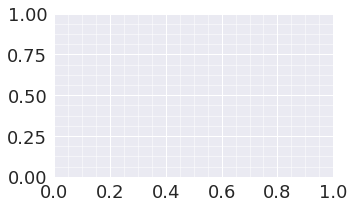

In [158]:
data_dirs = [
    pathlib.Path('logs'),
]

def get_filenames(name, require_one=False):
    name = str(name)
    name_paths = []
    for data_dir in data_dirs:
        for exp_dir in data_dir.iterdir():
            if name in exp_dir.name:
                name_paths.append(exp_dir)
    if require_one:
        assert len(name_paths) == 1, ("Didn't find exactly 1 run name", name_paths)
        return name_paths[0]
    return name_paths

def format_plot():
    fig, ax = plt.subplots(1, 1)
    sbn.set_style('darkgrid')
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='w', linewidth=1.0)
    ax.grid(b=True, which='minor', color='w', linewidth=0.5)
format_plot()


def load_data(name, file_name):
    if type(name) is pathlib.PosixPath:
        require_one = True
        name_paths = [name]
    else:
        require_one = False
        name_paths = get_filenames(name)
    assert len(name_paths) > 0, "No files found with name " + name
    # check that they're all the same except the seed
    csv_datas = []
    for path in name_paths:
        csv_name = path.joinpath(file_name)
        data = pd.read_csv(csv_name)
        csv_datas.append(data)
    if require_one:
        csv_datas = csv_datas[0]
    return csv_datas
        
def plot_final_generalization(runs, title, metric='success_rate', all_run_names=None, all_env_names=None,
                             save_name=None):
    env_dict = {}
    for run_names, legend_name in runs:
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name, file_name='results.csv')
            success = [df[metric].to_numpy() for df in data]
            env_names = data[0]['env'].to_numpy()
            for i, env_name, in enumerate(env_names):
                if all_run_names is not None and not env_name in all_run_names:
                    continue
                if not env_name in env_dict:
                    env_dict[env_name] = ([], [], [])
                mean_list, std_list, legend_list = env_dict[env_name]
                mean_list.append(np.mean([s[i].item() for s in success]))
                std_list.append(np.std([s[i].item() for s in success]))
                legend_list.append(legend_name)
        except Exception as e:
            print("Error on ", run_names, e)
    print("ENV DICT", env_dict.keys())
    colors = ['blue', 'green', 'orange', 'purple', 'red', 'yellow', 'brown', 'pink']
    for i, (env_name, (mean_list, std_list, legend_list)) in enumerate(env_dict.items()):
        if all_env_names is not None:
            env_title = all_env_names[i]
        else:
            env_title = title
#         plt.title(env_title, fontsize=20)
        plt.title(title + ' - ' + str(env_name) + '; ' + metric, fontsize=20)
        color = 'green' if 'accuracy' in metric else None
        plt.bar(legend_list, mean_list, yerr=std_list, capsize=5, color=color)
        plt.xticks(rotation=80, fontsize=20)
        plt.ylim(0, 1)
        if save_name is not None:
            plt.savefig('figs/' + save_name + env_title + '.png', bbox_inches='tight')
        plt.show()
        
def bar_plot_at_point(runs, title, metric='success_rate', 
                      smooth=1,  x_metric='Itrs', x_eval=None, save_name=None,):
    use_itrs = x_metric in ['Itrs', 'Samples']
    
    # Load data
    all_data = eval_at_point(runs, metric, smooth, use_itrs, x_eval)
    
    x_labels = list(all_data.keys())
    y_means, y_stds = zip(*list(all_data.values()))
    print("DATA", y_means, y_stds)

    plt.title(title, fontsize=20)
    color = 'green' if 'accuracy' in metric else 'blue'
    plt.bar(x_labels, y_means, yerr=y_stds, capsize=5, color=color)
    plt.xticks(rotation=80, fontsize=20)
    plt.ylim(0, 1)
    if save_name is not None:
        plt.savefig(f'figs/{save_name}.pdf', bbox_inches='tight')
    plt.show()

    

def eval_at_point(runs, metric='success_rate', smooth=1,  use_itrs=True, x_eval=None):
    all_data = {}
    for run_info in runs:
        run_names, cell_name, feedback_per_timestep, color, oracle = run_info
        try:   
            # Load data
            use_itrs_run = use_itrs or oracle
            x_list, y_list = load_runs_data(run_names, metric, feedback_per_timestep, smooth, use_itrs_run)
            y_eval = [np.interp([x_eval], x_run, y_run) for x_run, y_run in zip(x_list, y_list)]
            y_mean = np.round(np.mean(y_eval), 2)
            y_std = np.round(np.std(y_eval), 2)
            plt.show()
            
            # Sanity check we have each combo only once before we store
            assert not cell_name in all_data
            
            # Store it
            all_data[cell_name] = (y_mean, y_std)
        except Exception as e:
            print("Error on ", run_names, e)
    return all_data

            
def make_table(runs, title, metric='success_rate', smooth=1,  x_metric='Itrs',
                x_eval=None, plot_latex=False, transpose=False):
    use_itrs = x_label in ['Itrs', 'Samples']
    
    # Load data
    all_data = eval_at_point(runs, metric, smooth, use_itrs, x_eval)
    
    # record the rows and cols in the order they appear
    all_rows = []
    all_cols = []
    for run_info in runs:
        _, cell_name, _, _, _ = run_info
        row_name, col_name = cell_name
        if not row_name in all_rows:
            all_rows.append(row_name)
        if not col_name in all_cols:
            all_cols.append(col_name)
            
    df = pd.DataFrame(index=all_rows,columns=all_cols)
    df_mean = pd.DataFrame(index=all_rows,columns=all_cols)
    df_std = pd.DataFrame(index=all_rows,columns=all_cols)
    for (row, col), (mean, std) in all_data.items():
        df_mean.at[row, col] = mean
        df_std.at[row, col] = std
        
    df_mean = df_mean.to_numpy()
    df_std = df_std.to_numpy()
    
    plus_minus = '\pm' if plot_latex else '+/-'
    
    for row in range(len(df_mean)):
        vals = []
        max_mean = 0
        max_std = 0
        for col in range(len(df_mean[0])):
            mean = df_mean[row, col]
            std = df_std[row, col]
            if mean > max_mean:
                max_mean = mean
                max_std = std
            vals.append((mean, std))
        for col, (mean, std) in enumerate(vals):
            t_start = '$ \mathbf{'  # Original!!
            # t_start = '$ \{'
            t_end = '}'
            if mean + std > max_mean - max_std:
                print('BOLDING', mean, std, 'compared to', max_mean, max_std)
                s = f'{t_start} {mean} {plus_minus} {std} {t_end} $'
            else:
                s = f'${mean} {plus_minus} {std} $'
            df.at[all_rows[row], all_cols[col]] = s
    
    
    # Plot the table
    if plot_latex:
        print(df.to_latex())
    else:
        print(df)
    return df
            
    
            
def load_run_data(run_name):
    name_path = get_filenames(run_name, require_one=True)

    # Load data as a pandas data frame
    data = load_data(name_path, file_name='results.csv')
    return data

def load_runs_data(run_names, metric, feedback_per_timestep, smooth, use_itrs):
    env_name = None
    x_list, y_list = [], []
    for run_name in run_names:  # loop through curves plotted together
        data = load_run_data(run_name)

        # Sanity check all the runs are from the same env
        if env_name is None:
            env_name = data.iloc[0]['env']
            print("ENV NAME", env_name)
        else:
            assert env_name == data.iloc[0]['env'], ("Env name mismatch", (env_name, data.iloc[0]['env']))

        # Store all runs in this set so we can plot them together
        y_data = data[metric].ewm(span=smooth).mean().to_numpy()
        y_list.append(y_data)
        x_unit_name = 'itr' if use_itrs else 'num_feedback'
        # print('X UNIT NAME', x_unit_name)
        # print('FEEDBACK PER TIMESTEP', feedback_per_timestep)
        x_data = data[x_unit_name].to_numpy() * feedback_per_timestep
        # print('X data', x_data)
        x_list.append(x_data)
    return x_list, y_list
    

def plot_convergence_marker(runs, title, metric='success_rate', smooth=1, 
                                 x_label='Itrs', y_label='default', 
                                 y_min=0, y_max=1.01, save_name=None,
                                 x_min=None, x_max=None, convergence_val=None,):
    use_itrs = x_label in ['Itrs', 'Samples']
    all_labels = []
    all_colors = []
    
    # Plot a vertical line with the convergence_val
    plt.axhline(convergence_val, color='black')
    
    for run_info in runs:
        run_names, legend_name, feedback_per_timestep, c, marker = run_info
        try:
            use_itrs_run = use_itrs or 'Oracle' in legend_name
            x_list, y_list = load_runs_data(run_names, metric, feedback_per_timestep, smooth, use_itrs_run)
            
            shortest_len = min([x[-1] for x in x_list])
            print("lengths", [x[-1] for x in x_list])
            x = np.linspace(0, shortest_len, 50)
            y = np.stack([np.interp(x, run_x, run_y) for run_x, run_y in zip(x_list, y_list)])
            mean_y = np.mean(y, axis=0)
            std_y = np.std(y, axis=0)
            
            
            
            # Plot it!
            plt.plot(x, mean_y, c=c, marker=marker)
            plt.fill_between(x, mean_y - std_y, mean_y + std_y, alpha=0.2, color=c)
            # Plot a vertical line for the convergence location
            try:
                # Find the first point where the mean is greater than convergence_val
                first_point = np.where(mean_y > convergence_val)[0][0]
                first_point_x = x[first_point]
                print('FIRST', first_point, first_point_x, legend_name)
                plt.axvline(x=first_point_x, color=c, linestyle='--')
            except Exception as e:
                print('error with plotting vline', e)

            all_labels.append(legend_name)
            all_colors.append(c)
        except Exception as e:
            print("Error on ", run_names, e)
        
    # Additional plotting
    plt.ticklabel_format(scilimits=(0,0), fontsize=20, style='sci')
    plt.title(title, fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.rc('font', size=18)
    if x_max is not None:
        if x_min is None:
            x_min = 0
        plt.xlim(x_min, x_max)
    y_label = metric if y_label == 'default' else y_label
    plt.ylabel(y_label, fontsize=20)
    plt.xlabel(x_label, fontsize=20)
    plt.ylim(y_min, y_max)
    if save_name is not None:
        plt.savefig('figs/' + save_name, bbox_inches='tight')
    plt.show()

    # Plot legend below
    for c in all_colors:
        plt.plot([1], [1], color=c)
    plt.xlim(-10, 0)
    plt.ylim(-2, -1)
    plt.legend(all_labels, fontsize=20)
    plt.box(False)
    plt.axis('off')
#     plt.savefig('figs/legend_' + save_name, bbox_inches='tight')
    plt.show()



def plot_finetune_generalization(runs, title, metric='success_rate', smooth=1, 
                                 x_label='Itrs', y_label='default', 
                                 y_min=0, y_max=1.01, save_name=None,
                                 x_min=None, x_max=None):
    use_itrs = x_label in ['Itrs', 'Samples']
    all_labels = []
    all_colors = []
    for run_info in runs:
        run_names, legend_name, feedback_per_timestep, c, marker = run_info
        try:
            use_itrs_run = use_itrs or 'Oracle' in legend_name
            x_list, y_list = load_runs_data(run_names, metric, feedback_per_timestep, smooth, use_itrs_run)
            
            shortest_len = min([x[-1] for x in x_list])
            print("lengths", [x[-1] for x in x_list])
            x = np.linspace(0, shortest_len, 50)
            y = np.stack([np.interp(x, run_x, run_y) for run_x, run_y in zip(x_list, y_list)])
            mean_y = np.mean(y, axis=0)
            std_y = np.std(y, axis=0)
            
            # Plot it!
            plt.plot(x, mean_y, c=c, marker=marker)
            plt.fill_between(x, mean_y - std_y, mean_y + std_y, alpha=0.2, color=c)

            all_labels.append(legend_name)
            all_colors.append(c)
        except Exception as e:
            print("Error on ", run_names, e)
        
    # Additional plotting
    plt.ticklabel_format(scilimits=(0,0), fontsize=20, style='sci')
    plt.title(title, fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.rc('font', size=18)
    if x_max is not None:
        if x_min is None:
            x_min = 0
        plt.xlim(x_min, x_max)
    y_label = metric if y_label == 'default' else y_label
    plt.ylabel(y_label, fontsize=20)
    plt.xlabel(x_label, fontsize=20)
    plt.ylim(y_min, y_max)
    if save_name is not None:
        plt.savefig('figs/' + save_name, bbox_inches='tight')
    plt.show()

    # Plot legend below
    for c in all_colors:
        plt.plot([1], [1], color=c)
    plt.xlim(-10, 0)
    plt.ylim(-2, -1)
    plt.legend(all_labels, fontsize=20)
    plt.box(False)
    plt.axis('off')
#     plt.savefig('figs/legend_' + save_name, bbox_inches='tight')
    plt.show()
        
def add_line(height, text, color=None, above=True):
    plt.axhline(height, color=color, ls='--')
    offset = .01 if above else -.12
    plt.rc('font', size=12)
    plt.text(0, height + offset, text)

# FINALEST RUNS

In [4]:
global_smooth = 20

## Training

### PM RL Training Curves

In [5]:
plt.rcParams['figure.figsize'] = [10, 5]

ENV NAME 4
lengths [8329472, 7577193, 7266053]
ENV NAME 4
lengths [1054349, 1084372, 1106928]
ENV NAME 4
lengths [1150990, 1159555, 1182416]
ENV NAME 4
lengths [1087565, 1119159, 1082820]
ENV NAME 4
lengths [7000000, 7000000, 7000000]


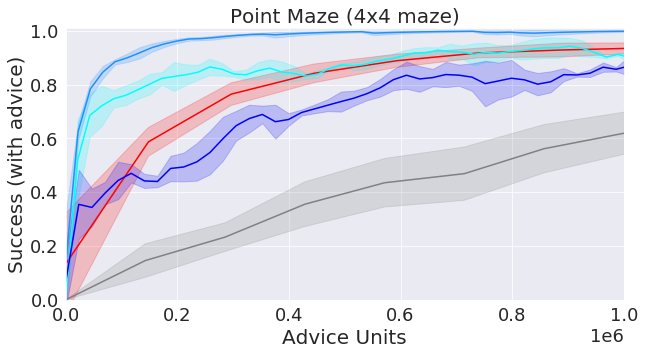

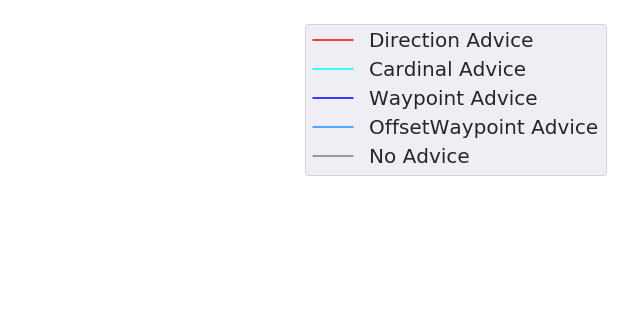

In [162]:
samples = False


plt.rcParams['figure.figsize'] = [10, 5]

x_unit = 'Samples' if samples else 'feedback'
x_label = 'Samples' if samples else 'Advice Units'
x_max = 7e6 if samples else 1e6
smooth = 10

all_multiplier = 200 * 20 if samples else 1


data_names = [
        (['M0000', 'M0001', 'M0002'], 'Direction Advice', all_multiplier, 'red', None),
        (['M0003', 'M0004', 'M0005'], 'Cardinal Advice', all_multiplier, 'cyan', None),
        (['M0006', 'M0007', 'M0008'], 'Waypoint Advice', all_multiplier, 'blue', None),
        (['M0009', 'M0010', 'M0011'], 'OffsetWaypoint Advice', all_multiplier, 'dodgerblue', None),
        (['M0012', 'M0013', 'M0014'], 'No Advice', all_multiplier, 'gray', None),
    ]


metric = 'success_rate'
plot_finetune_generalization(data_names, 'Point Maze (4x4 maze)', metric=metric, smooth=global_smooth, 
                             x_label=x_label, x_max=x_max, 
                             save_name=f'rl_train_pm{"_samples" if samples else ""}.pdf',
                             y_label="Success (with advice)")

In [7]:
# samples = False


# plt.rcParams['figure.figsize'] = [10, 5]
# x_unit = 'Samples' if samples else 'feedback'
# smooth = 20

# data_names = [
#         (['R0000', 'R0001', 'R0002'], 'Direction Advice', 1, 'red', None),
#         (['R0003', 'R0004', 'R0005'], 'Cardinal Advice', 1, 'firebrick', None),
#         (['R0006', 'R0007', 'R0008'], 'Waypoint Advice', 1, 'blue', None),
#         (['R0009', 'R0010', 'R0011'], 'OffsetWaypoint Advice', 1, 'dodgerblue', None),
#         (['R0012', 'R0013', 'R0014'], 'No Advice', 1, 'gray', None),
#     ]

# metrics = ['Train/Success']
# plot_curriculum(data_names, x_unit, 
#                 y=metrics, 
#                 smooth=20, error_bars=True, 
#                 title="Point Mass Env",
#                y_lower=0, y_upper=1, y_label="Success (with access to advice)",
#                save_name=None, x_max=1e6)


# metric = 'success_rate'
# plot_finetune_generalization(data_names, 'Point Mass', metric=metric, smooth=smooth, 
#                              x_label=x_unit)

### PM 0-shot

ENV DICT dict_keys([4, 2, 3, 13, 14])


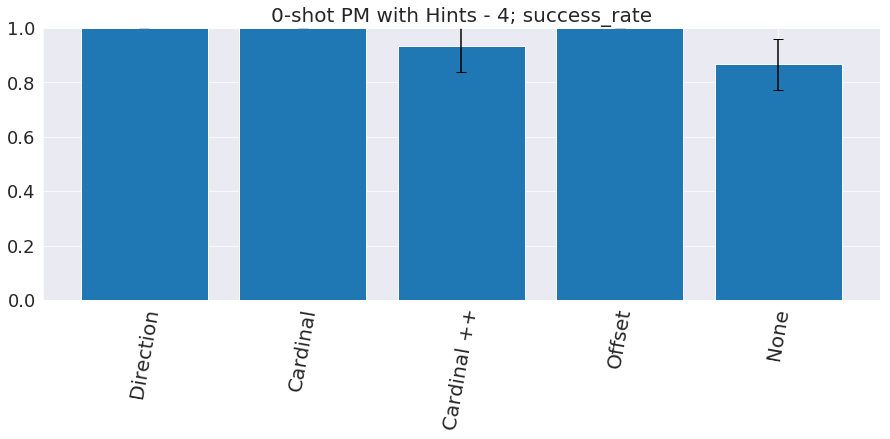

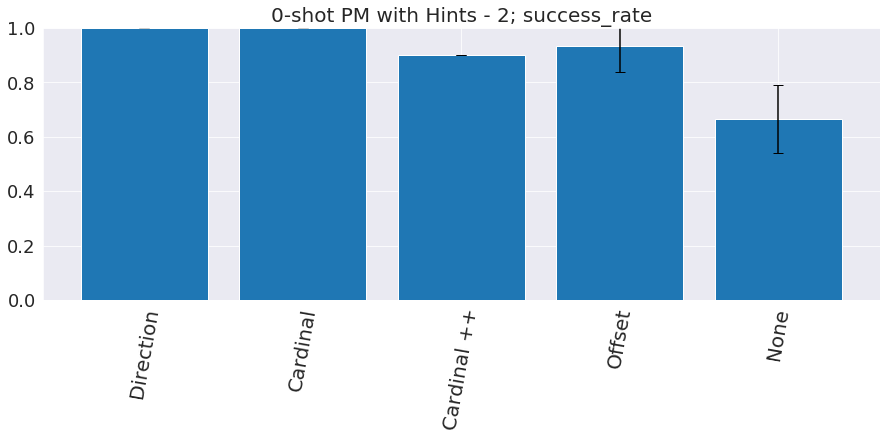

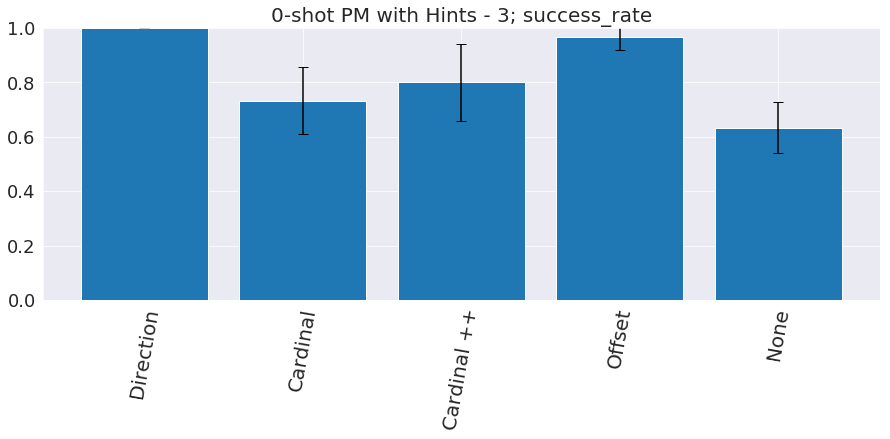

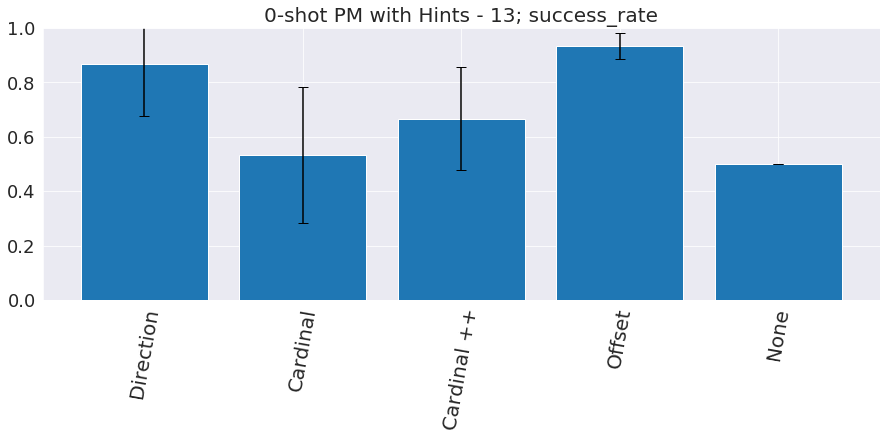

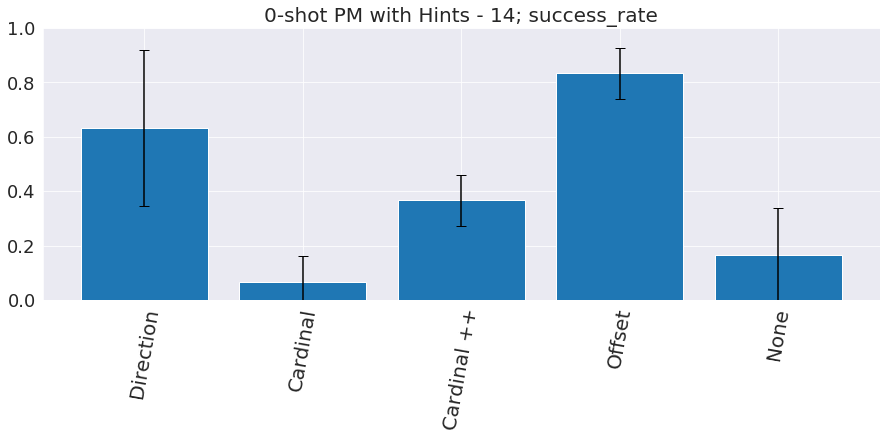

In [8]:
runs = [
    (['R0018', 'R0019', 'R0020'], 'Direction'),
    (['R0021', 'R0022', 'R0023'], 'Cardinal'),
    (['R0042', 'R0043', 'R0044'], 'Cardinal ++'),
#     (['R0024', 'R0025', 'R0026'], 'Waypoint'),
#     (['R0036', 'R0037', 'R0038'], 'Waypoint ++'),  # TODO
    (['R0027', 'R0028', 'R0029'], 'Offset'),  # TODO: run these
    (['R0030', 'R0031', 'R0032'], 'None'),
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot PM with Hints')

ENV DICT dict_keys([4, 2, 3, 13, 14])


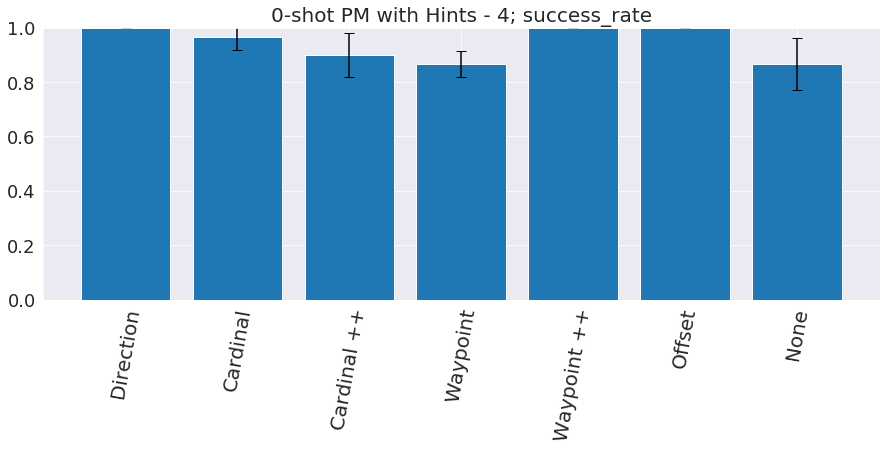

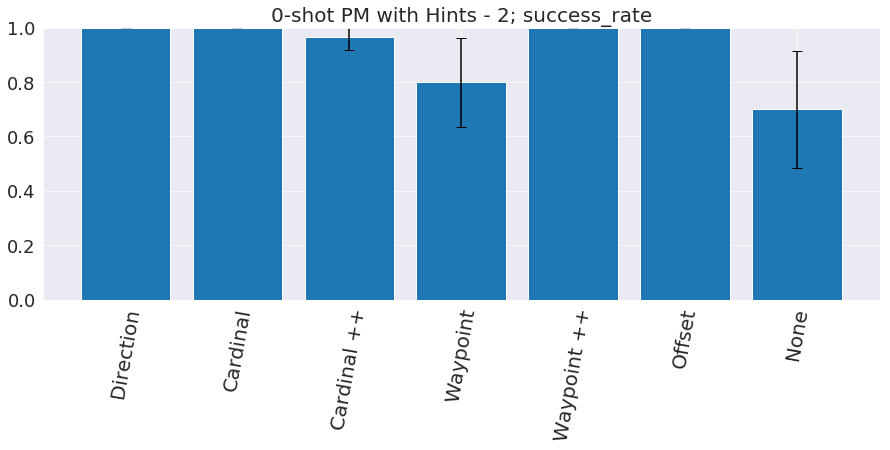

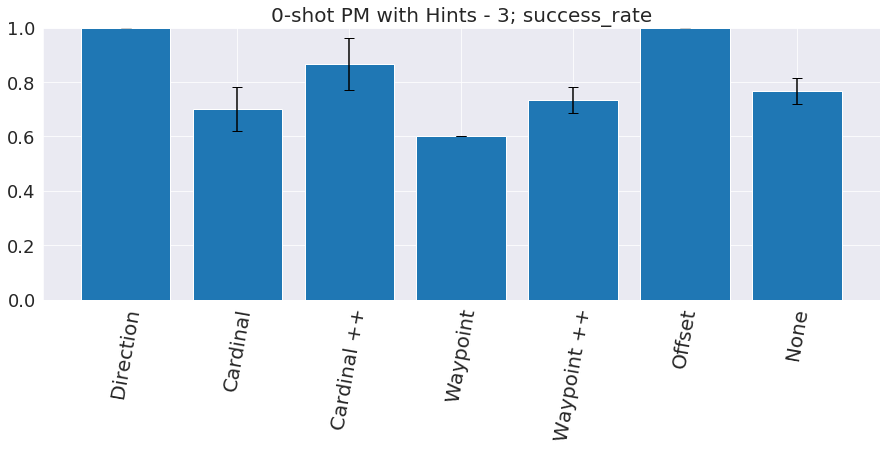

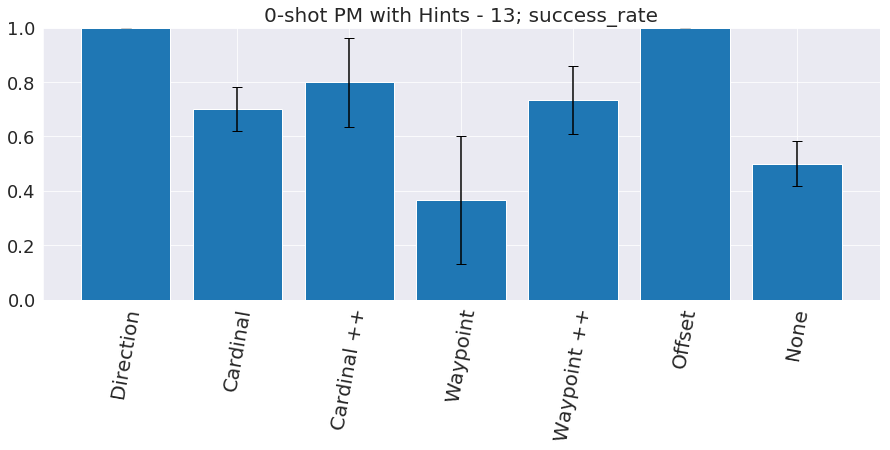

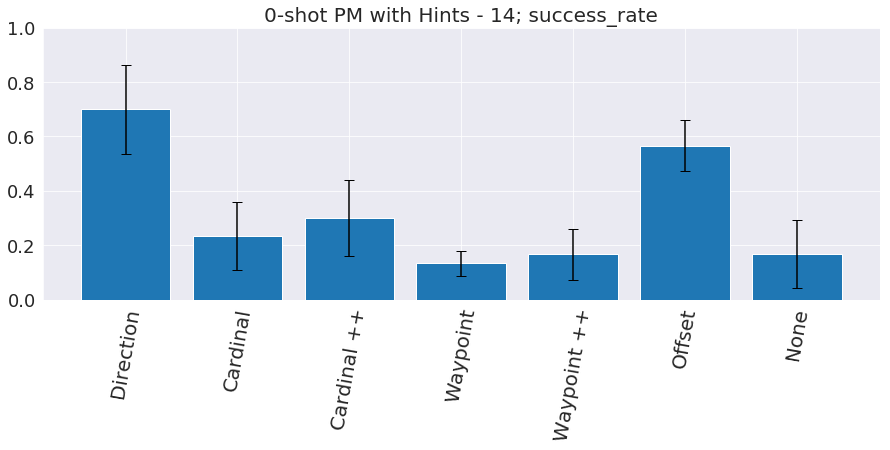

In [9]:
runs = [
    (['M0018', 'M0019', 'M0020'], 'Direction'),
    (['M0021', 'M0022', 'M0023'], 'Cardinal'),
    (['M0042', 'M0043', 'M0044'], 'Cardinal ++'),
    (['M0024', 'M0025', 'M0026'], 'Waypoint'),
    (['M0036', 'M0037', 'M0038'], 'Waypoint ++'),  # TODO
    (['M0027', 'M0028', 'M0029'], 'Offset'),  # TODO: run these
    (['M0030', 'M0031', 'M0032'], 'None'),
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot PM with Hints')

### BabyAI Training Curves

ENV NAME 25
X UNIT NAME itr
FEEDBACK PER TIMESTEP 1000
X data [      0   20000   40000   60000   80000  100000  120000  140000  160000
  180000  200000  220000  240000  260000  280000  300000  320000  340000
  360000  380000  400000  420000  440000  460000  480000  500000  520000
  540000  560000  580000  600000  620000  640000  660000  680000  700000
  720000  740000  760000  780000  800000  820000  840000  860000  880000
  900000  920000  940000  960000  980000 1000000 1020000 1040000 1060000
 1080000 1100000 1120000 1140000 1160000 1180000 1200000 1220000 1240000
 1260000 1280000 1300000 1320000 1340000 1360000 1380000 1400000 1420000
 1440000 1460000 1480000 1500000]
X UNIT NAME itr
FEEDBACK PER TIMESTEP 1000
X data [      0   20000   40000   60000   80000  100000  120000  140000  160000
  180000  200000  220000  240000  260000  280000  300000  320000  340000
  360000  380000  400000  420000  440000  460000  480000  500000  520000
  540000  560000  580000  600000  620000  640000  6

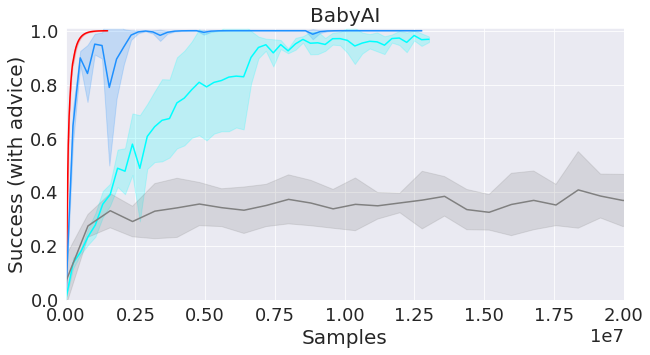

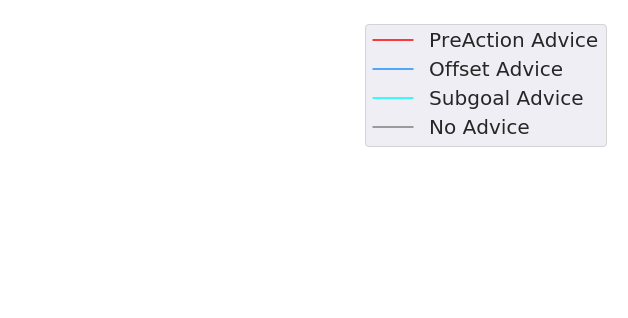

In [54]:
samples = True


plt.rcParams['figure.figsize'] = [10, 5]

x_unit = 'Samples' if samples else 'feedback'
x_label = 'Samples' if samples else 'Advice Units'
x_max = 2e7 if samples else 1e7
all_multiplier = 100 * 10 if samples else 1


smooth = 10

data_names = [
        (['M0141', 'M0142', 'M0143'], 'PreAction Advice', all_multiplier, 'red', None),
        (['M0144', 'M0145', 'M0146'], 'Offset Advice', all_multiplier, 'dodgerblue', None),
#         (['M0147', 'M0148', 'M0149'], 'Old Subgoal Advice', all_multiplier, 'cyan', None),
        (['M0540', 'M0541', 'M0542'], 'Subgoal Advice', all_multiplier, 'cyan', None),
        (['M0150', 'M0151', 'M0152'], 'No Advice', all_multiplier, 'gray', None),
    
    ]

metric = 'success_rate'
plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=global_smooth, 
                             x_label=x_label, x_max=x_max,
                             y_label="Success (with advice)",
                             save_name=f'rl_train_babyai{"_samples" if samples else ""}.pdf')

# metric = 'stoch_accuracy'
# plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, 
#                              x_label=x_unit, new_logging=True, x_max=1e7)


In [11]:
run_name = 'M0150'
data = load_run_data(run_name)


In [12]:
data

policy_env policy  env  success_rate  stoch_accuracy    itr  \
0     PolicyM0150-25  M0150   25           0.0        0.136682      0   
1     PolicyM0150-25  M0150   25           0.0        0.408405     20   
2     PolicyM0150-25  M0150   25           0.2        0.313107     40   
3     PolicyM0150-25  M0150   25           0.0        0.335129     60   
4     PolicyM0150-25  M0150   25           0.0        0.341595     80   
...              ...    ...  ...           ...             ...    ...   
2006  PolicyM0150-25  M0150   25           0.2        0.488404  40120   
2007  PolicyM0150-25  M0150   25           0.2        0.533424  40140   
2008  PolicyM0150-25  M0150   25           0.4        0.521490  40160   
2009  PolicyM0150-25  M0150   25           0.2        0.512960  40180   
2010  PolicyM0150-25  M0150   25           0.2        0.544338  40200   

      num_feedback           time    reward  
0                0      22.984747  0.013668  
1            20000     125.417702  0.040841  
2            40000     233.226043  0.032000  
3            60000     345.185737  0.033513  
4            80000     455.767405  0.034159  
...            ...            ...       ...  
2006      40120000  221314.613271  0.050174  
2007      40140000  221417.944548  0.054676  
2008      40160000  221521.049913  0.053918  
2009      40180000  221624.658131  0.052630  
2010      40200000  221727.653625  0.055767  

[2011 rows x 9 columns]

In [13]:
# x_unit = 'feedback'
# smooth = 1

# data_names = [
#         (['R0141', 'R0142', 'R0143'], 'PreAction Advice', 1, 'red', None),
#         (['R0144', 'R0145', 'R0146'], 'Offset Advice', 1, 'dodgerblue', None),
#         (['R0147', 'R0148', 'R0149'], 'Subgoal Advice', 1, 'cyan', None),
#         (['R0402', 'R0403', 'R0404'], 'No Advice', 1, 'gray', None),
    
#     ]

# metric = 'success_rate'
# plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, 
#                              x_label=x_unit, new_logging=False)

# metric = 'stoch_accuracy'
# plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, 
#                              x_label=x_unit, new_logging=False)

# data_names = [
#         (['R0465', 'R0466', 'R0467'], 'PreAction Advice', 1, 'red', '*'),
#         (['R0468', 'R0469', 'R0470'], 'Offset Advice', 1, 'dodgerblue', '*'),
#         (['R0471', 'R0472', 'R0473'], 'Subgoal Advice', 1, 'cyan', '*'),
#         (['R0474', 'R0475', 'R0476'], 'No Advice', 1, 'gray', '*'),
    
#     ]

# metric = 'success_rate'
# plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, 
#                              x_label=x_unit, new_logging=True)




# metric = 'stoch_accuracy'
# plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, 
#                              x_label=x_unit, new_logging=True)

### BabyAI 0-shot

ENV DICT dict_keys([16, 22, 23, 24, 25, 49, 27, 28, 30, 31])


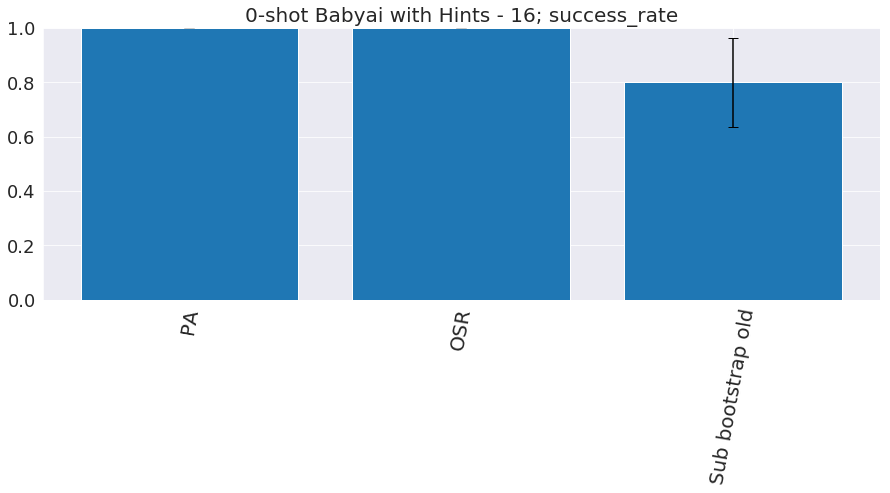

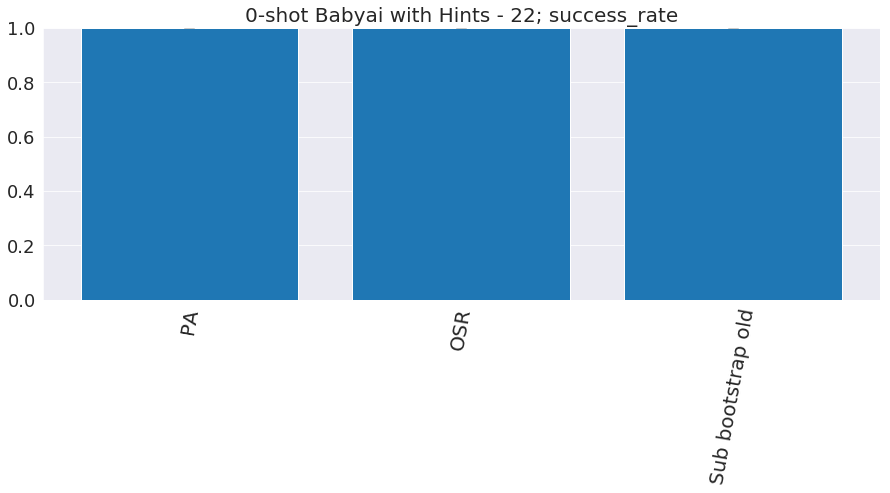

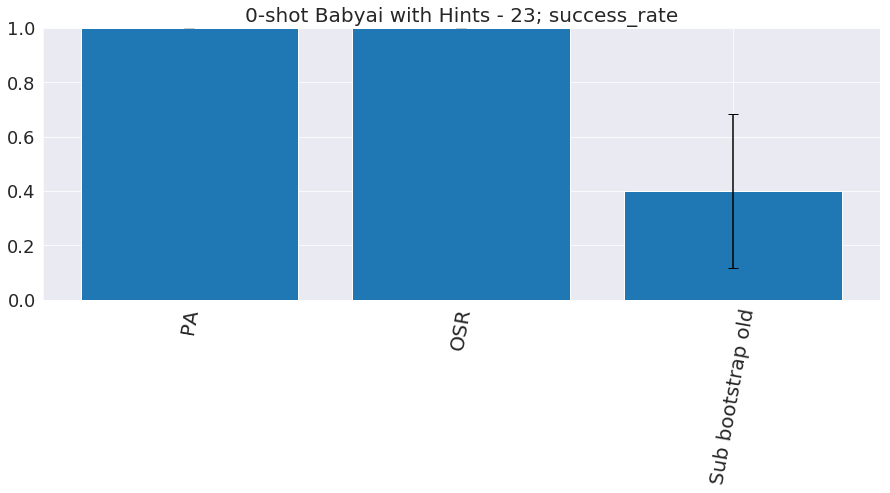

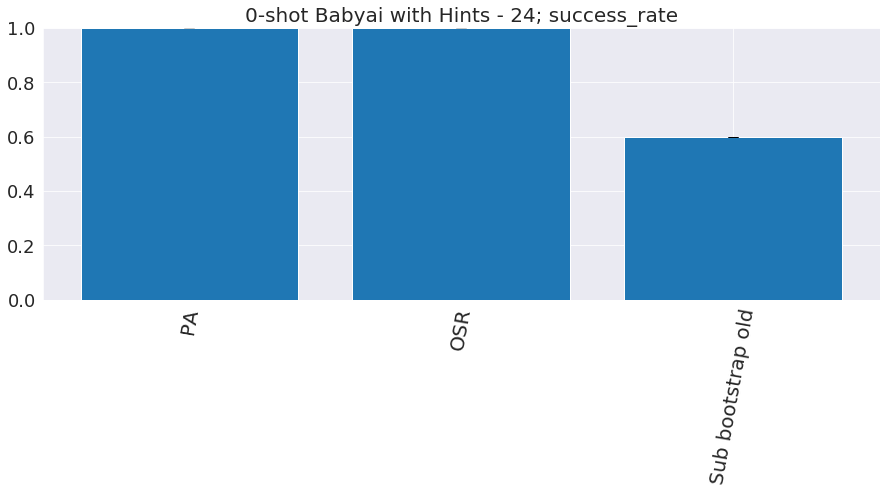

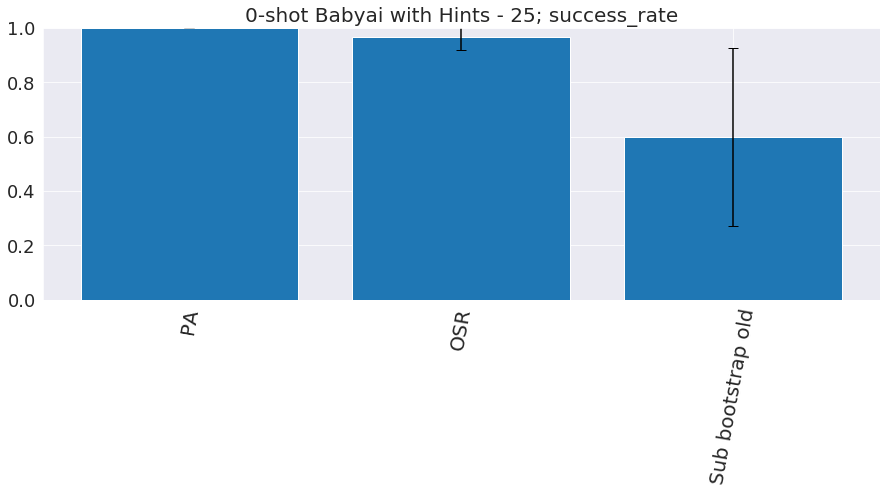

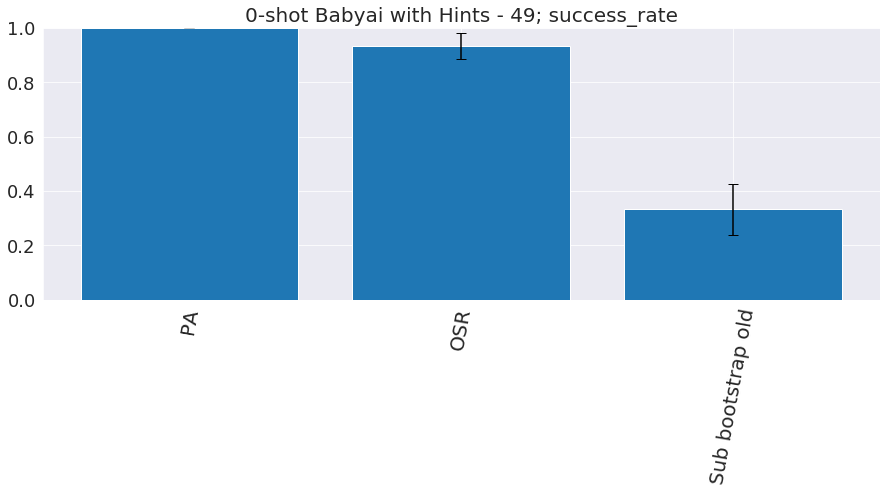

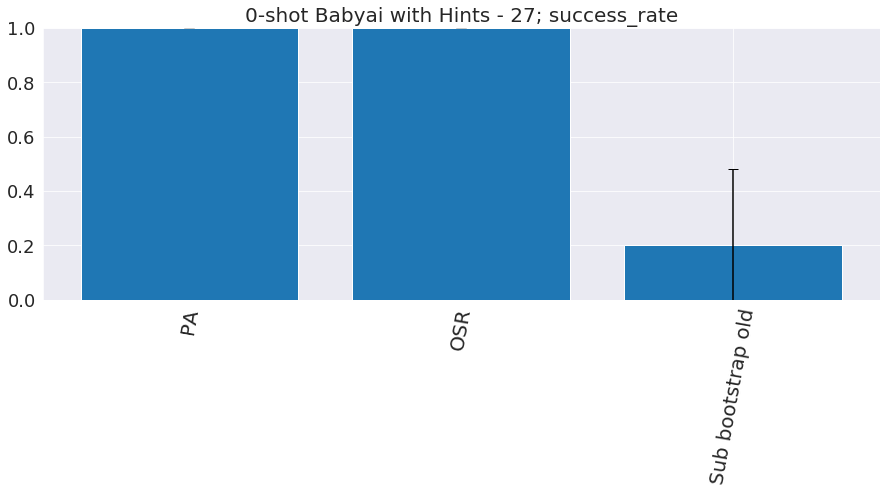

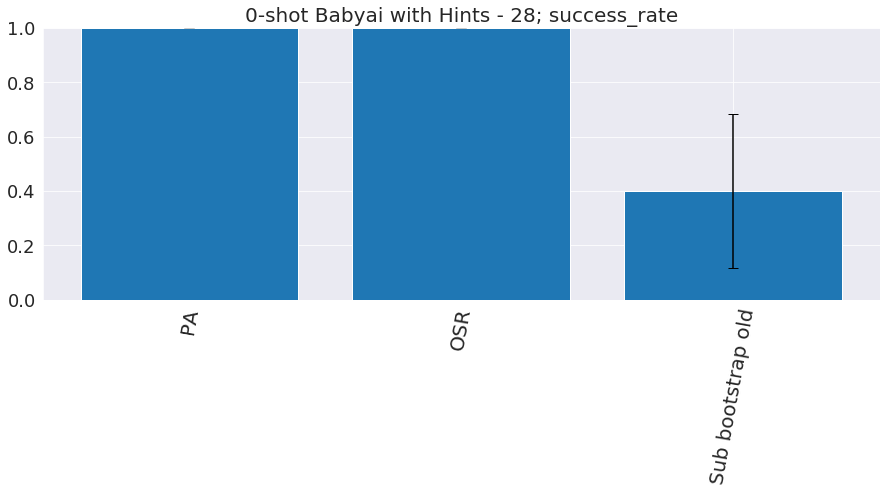

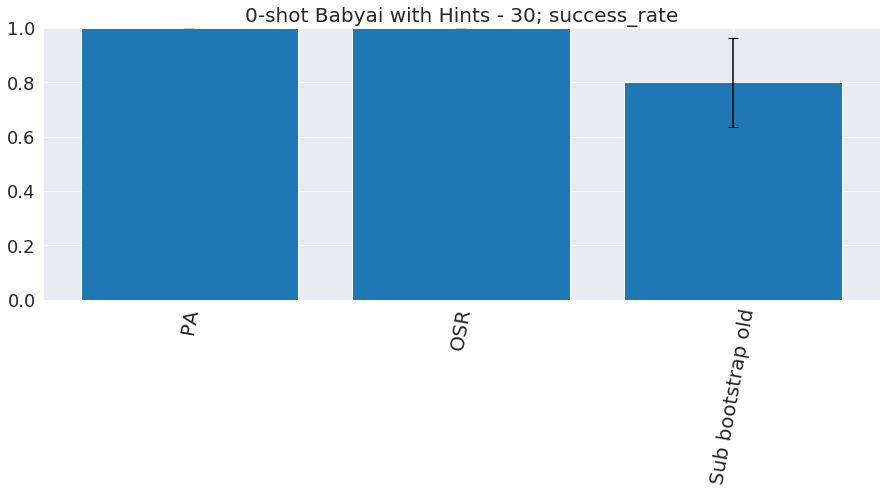

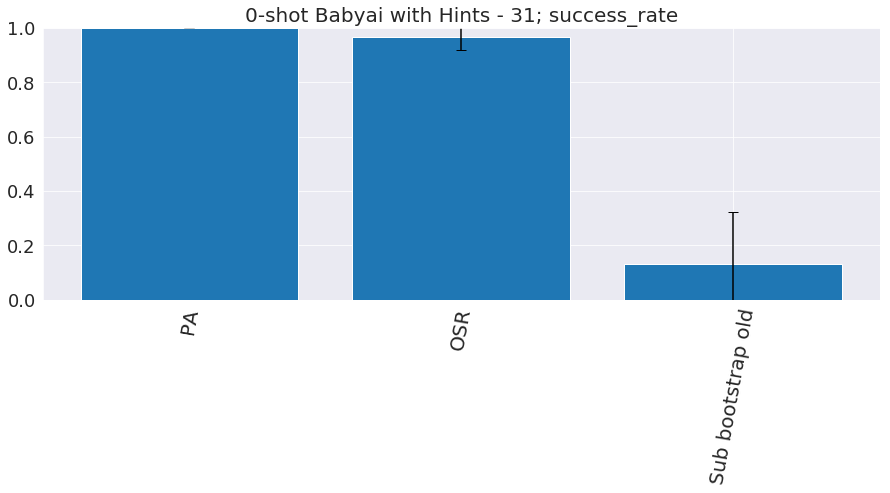

ENV DICT dict_keys([16, 22, 23, 24, 25, 49, 27, 28, 30, 31])


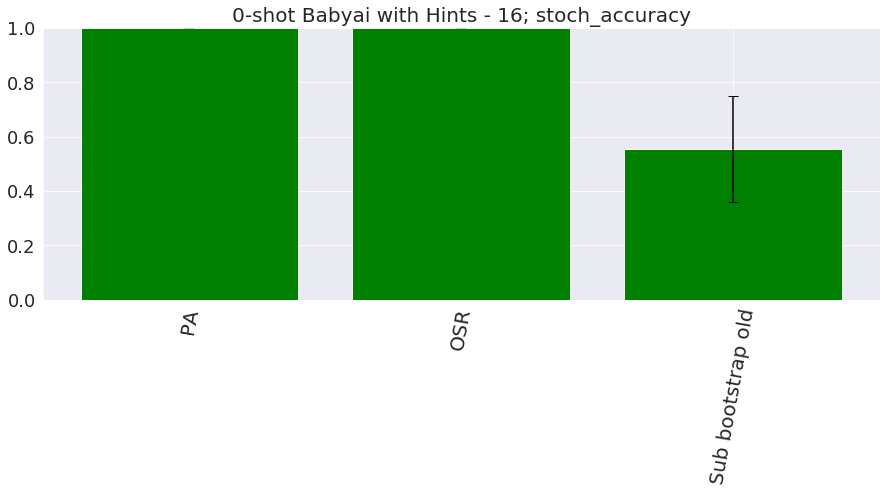

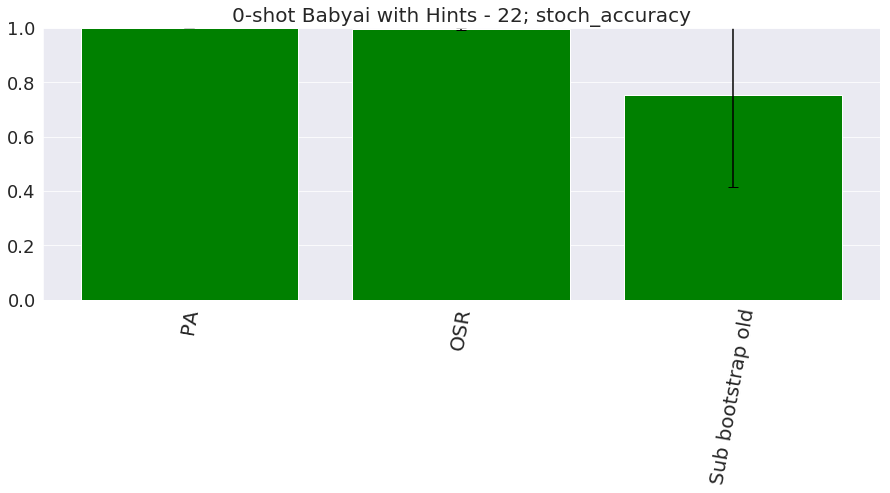

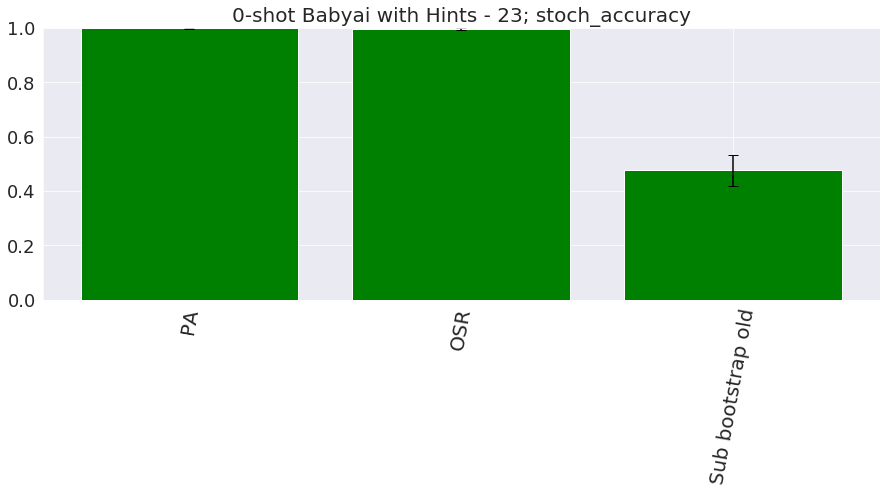

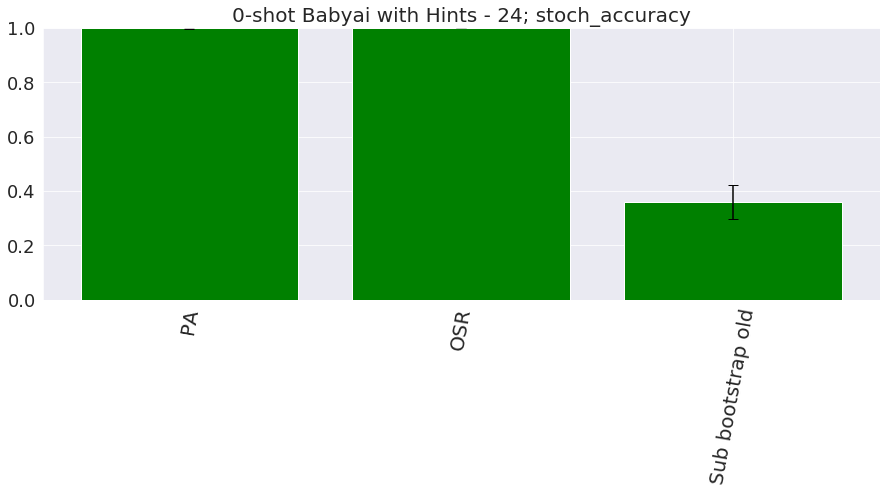

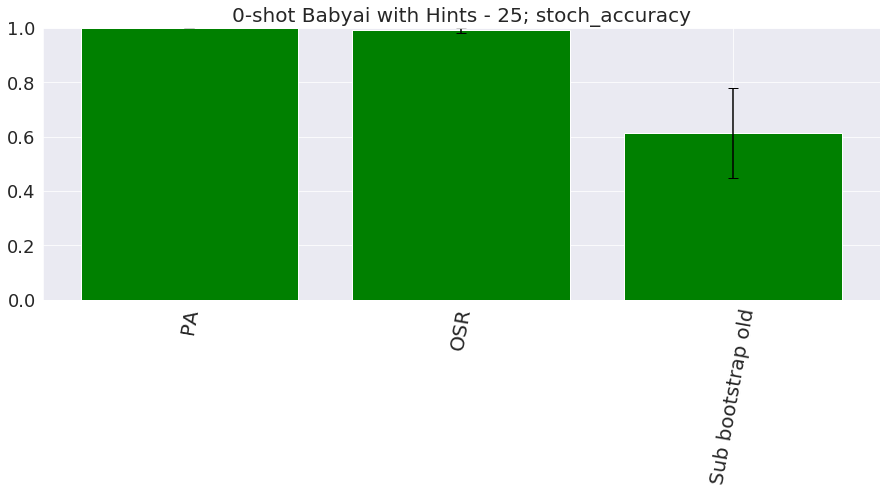

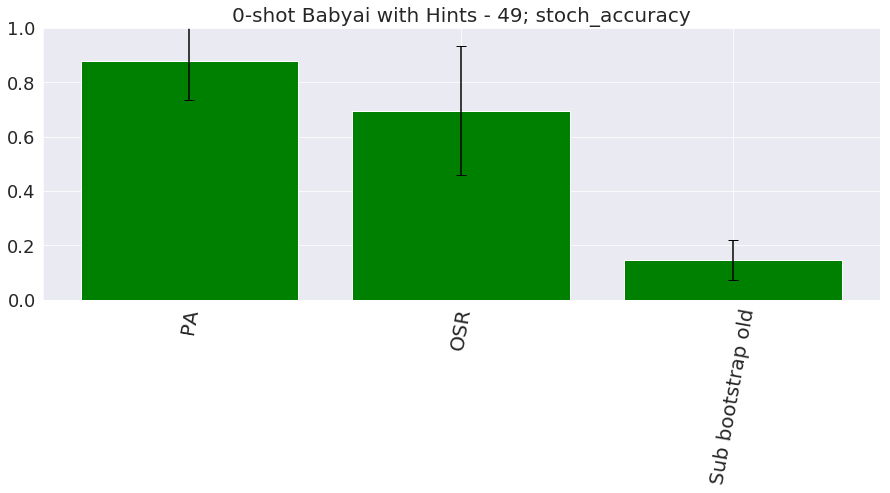

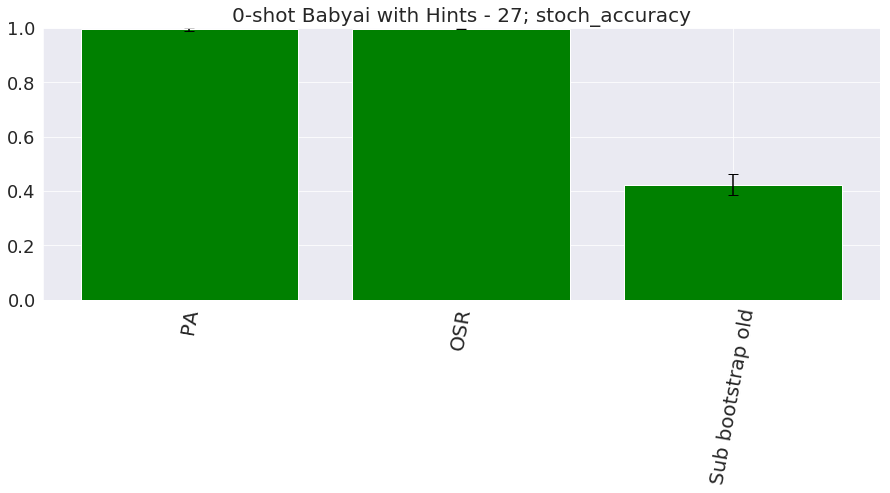

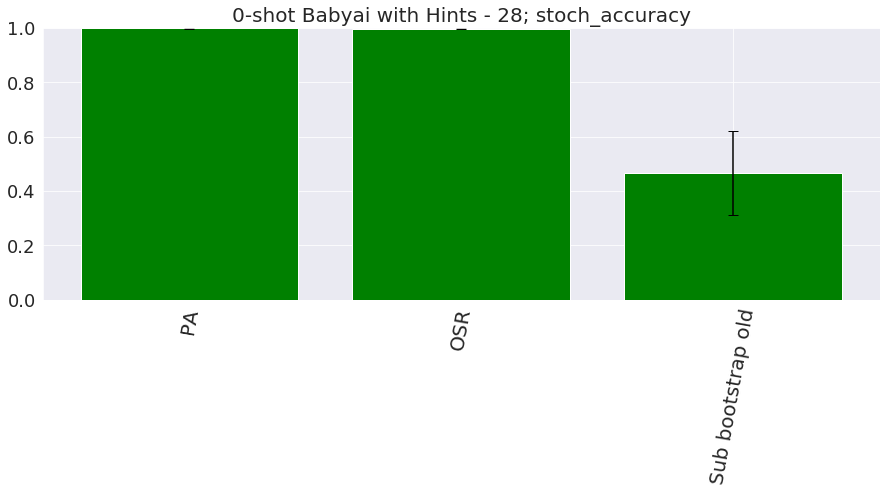

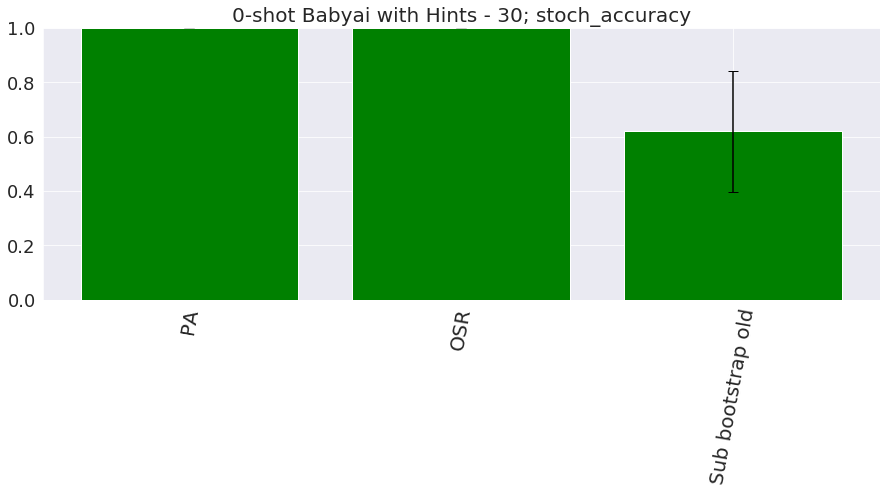

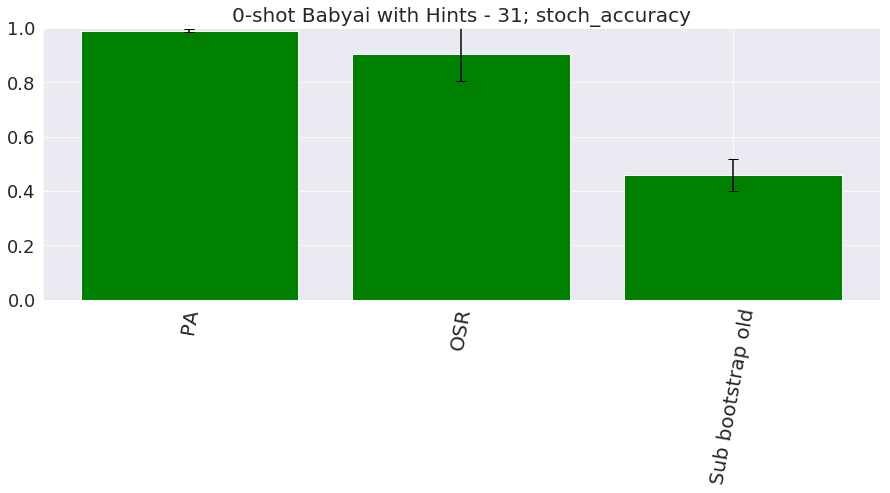

In [14]:
runs = [
    (['M0156', 'M0157', 'M0158'], 'PA'),
    (['M0159', 'M0160', 'M0161'], 'OSR'),
#     (['M0162', 'M0163', 'M0164'], 'Sub'),
#     (['M0180', 'M0181', 'M0182'], 'OSR bootstrap'),
#     (['M0207', 'M0208', 'M0209'], 'OSR Finetuned'),
#     (['M0210', 'M0211', 'M0212'], 'Sub finetuned'),
#     (['M0213', 'M0214', 'M0215'], 'Sub finetuned'),
#     (['M0216', 'M0217', 'M0218'], 'Sub finetuned'),
#     (['M0219', 'M0220', 'M0221'], 'Sub finetuned'),
#     (['M0183', 'M0184', 'M0185'], 'Sub bootstrap'),
    (['Mold183', 'Mold184', 'Mold185'], 'Sub bootstrap old'),
#     (['M0186', 'M0187', 'M0188'], 'Sub bootstrap from OSR'),
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot Babyai with Hints')
plot_final_generalization(runs, '0-shot Babyai with Hints', metric='stoch_accuracy')

ENV DICT dict_keys([57, 59, 60])


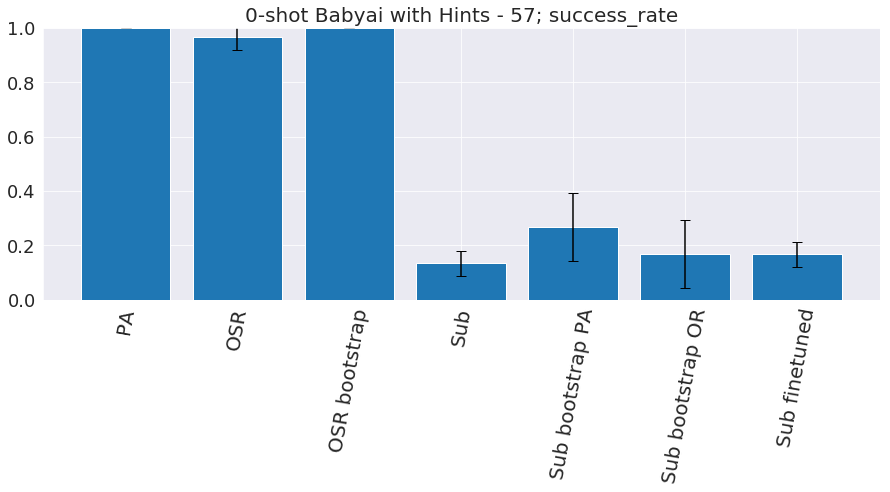

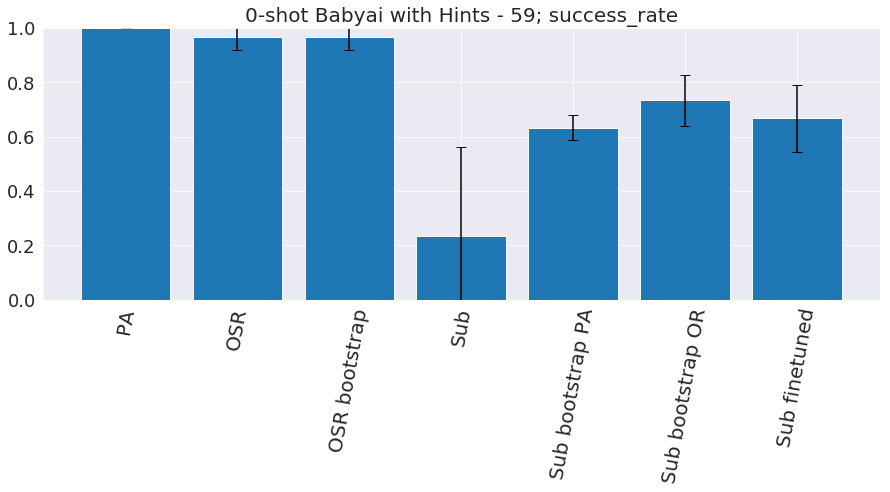

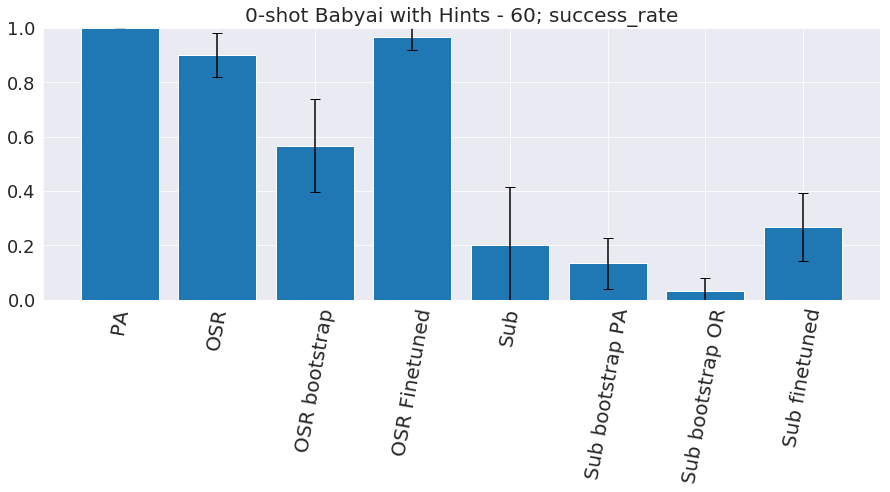

ENV DICT dict_keys([57, 59, 60])


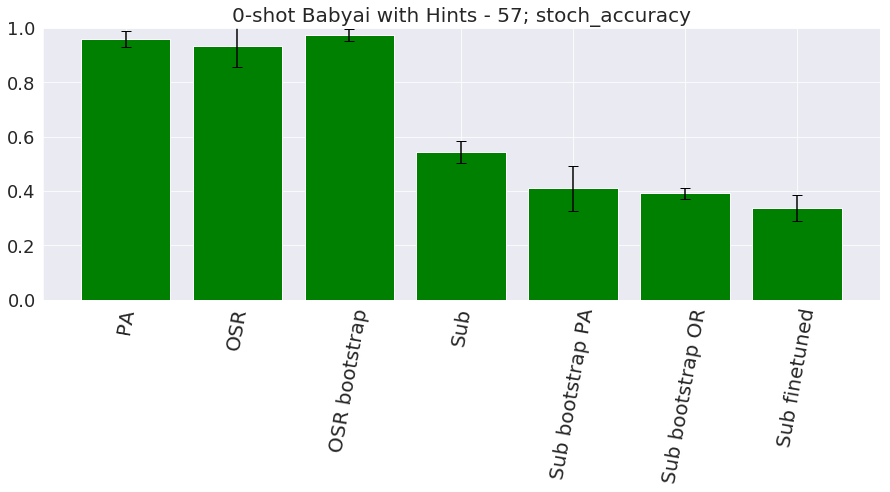

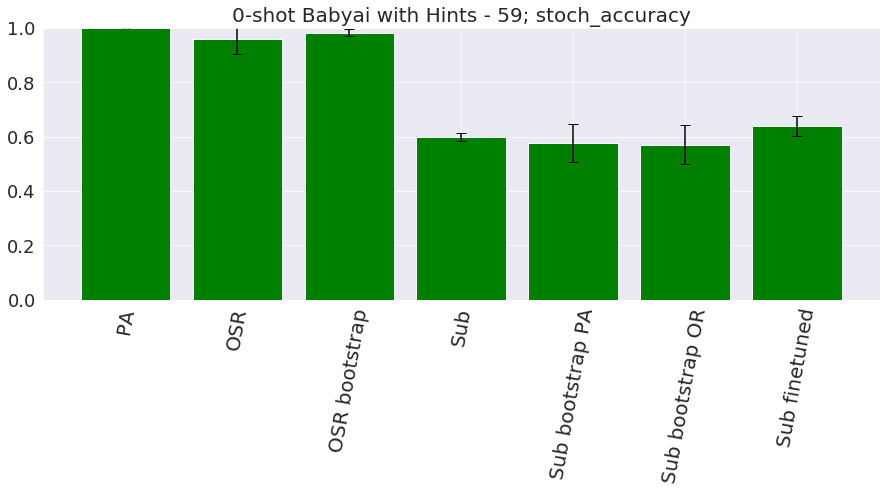

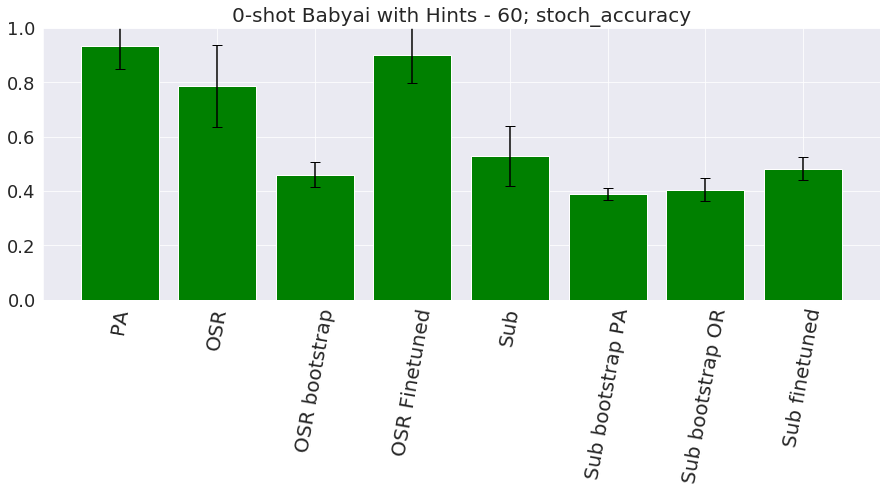

In [15]:
# NEw envs
runs = [
    (['M0462', 'M0463', 'M0464'], 'PA'),
    (['M0465', 'M0466', 'M0467'], 'OSR'),
    (['M0474', 'M0475', 'M0476'], 'OSR bootstrap'),
    (['M0405', 'M0406', 'M0407'], 'OSR Finetuned'),
    (['M0468', 'M0469', 'M0470'], 'Sub'),
    (['M0477', 'M0478', 'M0479'], 'Sub bootstrap PA'),
    (['M0480', 'M0481', 'M0482'], 'Sub bootstrap OR'),
    (['M0408', 'M0409', 'M0410'], 'Sub finetuned'),
    (['M0411', 'M0412', 'M0413'], 'Sub finetuned'),
    (['M0414', 'M0415', 'M0416'], 'Sub finetuned'),
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot Babyai with Hints')
plot_final_generalization(runs, '0-shot Babyai with Hints', metric='stoch_accuracy')

ENV DICT dict_keys([27, 28, 30, 31, 57, 59, 60])


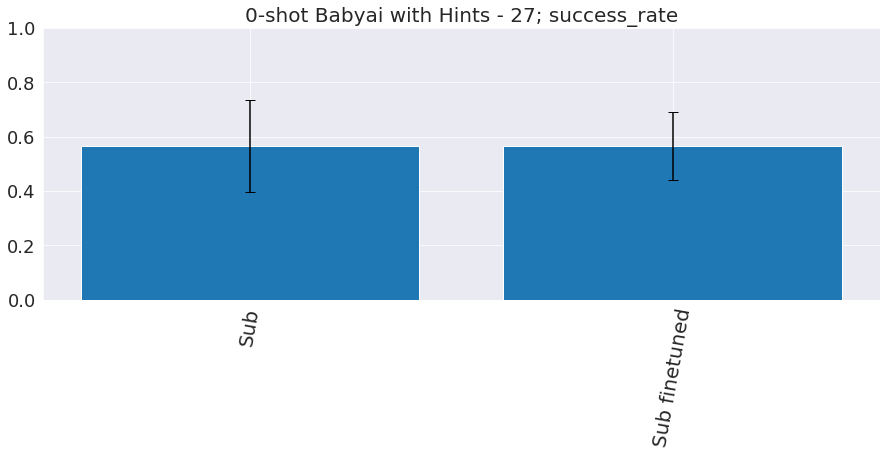

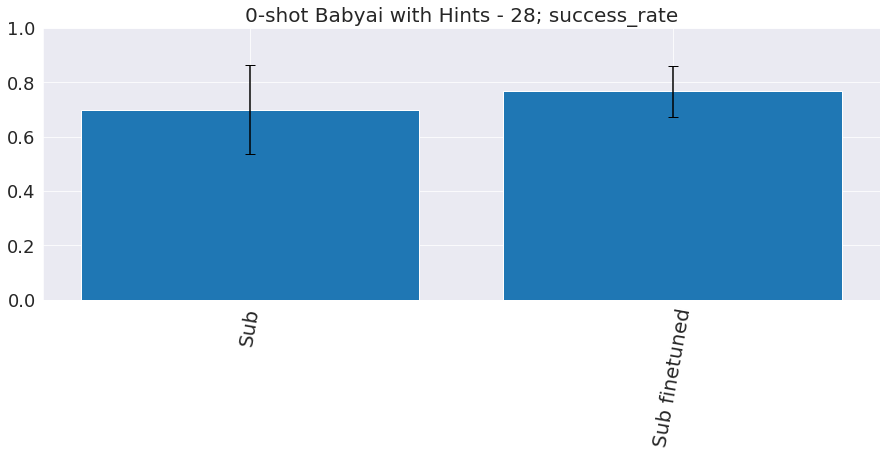

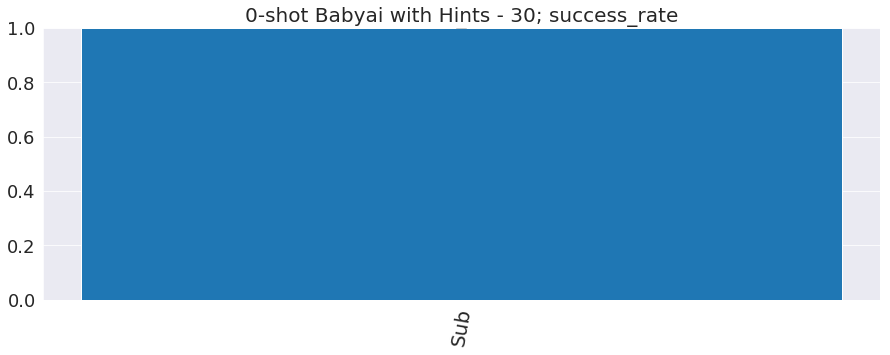

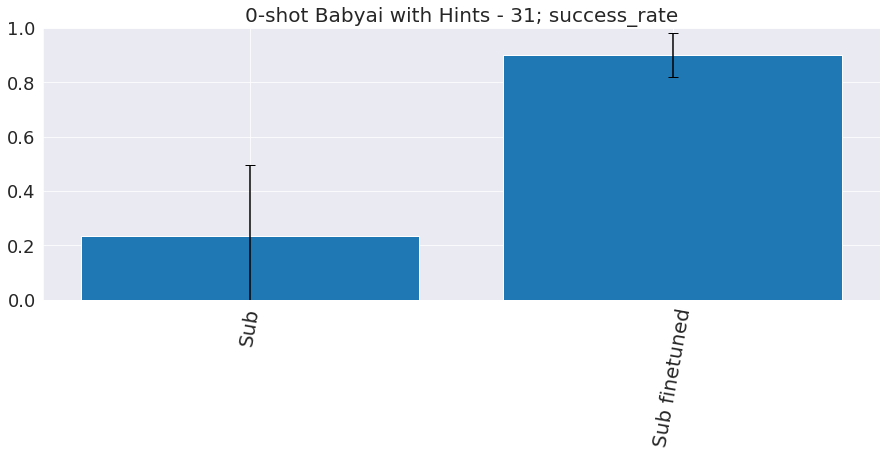

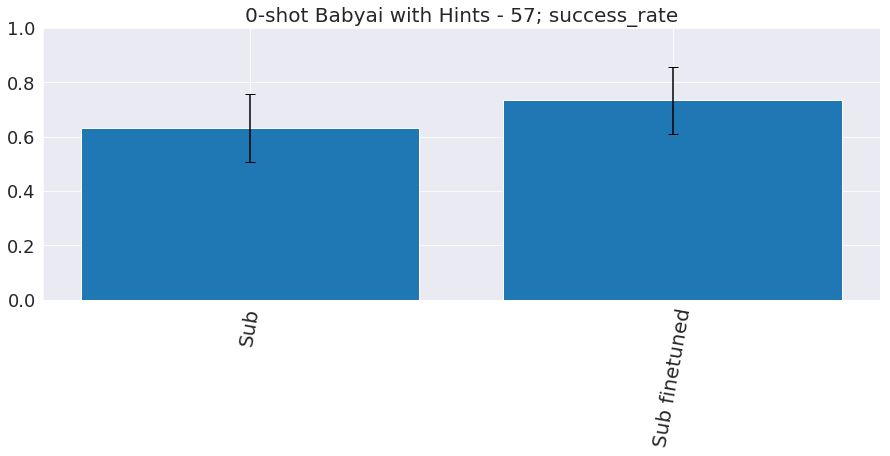

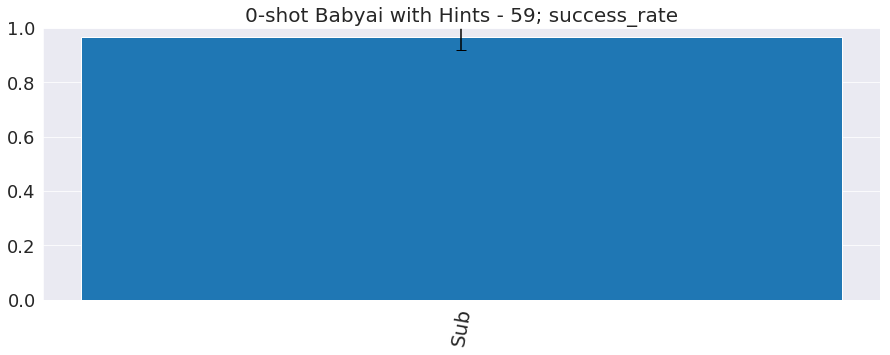

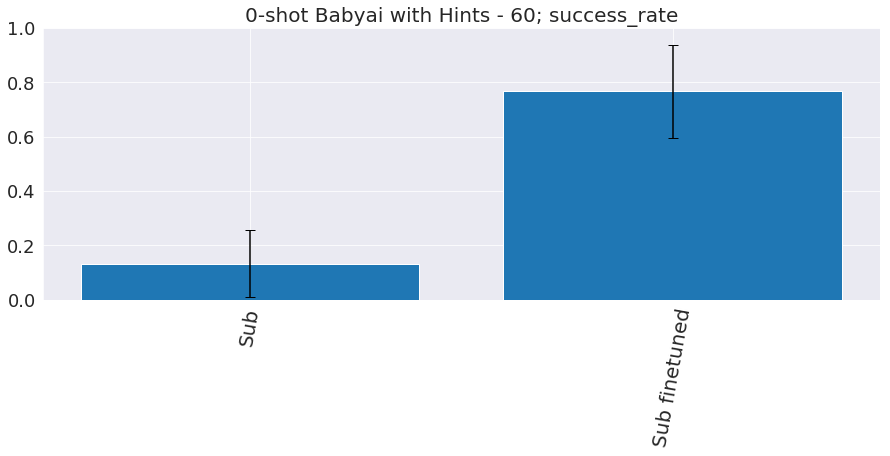

ENV DICT dict_keys([27, 28, 30, 31, 57, 59, 60])


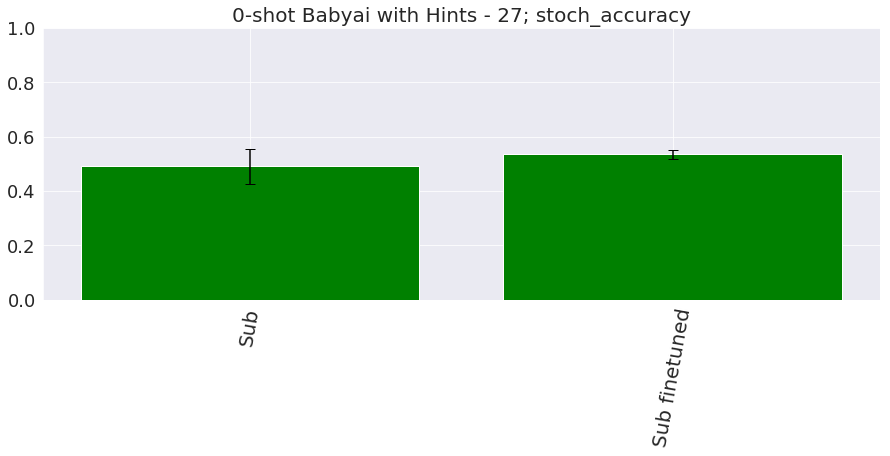

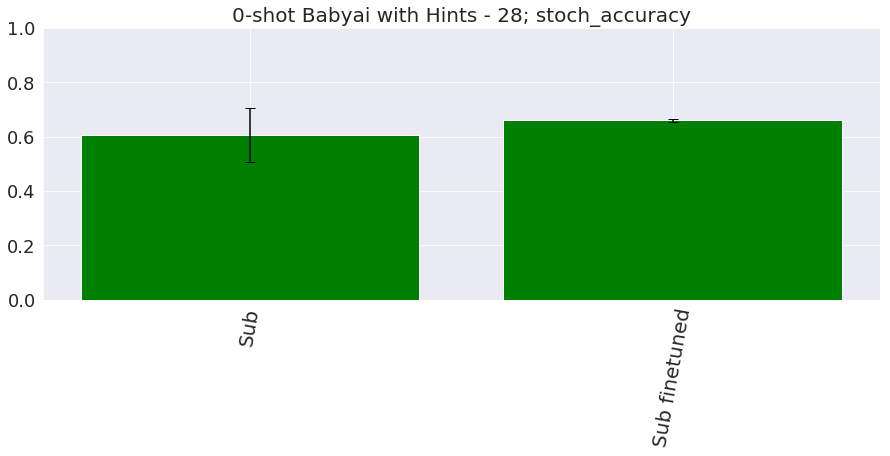

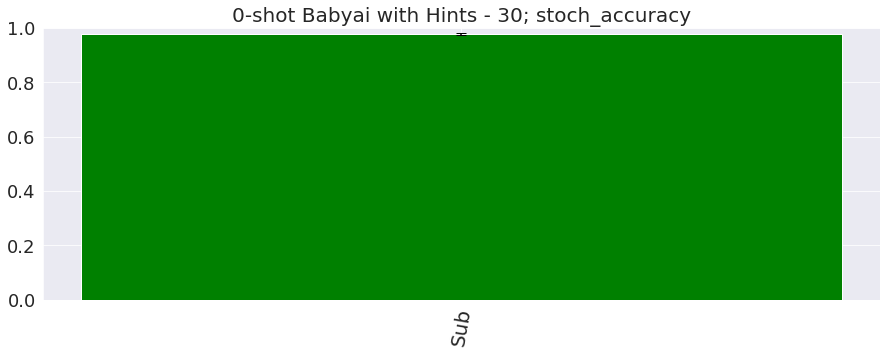

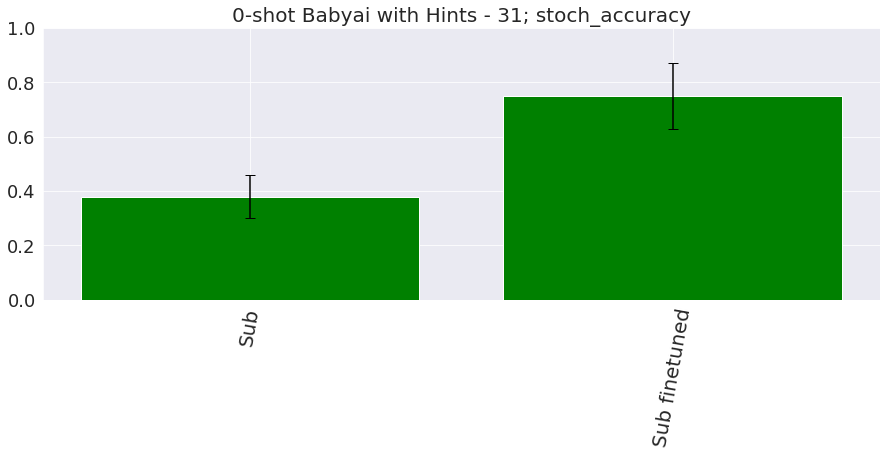

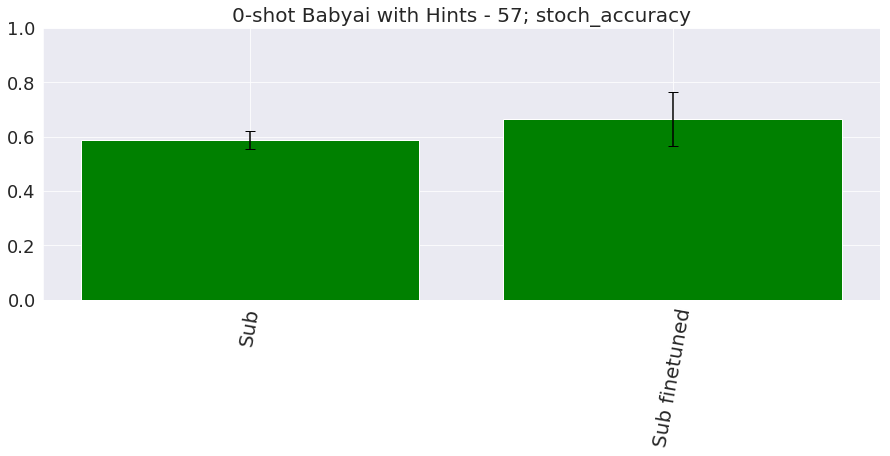

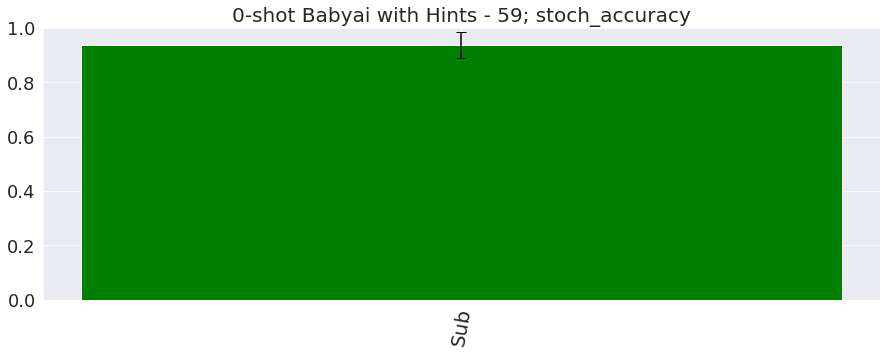

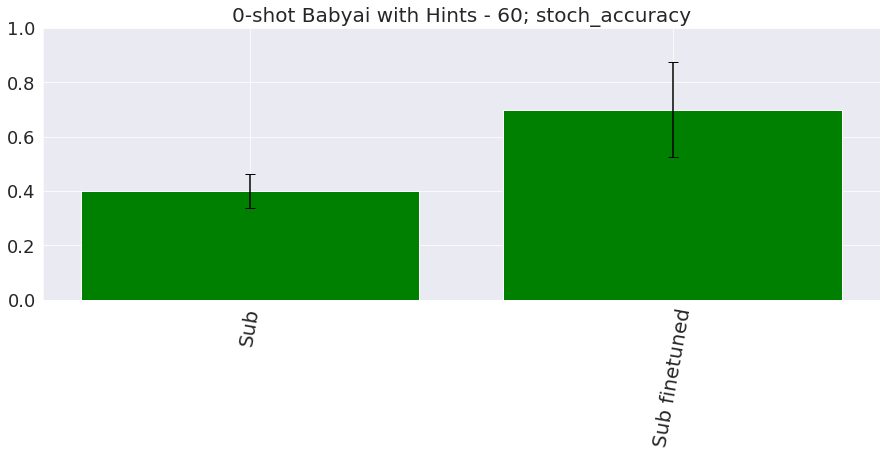

In [16]:
# NEw envs
runs = [
    (['M0486', 'M0487', 'M0488'], 'Sub'),
#     (['M0495', 'M0496', 'M0497'], 'Sub bootstrap PA'),
#     (['M0498', 'M0499', 'M0500'], 'Sub bootstrap OR'),
    (['M0513', 'M0514', 'M0515'], 'Sub finetuned'),
    (['M0516', 'M0517', 'M0518'], 'Sub finetuned'),
    (['M0522', 'M0523', 'M0524'], 'Sub finetuned'),
    (['M0624', 'M0625', 'M0626'], 'Sub finetuned'),
    (['M0630', 'M0631', 'M0632'], 'Sub finetuned'),
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot Babyai with Hints')
plot_final_generalization(runs, '0-shot Babyai with Hints', metric='stoch_accuracy')

In [17]:
# # Same as above, but limited buffer
# data_names = [
#         (['TT6100'], 'Oracle FixedKeyMedium', 1, 'red', None),
#         (['TT6101'], 'Oracle FixedKeyMedium 5k', 1, 'orange', None),
#         (['TT6102'], 'Oracle FixedKeyMedium 10k', 1, 'green', None),
# #     
#     ]

# smooth = 5
# x_unit = 'feedback'

# metric = 'success_rate'
# plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, 
#                              x_label=x_unit, new_logging=True)

# metric = 'stoch_accuracy'
# plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, 
#                              x_label=x_unit, new_logging=True)

In [18]:
# # Same as above, but limited buffer
# data_names = [
#         (['TT6100'], 'Oracle FixedKeyMedium', 1, 'red', None),
#         (['TT6101'], 'Oracle FixedKeyMedium 5k', 1, 'orange', None),
#         (['TT6102'], 'Oracle FixedKeyMedium 10k', 1, 'green', None),
# #     
#     ]

# smooth = 5
# x_unit = 'feedback'

# metric = 'success_rate'
# plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, 
#                              x_label=x_unit, new_logging=True)

# metric = 'stoch_accuracy'
# plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, 
#                              x_label=x_unit, new_logging=True)

In [19]:
# runs = [
# #     (['R0156', 'R0157', 'R0158'], 'PA'),
# #     (['R0206'], 'PA finetuned'), # looks good!
# #     (['R0159', 'R0160', 'R0161'], 'OSR'),
# #     (['R0162', 'R0163', 'R0164'], 'Sub'),
# #     (['R0180', 'R0181', 'R0182'], 'OSR bootstrap'),
# #     (['R0207', 'R0208', 'R0209'], 'OSR Finetuned'),
# #     (['R0183', 'R0184', 'R0185'], 'Sub bootstrap'),
# #     (['R0210', 'R0211', 'R0212'], 'Sub finetuned'),
# #     (['R0213', 'R0214', 'R0215'], 'Sub finetuned'),
# #     (['R0216', 'R0217', 'R0218'], 'Sub finetuned'),
# #     (['R0219', 'R0220', 'R0221'], 'Sub finetuned'),
# #     (['R0186', 'R0187'], 'Sub++ bootstrap'), # not used
# ]
# plt.rcParams['figure.figsize'] = [15, 5]
# plot_final_generalization(runs, '0-shot Babyai with Hints')
# plot_final_generalization(runs, '0-shot Babyai with Hints', metric='stoch_accuracy')

### Ant Training

In [20]:
# # x_unit = 'feedback'
# smooth = 200
# x_unit = 'feedback'

# data_names = [

    
#         (['R0384', 'R0385', 'R0386'], 'Direction Advice', 'red', None),
#         (['R0303', 'R0304', 'R0305'], 'Cardinal Advice', 'firebrick', None),
#         (['R0306', 'R0307', 'R0308'], 'Waypoint Advice', 'blue', None),
#         (['R0387', 'R0388', 'R0389'], 'OffsetWaypoint Advice', 'dodgerblue', None),
#         (['R0312', 'R0313', 'R0314'], 'No Advice', 'gray', None),
#     ]

# metrics = ['Train/Success']
# plot_curriculum(data_names, x_unit, 
#                 y=metrics, 
#                 smooth=global_smooth, error_bars=True, 
#                 title="Ant Mass Env - RL Training",
#                y_lower=0, y_upper=1, y_label="Success (with access to advice)",
#                save_name=None, x_max=1e7)

ENV NAME 6
X UNIT NAME itr
FEEDBACK PER TIMESTEP 800
X data [      0   16000   32000   48000   64000   80000   96000  112000  128000
  144000  160000  176000  192000  208000  224000  240000  256000  272000
  288000  304000  320000  336000  352000  368000  384000  400000  416000
  432000  448000  464000  480000  496000  512000  528000  544000  560000
  576000  592000  608000  624000  640000  656000  672000  688000  704000
  720000  736000  752000  768000  784000  800000  816000  832000  848000
  864000  880000  896000  912000  928000  944000  960000  976000  992000
 1000000]
X UNIT NAME itr
FEEDBACK PER TIMESTEP 800
X data [      0   16000   32000   48000   64000   80000   96000  112000  128000
  144000  160000  176000  192000  208000  224000  240000  256000  272000
  288000  304000  320000  336000  352000  368000  384000  400000  416000
  432000  448000  464000  480000  496000  512000  528000  544000  560000
  576000  592000  608000  624000  640000  656000  672000  688000  704000
  720

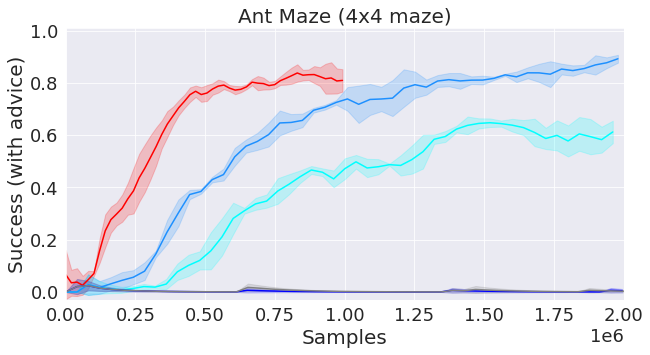

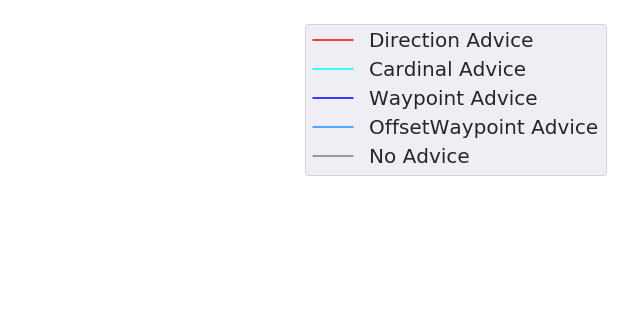

In [21]:
# TODO: this block is a repeat of the one below. DELETE!samples = False
samples = True

plt.rcParams['figure.figsize'] = [10, 5]

x_unit = 'Samples' if samples else 'feedback'
x_label = 'Samples' if samples else 'Advice Units'
x_max = 2e6 if samples else 1e7
all_multiplier = 40 * 20 if samples else 1
# 20 envs
# 40 is ???

smooth = 200


data_names = [    
        (['M0300', 'M0301', 'M0302'], 'Direction Advice', all_multiplier, 'red', None),
        (['M0303', 'M0304', 'M0305'], 'Cardinal Advice', all_multiplier, 'cyan', None),
        (['M0306', 'M0307', 'M0308'], 'Waypoint Advice', all_multiplier, 'blue', None),
        (['M0309', 'M0310', 'M0311'], 'OffsetWaypoint Advice', all_multiplier, 'dodgerblue', None),
        (['M0312', 'M0313', 'M0314'], 'No Advice', all_multiplier, 'gray', None),
    ]

# metrics = ['Train/Success']
# plot_curriculum(data_names, x_unit, 
#                 y=metrics, 
#                 smooth=smooth, error_bars=True, 
#                 title="Ant Mass Env - RL Training",
#                y_lower=-.01, y_upper=1, y_label="Success (with access to advice)",
#                save_name=None, x_max=1e7)

metric = 'success_rate'
plot_finetune_generalization(data_names, 'Ant Maze (4x4 maze)', metric=metric, smooth=global_smooth, 
                             x_label=x_label, x_max=x_max,
                             y_min=-.03,
                             save_name=f'rl_train_ant{"_samples" if samples else ""}.pdf',
                             y_label="Success (with advice)")


ENV NAME 6
X UNIT NAME itr
FEEDBACK PER TIMESTEP 4000
X data [      0   80000  160000  240000  320000  400000  480000  560000  640000
  720000  800000  880000  960000 1040000 1120000 1200000 1280000 1360000
 1440000 1520000 1600000 1680000 1760000 1840000 1920000 2000000 2080000
 2160000 2240000 2320000 2400000 2480000 2560000 2640000 2720000 2800000
 2880000 2960000 3040000 3120000 3200000 3280000 3360000 3440000 3520000
 3600000 3680000 3760000 3840000 3920000 4000000 4080000 4160000 4240000
 4320000 4400000 4480000 4560000 4640000 4720000 4800000 4880000 4960000
 5000000]
X UNIT NAME itr
FEEDBACK PER TIMESTEP 4000
X data [      0   80000  160000  240000  320000  400000  480000  560000  640000
  720000  800000  880000  960000 1040000 1120000 1200000 1280000 1360000
 1440000 1520000 1600000 1680000 1760000 1840000 1920000 2000000 2080000
 2160000 2240000 2320000 2400000 2480000 2560000 2640000 2720000 2800000
 2880000 2960000 3040000 3120000 3200000 3280000 3360000 3440000 3520000
 36

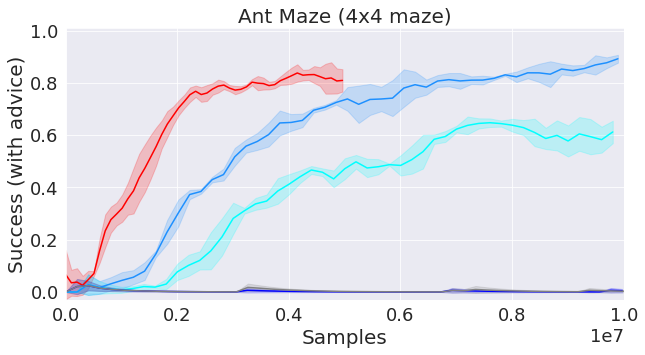

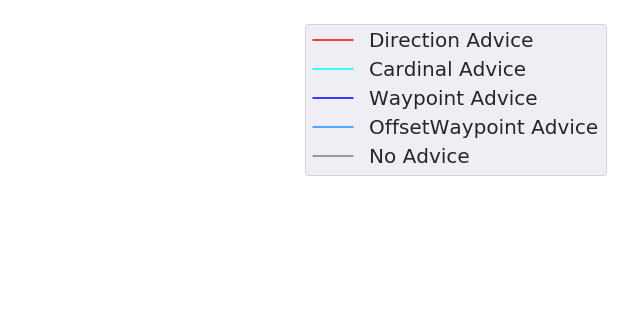

In [52]:
samples = True


plt.rcParams['figure.figsize'] = [10, 5]

x_unit = 'Samples' if samples else 'feedback'
x_label = 'Samples' if samples else 'Advice Units'
x_max = 1e7 if samples else 1e7
all_multiplier = 200 * 20 if samples else 1  # this should be feedback_per_timestep


smooth = 200


data_names = [    
        (['M0300', 'M0301', 'M0302'], 'Direction Advice', all_multiplier, 'red', None),
        (['M0303', 'M0304', 'M0305'], 'Cardinal Advice', all_multiplier, 'cyan', None),
        (['M0306', 'M0307', 'M0308'], 'Waypoint Advice', all_multiplier, 'blue', None),
        (['M0309', 'M0310', 'M0311'], 'OffsetWaypoint Advice', all_multiplier, 'dodgerblue', None),
        (['M0312', 'M0313', 'M0314'], 'No Advice', all_multiplier, 'gray', None),
    ]

# metrics = ['Train/Success']
# plot_curriculum(data_names, x_unit, 
#                 y=metrics, 
#                 smooth=smooth, error_bars=True, 
#                 title="Ant Mass Env - RL Training",
#                y_lower=-.01, y_upper=1, y_label="Success (with access to advice)",
#                save_name=None, x_max=1e7)

metric = 'success_rate'
plot_finetune_generalization(data_names, 'Ant Maze (4x4 maze)', metric=metric, smooth=global_smooth, 
                             x_label=x_label, x_max=x_max,
                             y_min=-.03,
                             save_name=f'rl_train_ant{"_samples" if samples else ""}.pdf',
                             y_label="Success (with advice)")

### Ant Zero-shot

ENV DICT dict_keys([0, 2])


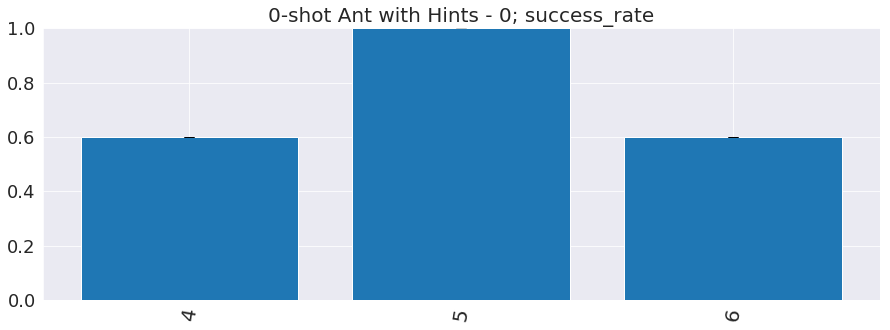

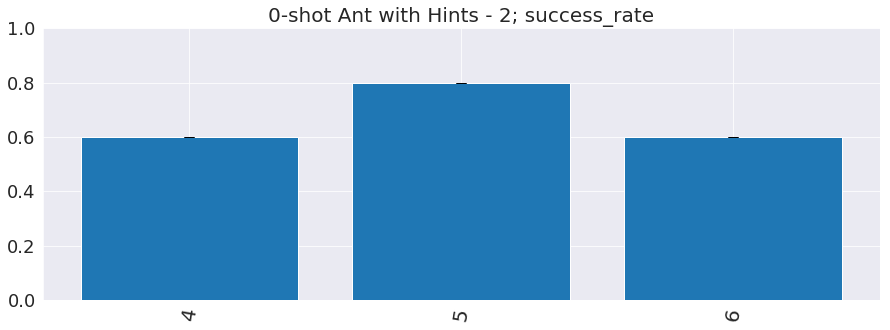

In [23]:
runs = [
#     (['T6134', 'T6135', 'T6136'], 'Direction'),
    (['T6134'], '4'),
    (['T6135', ], '5'),
    (['T6134', ], '6'),
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot Ant with Hints')

Error on  ['R0372', 'R0373', 'R0374'] [Errno 2] No such file or directory: 'logs/R0372/results.csv'
Error on  ['R0375', 'R0376', 'R0377'] [Errno 2] No such file or directory: 'logs/R0375/results.csv'
ENV DICT dict_keys([0, 2, 3, 6])


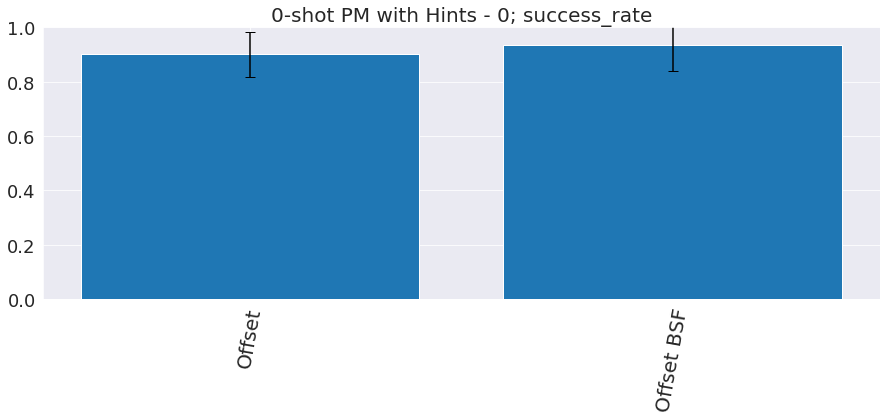

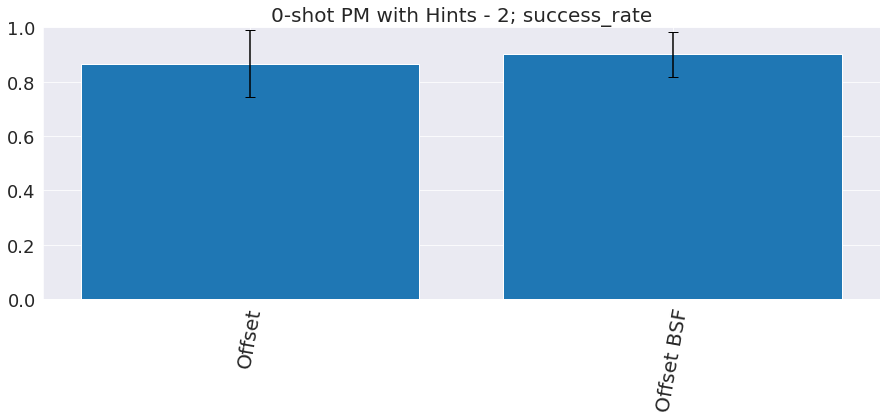

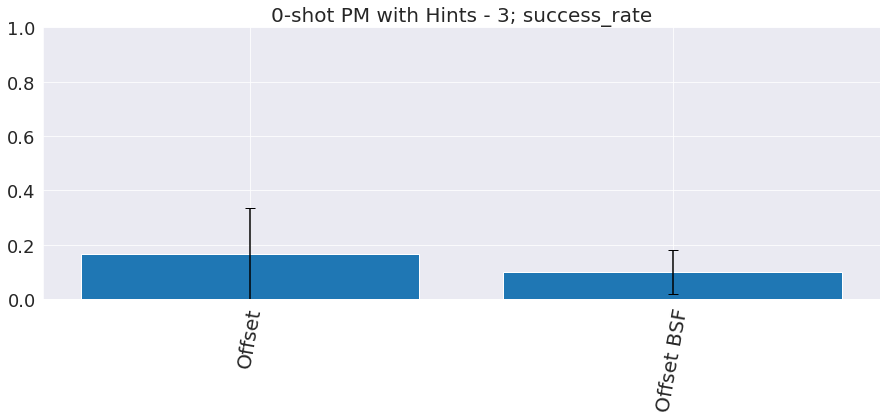

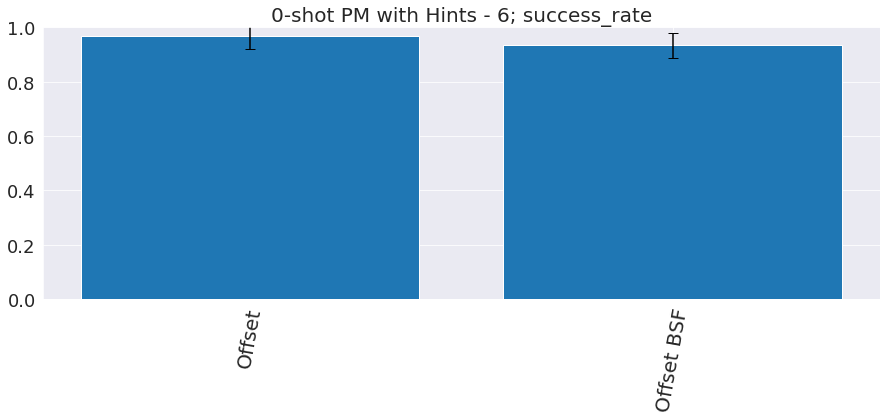

In [24]:
runs = [
    (['R0372', 'R0373', 'R0374'], 'Direction'),
    (['R0375', 'R0376', 'R0377'], 'Direction BSF'),
#     (['R0021', 'R0022', 'R0023'], 'Cardinal'),
#     (['R0042', 'R0043', 'R0044'], 'Cardinal ++'),
#     (['R0024', 'R0025', 'R0026'], 'Waypoint'),
#     (['R0036', 'R0037', 'R0038'], 'Waypoint ++'),
    (['R0378', 'R0379', 'R0380'], 'Offset'),
    (['R0381', 'R0382', 'R0383'], 'Offset BSF'),
#     (['R0030', 'R0031', 'R0032'], 'None'),
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot PM with Hints')

ENV DICT dict_keys([0, 2, 3, 6])


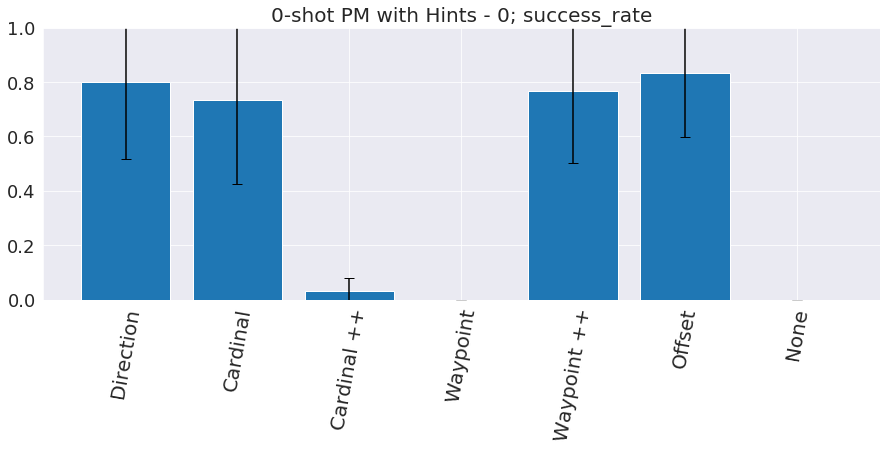

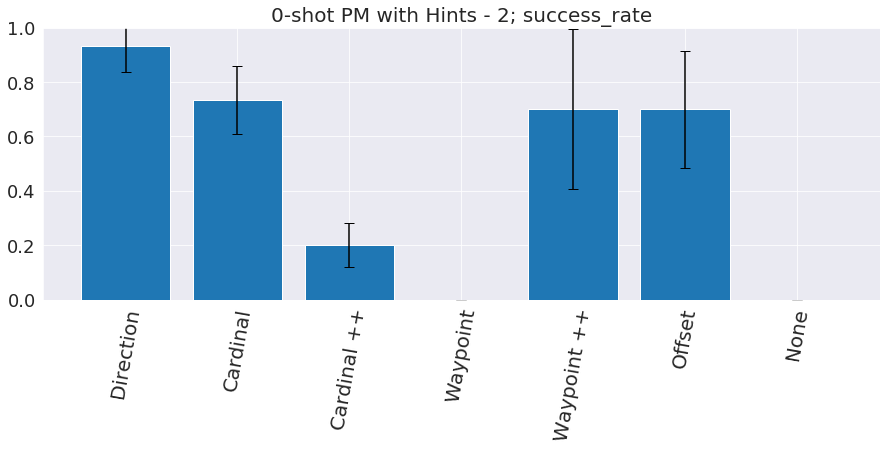

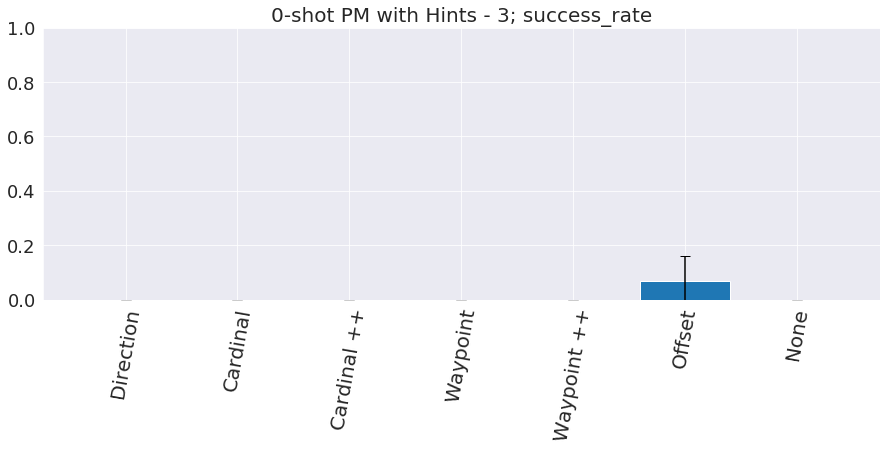

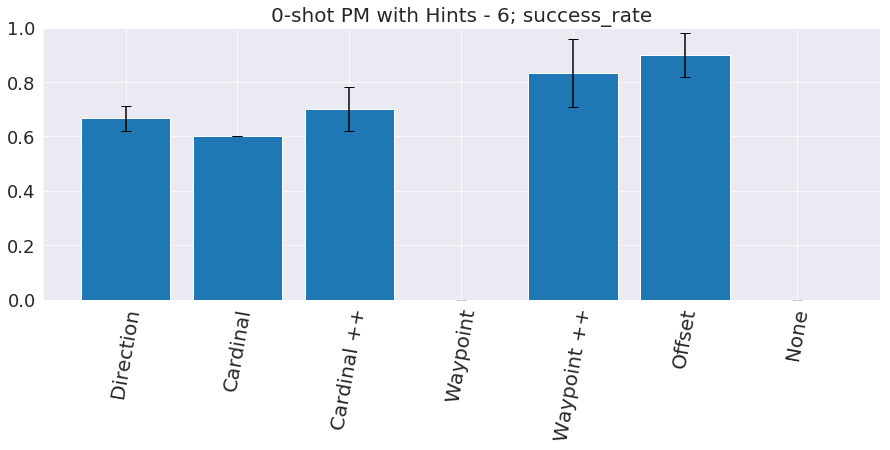

In [25]:
runs = [
    (['M0378', 'M0379', 'M0380'], 'Direction'),
    (['M0381', 'M0382', 'M0383'], 'Cardinal'),
    (['M0321', 'M0322', 'M0323'], 'Cardinal ++'),
    (['M0384', 'M0385', 'M0386'], 'Waypoint'),
    (['M0324', 'M0325', 'M0326'], 'Waypoint ++'),
    (['M0387', 'M0388', 'M0389'], 'Offset'),
    (['M0390', 'M0391', 'M0392'], 'None'),
    
    
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot PM with Hints')

## Bootstrapping

### Final

ENV NAME 4
lengths [4010640000, 4012232000, 4007516000]
ENV NAME 4
lengths [33317888000, 30308772000, 29064212000]


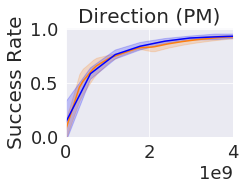

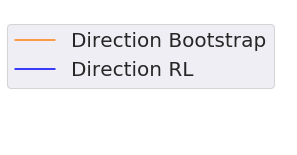

ENV NAME 4
lengths [3955692000, 3985956000, 3998232000]
ENV NAME 4
lengths [4217396000, 4337488000, 4427712000]


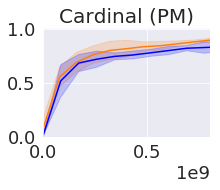

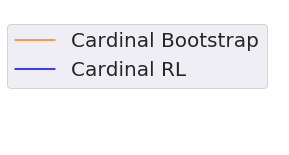

ENV NAME 4
lengths [3969120000, 3955512000, 3983368000]
ENV NAME 4
lengths [4603960000, 4638220000, 4729664000]


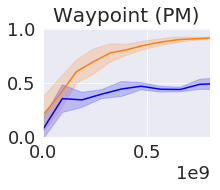

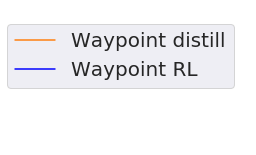

ENV NAME 6
lengths [18652000, 20128000, 18060000]
ENV NAME 6
lengths [9804000, 9820000, 9836000]


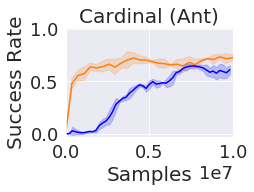

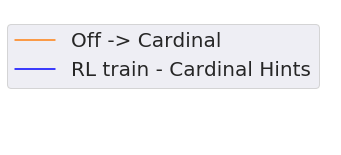

ENV NAME 6
lengths [20396000, 19896000, 19192000]
ENV NAME 6
lengths [9972000, 9972000, 9972000]


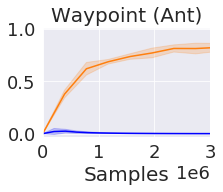

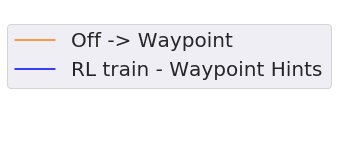

ENV NAME 25
lengths [13080000, 12760000, 12860000]
ENV NAME 25
lengths [900000, 896000, 900000]


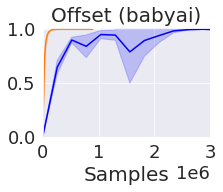

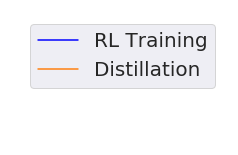

ENV NAME 25
lengths [13440000, 13020000, 14100000]
ENV NAME 25
lengths [2056000, 2000000, 1280000]


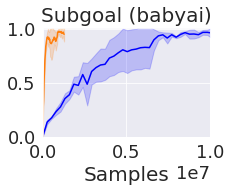

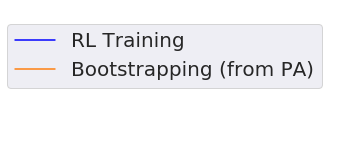

ENV NAME 6
lengths [2008440000, 2009648000, 2009652000]
ENV NAME 6
lengths [40000000000, 40000000000, 39680000000]


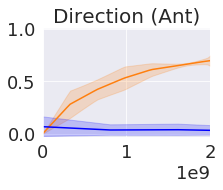

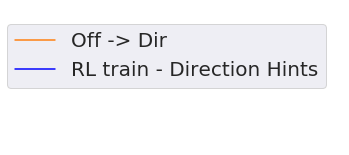

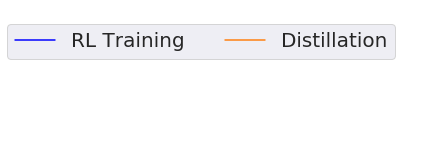

In [179]:
samples = True

plt.rcParams['figure.figsize'] = [3, 2]
metrics = [
    'Train/Success',
]
x_label = 'Samples' if samples else 'Advice'

outside_y_label = "Success Rate"
inside_y_label = ""
inside_x_label = ""
outside_x_label = 'Samples' if samples else 'Advice'
orange = '#ff7f0e'

all_multiplier = 200 * 20 if samples else 1


data_names = [
        (['M0045', 'M0046', 'M0047'], 'Direction Bootstrap', all_multiplier, orange, None), # 200 * 20 multiplier
        (['M0000', 'M0001', 'M0002'], 'Direction RL', all_multiplier,'blue', None), # 200 * 20 multiplier
    ]


x_max = 4e9 if samples else 1e6
plot_finetune_generalization(data_names, 'Direction (PM)', 
                             smooth=global_smooth, 
                             x_label=inside_x_label, 
                             y_label=outside_y_label, 
                             x_max=x_max, 
                             save_name=f'bootstrap_direction_pm{"_samples" if samples else ""}.pdf')

all_multiplier = 200 * 20 if samples else 1
data_names = [
        (['M0039', 'M0040', 'M0041'], 'Cardinal Bootstrap', all_multiplier, orange, None),
        (['M0003', 'M0004', 'M0005'], 'Cardinal RL', all_multiplier,'blue', None),
    ]


x_max = 8e8 if samples else 1e6
plot_finetune_generalization(data_names, 'Cardinal (PM)', 
                             smooth=global_smooth, 
                             x_label=inside_x_label, 
                             y_label=inside_y_label, 
                             x_max=x_max, 
                             save_name=f'bootstrap_cardinal_pm{"_samples" if samples else ""}.pdf')
all_multiplier = 200 * 20 if samples else 1

runs = [
        (['M0033', 'M0034', 'M0035'], 'Waypoint distill', all_multiplier, orange, None),
        (['M0006', 'M0007', 'M0008'], 'Waypoint RL', all_multiplier, 'blue', None),
    ]

x_max = 8e8 if samples else 1e6
plot_finetune_generalization(runs, 'Waypoint (PM)', 
                             smooth=global_smooth, 
                             x_label=inside_x_label, 
                             y_label=inside_y_label, 
                             x_max=x_max, 
                             save_name=f'bootstrap_waypoint_pm{"_samples" if samples else ""}.pdf', )





all_multiplier = 200 * 20 if samples else 1
runs = [
        (['M0315', 'M0316', 'M0317'], 'Off -> Cardinal', all_multiplier, orange, None),
        (['M0303', 'M0304', 'M0305'], 'RL train - Cardinal Hints', all_multiplier, 'blue', None),
]
if not samples:
    add_line(.65, 'Convergence (6e6)', color='blue', above=False)
x_max = 1e7 if samples else 5e5
plot_finetune_generalization(runs, 'Cardinal (Ant)', 
                             smooth=global_smooth, 
                             x_label=outside_x_label, 
                             y_label=outside_y_label,
                             y_min=-0.03, 
                             save_name=f'bootstrap_cardinal_ant{"_samples" if samples else ""}.pdf',
                             x_max=x_max, )

all_multiplier = 200 * 20 if samples else 1
runs = [
        (['M0318', 'M0319', 'M0320'], 'Off -> Waypoint', all_multiplier, orange, None),
        (['M0306', 'M0307', 'M0308'], 'RL train - Waypoint Hints', all_multiplier, 'blue', None),
]
if not samples:
    add_line(.06, 'Convergence (1e7)', color='blue')
x_max = 3e6 if samples else 5e5
plot_finetune_generalization(runs, 'Waypoint (Ant)', 
                             smooth=global_smooth, 
                             x_label=outside_x_label, 
                             y_label=inside_y_label,
                             y_min=-0.03, 
                             save_name=f'bootstrap_waypoint_ant{"_samples" if samples else ""}.pdf',
                             x_max=x_max, )

all_multiplier_rl = 100 * 10 if samples else 1
all_multiplier_distill = 40 * 5 if samples else 1
runs = [
        (['M0144', 'M0145', 'M0146'], 'RL Training', all_multiplier_rl, 'blue', None), # 100 * 10
        (['M0171', 'M0172', 'M0173'], 'Distillation', all_multiplier_distill, orange, None), # Probably 40 * 5
    ]
if not samples:
    x_max = 1e6 if samples else 1.5e6
plot_finetune_generalization(runs, 'Offset (babyai)', 
                             smooth=global_smooth, 
                             x_label=outside_x_label, 
                             metric='success_rate', 
                             y_label=inside_y_label, 
                             save_name=f'bootstrap_waypoint_babyai{"_samples" if samples else ""}.pdf', 
                             x_max=x_max, )


all_multiplier_rl = 100 * 10 if samples else 1
all_multiplier_distill = 40 * 5 if samples else 1
runs = [
        (['M0540', 'M0541', 'M0542'], 'RL Training', all_multiplier_rl, 'blue', None), # 100 * 10
        (['M0543', 'M0544', 'M0545'], 'Bootstrapping (from PA)', all_multiplier_distill, orange, None),
#         (['M0492', 'M0493', 'M0494'], 'Bootstrapping (from OSR)', all_multiplier, orange, None),
    ]
if not samples:
    add_line(.97, 'Convergence (1e7)', color='blue', above=False)
x_max = 1e7 if samples else 3e6
plot_finetune_generalization(runs, 'Subgoal (babyai)', 
                             smooth=global_smooth, 
                             x_label=outside_x_label, 
                             metric='success_rate', 
                             y_label=inside_y_label, 
                             save_name=f'bootstrap_subgoal_babyai{"_samples" if samples else ""}.pdf', 
                             x_max=x_max, )

all_multiplier = 200 * 20 if samples else 1
runs = [
        (['M0546', 'M0547', 'M0548'], 'Off -> Dir', all_multiplier, orange, None),
        (['M0300', 'M0301', 'M0302'], 'RL train - Direction Hints', all_multiplier, 'blue', None),
]
if not samples:
    add_line(.8, 'Convergence (2e10)', color='blue')
x_max = 2e9 if samples else 6e5
plot_finetune_generalization(runs, 'Direction (Ant)', 
                             smooth=global_smooth, 
                             x_label=inside_x_label, 
                             y_label=inside_y_label,
                             y_min=-0.03, 
                             save_name=f'bootstrap_direction_ant{"_samples" if samples else ""}.pdf',
                             x_max=x_max, )



lines = [mlines.Line2D([], [], c='blue', label='RL Training'),
         mlines.Line2D([], [], c=orange, label='Distillation')]
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=2)
plt.savefig('figs/bootstrap_legend.pdf', bbox_inches='tight')
plt.show()


In [99]:
data = load_run_data('M0069')
data.head()
# 


policy_env policy  env  success_rate  stoch_accuracy  itr  num_feedback  \
0  PolicyM0069-2  M0069    2           0.0             0.0    0             0   
1  PolicyM0069-2  M0069    2           0.0             0.0   20         16000   
2  PolicyM0069-2  M0069    2           0.6             0.0   40         32000   
3  PolicyM0069-2  M0069    2           0.6             0.0   60         48000   
4  PolicyM0069-2  M0069    2           0.6             0.0   80         64000   

         time    reward  
0   22.682487  0.002667  
1  186.339319  0.010667  
2  374.948665  0.021204  
3  551.824933  0.024497  
4  727.971436  0.028278

### PM

In [27]:
# x_unit = 'feedback'

# data_names = [
#         (['M0003', 'M0004', 'M0005'], 'Cardinal Advice', 1, 'orange', None),
#         (['M0006', 'M0007', 'M0008'], 'Waypoint Advice', 1, 'yellow', None),
    
    
#         (['M0039', 'M0040', 'M0041'], 'Cardinal Bootstrap', 1, 'orange', '*'),
#         (['M0033', 'M0034', 'M0035'], 'Waypoint Bootstrap', 1, 'yellow', '*'),
#     ]

# metric = 'success_rate'
# plot_finetune_generalization(data_names, 'PM', metric=metric, smooth=smooth, x_label=x_unit, 
#                              y_min=0, new_logging=True)

In [28]:
# x_unit = 'feedback'

# data_names = [
#         (['R0003', 'R0004', 'R0005'], 'Cardinal Advice', 1, 'orange', None),
#         (['R0006', 'R0007', 'R0008'], 'Waypoint Advice', 1, 'yellow', None),
    
    
#         (['R0039', 'R0040', 'R0041'], 'Cardinal Bootstrap', 1, 'orange', '*'),
#         (['R0033', 'R0034', 'R0035'], 'Waypoint Bootstrap', 1, 'yellow', '*'),
#     ]

# metric = 'success_rate'
# plot_finetune_generalization(data_names, 'PM', metric=metric, smooth=smooth, x_label=x_unit, y_min=0)

In [29]:
plt.rcParams['figure.figsize'] = [3, 2]
metrics = [
    'Train/Success',
]
x_label = 'Advice Units'

outside_y_label = "Success Rate"
inside_y_label = ""
inside_x_label = ""
outside_x_label = "Advice Units"

# data_names = [
#         (['R0000', 'R0001', 'R0002'], 'Direction Advice', 'red', None),
#         (['R0003', 'R0004', 'R0005'], 'Cardinal Advice', 'firebrick', None),
#         (['R0006', 'R0007', 'R0008'], 'Waypoint Advice', 'blue', None),
#         (['R0009', 'R0010', 'R0011'], 'OffsetWaypoint Advice', 'dodgerblue', None),
#         (['R0012', 'R0013', 'R0014'], 'No Advice', 'gray', None),
#     ]



# data_names = [
#         (['R0003', 'R0004', 'R0005'], 'Cardinal Advice', 1, 'orange', None),
#         (['R0039', 'R0040', 'R0041'], 'Cardinal Bootstrap', 1, 'orange', '*'),
#         (['R0003', 'R0004', 'R0005'], 'Cardinal Advice', 1,'blue', None),
#     ]

# plot_finetune_generalization(runs, 'Cardinal (PM)', smooth=10, x_label=inside_x_label, 
#                              y_label=inside_y_label, x_max=1000000, 
#                              save_name='bootstrap_cardinal_pm.pdf')

# plot_finetune_generalization(data_names, 'Cardinal (PM)', smooth=10, x_label=inside_x_label, 
#                              y_label=inside_y_label, 
#                              save_name='bootstrap_cardinal_pm.pdf')


# print("=" * 100)


# runs = [
#         (['K006', 'K007', 'K008'], 'RL training'),
#         (['K150', 'K151', 'K152'], 'Distillation', 1, '#ff7f0e', None),
#     ]

# plt.xlim(0, 250000)
# plot_finetune_generalization(runs, 'Waypoint (PM)', smooth=10, x_label=inside_x_label, 
#                              y_label=inside_y_label, x_max=250000, save_name='bootstrap_waypoint_pm.pdf')




# runs = [
#         (['K153', 'K154', 'K155'], 'RL train - Direction Hints'),
#         (['K168', 'K169', 'K170'], 'Off -> Dir', 1, '#ff7f0e', None),
# ]
# plt.xlim(0, 1500000)
# add_line(.92, 'RL Train at convergence (1.25e7)')
# plot_finetune_generalization(runs, 'Direction (Ant)', smooth=10, 
#                              x_label=inside_x_label, y_label=inside_y_label,
#                             y_min=-0.1, save_name='bootstrap_direction_ant.pdf',
#                             x_max=1500000)


# runs = [
#         (['K156', 'K157', 'K158'], 'RL train - Cardinal Hints'),
#         (['K171', 'K172', 'K173'], 'Off -> Cardinal', 1, '#ff7f0e', None),
# ]
# add_line(.84, 'RL Train at convergence (1.2e7)')
# plt.xlim(0, 50000)
# plot_finetune_generalization(runs, 'Cardinal (Ant)', smooth=10, 
#                              x_label=outside_x_label, y_label=outside_y_label,
#                             y_min=-0.1, save_name='bootstrap_cardinal_ant.pdf',
#                             x_max=50000)

# runs = [
#         (['K159', 'K160', 'K161'], 'RL train - Waypoint Hints'),
#         (['K174b', 'K175b', 'K176b'], 'Off -> Waypoint', 1, '#ff7f0e', None),
# ]
# plt.xlim(0, 100000)
# add_line(.02, 'RL Train at convergence (1e7)')
# plot_finetune_generalization(runs, 'Waypoint (Ant)', smooth=10, 
#                              x_label=outside_x_label, y_label=inside_y_label,
#                             y_min=-0.1, save_name='bootstrap_waypoint_ant.pdf',
#                             x_max=100000)



# # runs = [
# #         (['K333_1', 'K334', 'K335'], 'Action Advice', 'orange', 's'),
# #         (['K336', 'K337', 'K338'], 'OffsetWaypoint Advice', 'purple', 'v'),
# #         (['K339', 'K340', 'K341'], 'Subgoal Advice', 'brown', 'P'),



# x_label = 'Advice Units'

# runs = [
#         (['K336', 'K337', 'K338'], 'RL Training'),
#         (['K249b', 'K250b', 'K251b'], 'Distillation', 1, '#ff7f0e', None),
#     ]

# plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'OffsetWaypoint (babyai)', smooth=3, x_label=outside_x_label, 
#                              metric='success_rate', y_label=inside_y_label, 
#                              save_name='bootstrap_waypoint_babyai.pdf', x_max=1000000)


# runs = [
#         (['K339', 'K340', 'K341'], 'RL Training'),
#         (['K252c', 'K253c', 'K254c'], 'Bootstrapping', 1, '#ff7f0e', None),
#     ]

# plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Subgoal (babyai)', smooth=3, x_label=outside_x_label, 
#                              metric='success_rate', 
#                              y_label=inside_y_label, save_name='bootstrap_subgoal_babyai.pdf')


# lines = [mlines.Line2D([], [], label='RL Training'),
#          mlines.Line2D([], [], c='orange', label='Distillation')]
# plt.box(False)
# plt.axis('off')
# plt.legend(handles=lines, fontsize=20, ncol=2)
# plt.savefig('figs/bootstrap_legend.pdf', bbox_inches='tight')
# plt.show()


### BabyAI

In [30]:
# x_unit = 'feedback'
# smooth = 20


# data_names = [
#         (['M0144', 'M0145', 'M0146'], 'Offset Advice', 1, 'dodgerblue', None),
#         (['M0171', 'M0172', 'M0173'], 'OSR Bootstrap', 1, 'orange', None),
#     ]

# plot_finetune_generalization(data_names, 'BabyAI', metric='success_rate', smooth=smooth, x_label=x_unit, y_min=0,
#                             new_logging=True, x_max=6.5e6)
# # plot_finetune_generalization(data_names, 'BabyAI', metric='stoch_accuracy', smooth=smooth, x_label=x_unit, y_min=0,
# #                             new_logging=True, x_max=3e6)

In [31]:
# x_unit = 'feedback'
# smooth = 20


# data_names = [
#         (['M0147', 'M0148', 'M0149'], 'Subgoal Advice', 1, 'cyan', None),
#         (['M0177', 'M0178', 'M0179'], 'SUB Bootstrap OSR', 1, 'green', None),
#         (['M0174', 'M0175', 'M0176'], 'SUB Bootstrap from PA', 1, 'blue', None),
#         (['M0492', 'M0493', 'M0494'], 'New SUB Bootstrap OSR', 1, 'purple', None),
# #         (['M0489', 'M0490', 'M0491'], 'New SUB Bootstrap from PA', 1, 'pink', None),
#         (['M0543', 'M0544', 'M0545'], 'Newer SUB Bootstrap from PA', 1, 'lime', None),
#     ]

# plot_finetune_generalization(data_names, 'BabyAI', metric='success_rate', smooth=smooth, x_label=x_unit, y_min=0,
#                             new_logging=True, x_max=6.5e6)
# # plot_finetune_generalization(data_names, 'BabyAI', metric='stoch_accuracy', smooth=smooth, x_label=x_unit, y_min=0,
# #                             new_logging=True, x_max=3e6)

In [32]:
# x_unit = 'feedback'

# data_names = [
# #         (['R0144', 'R0145', 'R0146'], 'OSR Advice', 1, 'orange', None),
#         (['R0147', 'R0148', 'R0149'], 'SUB Advice', 1, 'cyan', None),
    
    
# #         (['R0171', 'R0172', 'R0173'], 'OSR Bootstrap', 1, 'orange', '*'),
#         (['R0177', 'R0178', ], 'SUB Bootstrap OSR', 1, 'green', None),
#         (['R0174', 'R0175', 'R0176'], 'SUB Bootstrap PA', 1, 'blue', None),
#     ]

# metric = 'success_rate'
# plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, x_label=x_unit, y_min=0)


### Ant

In [33]:
plt.rcParams['figure.figsize'] = [10, 5]

In [34]:
# x_unit = 'feedback'
# smooth=50

# data_names = [
#         (['R0315', 'R0316', 'R0317'], 'Cardinal Advice - Bootstrap', 1, 'orange', None),
#         (['R0318', 'R0319', 'R0320'], 'Waypoint Advice - Bootstrap', 1, 'yellow', None),
    
    
#         (['R0303', 'R0304', 'R0305'], 'Cardinal', 1, 'orange', '*'),
#         (['R0306', 'R0307', 'R0308'], 'Waypoint', 1, 'yellow', '*'),
#     ]

# metric = 'success_rate'
# plot_finetune_generalization(data_names, 'Ant', metric=metric, smooth=smooth, x_label=x_unit, x_max=1e6)

In [35]:
# x_unit = 'feedback'
# smooth=50
# format_plot()

# data_names = [
#         (['M0316'], 'Cardinal Advice - Bootstrap', 1, 'orange', None),
#         (['M0315', 'M0316', 'M0317'], 'Cardinal Advice - Bootstrap', 1, 'orange', None),
#         (['M0318', 'M0319', 'M0320'], 'Waypoint Advice - Bootstrap', 1, 'yellow', None),
    
#         (['M0303', 'M0304', 'M0305'], 'Cardinal', 1, 'orange', '*'),
#         (['M0306', 'M0307', 'M0308'], 'Waypoint', 1, 'yellow', '*'),
#     ]

# metric = 'success_rate'
# plot_finetune_generalization(data_names, 'Ant', metric=metric, smooth=smooth, x_label=x_unit, 
#                              x_max=1e6, new_logging=True)

## Distillation

In [36]:
plt.rcParams['figure.figsize'] = [10, 5]
direction_color = 'red'
cardinal_color = 'cyan'
waypoint_color = 'blue'
offset_color = 'dodgerblue'
rl_color = 'gray'
bc_color = 'black'
bc_bad_color = 'lime'
pa_color = 'red'
subgoal_color = 'cyan'

### PM

ENV NAME 2
X UNIT NAME num_feedback
FEEDBACK PER TIMESTEP 1
X data [      0   16000   32000   48000   64000   80000   96000  112000  128000
  144000  160000  176000  192000  208000  224000  240000  256000  272000
  288000  300000  300000  304000  320000  336000  352000  368000  384000
  400000  416000  432000  448000  464000  480000  496000  512000  528000
  544000  560000  576000  592000  608000  624000  640000  656000  672000
  688000  704000  720000  736000  752000  768000  784000  800000  816000
  832000  848000  864000  880000  896000  912000  928000  944000  960000
  976000  992000 1008000 1024000 1040000 1056000 1072000 1088000 1104000
 1120000 1136000 1152000 1168000 1184000 1200000]
X UNIT NAME num_feedback
FEEDBACK PER TIMESTEP 1
X data [      0   16000   32000   48000   64000   80000   96000  112000  128000
  144000  160000  176000  192000  208000  224000  240000  256000  272000
  288000  300000  300000  304000  320000  336000  352000  368000  384000
  400000  416000  432000

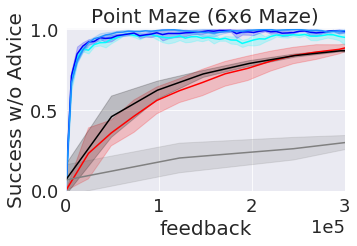

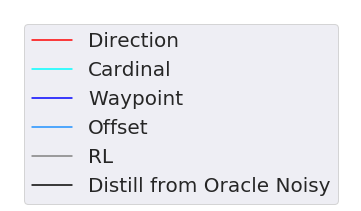

ENV NAME 3
X UNIT NAME num_feedback
FEEDBACK PER TIMESTEP 1
X data [      0   16000   32000   48000   64000   80000   96000  112000  128000
  144000  160000  176000  192000  208000  224000  240000  256000  272000
  288000  300000  300000  304000  320000  336000  352000  368000  384000
  400000  416000  432000  448000  464000  480000  496000  512000  528000
  544000  560000  576000  592000  608000  624000  640000  656000  672000
  688000  704000  720000  736000  752000  768000  784000  800000  816000
  832000  848000  864000  880000  896000  912000  928000  944000  960000
  976000  992000 1008000 1024000 1040000 1056000 1072000 1088000 1104000
 1120000 1136000 1152000 1168000 1184000 1200000]
X UNIT NAME num_feedback
FEEDBACK PER TIMESTEP 1
X data [      0   16000   32000   48000   64000   80000   96000  112000  128000
  144000  160000  176000  192000  208000  224000  240000  256000  272000
  288000  300000  300000  304000  320000  336000  352000  368000  384000
  400000  416000  432000

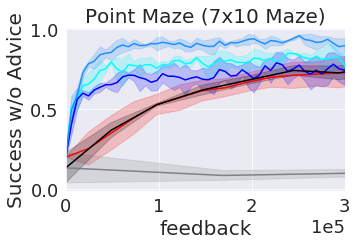

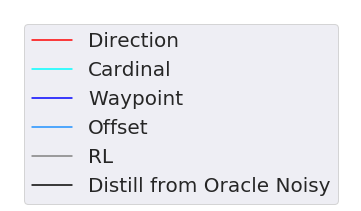

ENV NAME 13
X UNIT NAME num_feedback
FEEDBACK PER TIMESTEP 1
X data [      0   16000   32000   48000   64000   80000   96000  112000  128000
  144000  160000  176000  192000  208000  224000  240000  256000  272000
  288000  300000  304000  320000  336000  352000  368000  384000  400000
  416000  432000  448000  464000  480000  496000  512000  528000  544000
  560000  576000  592000  608000  624000  640000  656000  672000  688000
  704000  720000  736000  752000  768000  784000  800000  816000  832000
  848000  864000  880000  896000  912000  928000  944000  960000  976000
  992000 1008000 1024000 1040000 1056000 1072000 1088000 1104000 1120000
 1136000 1152000 1168000 1184000 1200000]
X UNIT NAME num_feedback
FEEDBACK PER TIMESTEP 1
X data [      0   16000   32000   48000   64000   80000   96000  112000  128000
  144000  160000  176000  192000  208000  224000  240000  256000  272000
  288000  300000  304000  320000  336000  352000  368000  384000  400000
  416000  432000  448000  46400

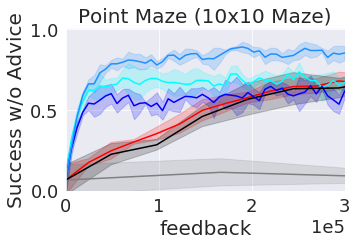

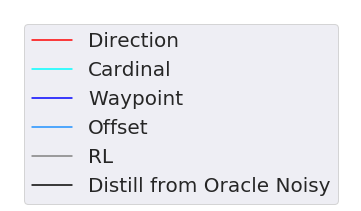

ENV NAME 14
X UNIT NAME num_feedback
FEEDBACK PER TIMESTEP 1
X data [      0   16000   32000   48000   64000   80000   96000  112000  128000
  144000  160000  176000  192000  208000  224000  240000  256000  272000
  288000  304000  320000  336000  352000  368000  384000  400000  416000
  432000  448000  464000  480000  496000  512000  528000  544000  560000
  576000  592000  608000  624000  640000  656000  672000  688000  704000
  720000  736000  752000  768000  784000  800000  816000  832000  848000
  864000  880000  896000  912000  928000  944000  960000  976000  992000
 1000000 1008000 1024000 1040000 1056000 1072000 1088000 1104000 1120000
 1136000 1152000 1168000 1184000 1200000 1216000 1232000 1248000 1264000
 1280000 1296000 1312000 1328000 1344000 1360000 1376000 1392000 1408000
 1424000 1440000 1456000 1472000 1488000 1504000 1520000 1536000 1552000
 1568000 1584000 1600000 1616000 1632000 1648000 1664000 1680000 1696000
 1712000 1728000 1744000 1760000 1776000 1792000 1808000

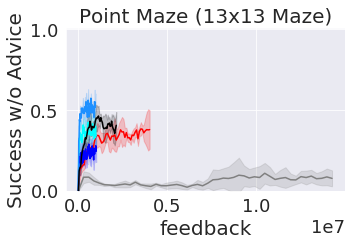

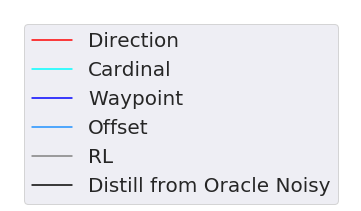

In [127]:
samples = False

x_unit = 'Samples' if samples else 'feedback'
x_label = 'Samples' if samples else 'Advice Units'


# plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.figsize'] = [5, 3]

metric = 'success_rate'


# These numbers come from frames_per_proc * num_envs for the corresponding experiments
# Oracle multiplier is used even when samples = False since there is no advice in the oracle case.
oracle_multiplier = 40 * 20
all_multiplier = 40 * 20 if samples else 1
rl_multiplier = 200 * 20 if samples else 1

# NOTE: we switched from using the original "distill with oracle" runs to the noisy runs, since adding noise
# improves rollout performance.

data_names = [
        (['M0069', 'M0070', 'M0071'], 'Direction', all_multiplier, direction_color, None),
        (['M0072', 'M0073', 'M0074'], 'Cardinal', all_multiplier, cardinal_color, None),
        (['M0075', 'M0076', 'M0077'], 'Waypoint', all_multiplier, waypoint_color, None),
        (['M0078', 'M0079', 'M0080'], 'Offset', all_multiplier, offset_color, None),
        (['M0081', 'M0082', 'M0083'], 'RL', rl_multiplier, rl_color, None),
        # (['M0084', 'M0085', 'M0086'], 'Distill from Oracle', multiplier, bc_bad_color, None),
        (['M0552', 'M0553', 'M0554'], 'Distill from Oracle Noisy', oracle_multiplier, bc_color, None),
    ]


x_max = 1e6 if samples else 3e5
plot_finetune_generalization(data_names, 'Point Maze (6x6 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=x_max, 
                             save_name=f'distill_pm_l2{"_samples" if samples else ""}.pdf', 
                             y_label="Success w/o Advice")

data_names = [
        (['M0087', 'M0088', 'M0089'], 'Direction', all_multiplier, direction_color, None),
        (['M0090', 'M0091', 'M0092'], 'Cardinal', all_multiplier, cardinal_color, None),
        (['M0093', 'M0094', 'M0095'], 'Waypoint', all_multiplier, waypoint_color, None),
        (['M0096', 'M0097', 'M0098'], 'Offset', all_multiplier, offset_color, None),
        (['M0099', 'M0100', 'M0101'], 'RL', rl_multiplier, rl_color, None),
#         (['M0102', 'M0103', 'M0104'], 'Distill from Oracle', multiplier, bc_bad_color, None),
        (['M0555', 'M0556', 'M0557'], 'Distill from Oracle Noisy', oracle_multiplier, bc_color, None),
    ]

x_max = 1.25e6 if samples else 3e5
plot_finetune_generalization(data_names, 'Point Maze (7x10 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=x_max, 
                             y_min=-.01, 
                             save_name=f'distill_pm_l3{"_samples" if samples else ""}.pdf', 
                             y_label="Success w/o Advice")


data_names = [
        (['M0105', 'M0106', 'M0107'], 'Direction', all_multiplier, direction_color, None),
        (['M0108', 'M0109', 'M0110'], 'Cardinal', all_multiplier, cardinal_color, None),
        (['M0111', 'M0112', 'M0113'], 'Waypoint', all_multiplier, waypoint_color, None),
        (['M0114', 'M0115', 'M0116'], 'Offset', all_multiplier, offset_color, None),
        (['M0117', 'M0118', 'M0119'], 'RL', rl_multiplier, rl_color, None),
#         (['M0120', 'M0121', 'M0122'], 'Distill from Oracle', multiplier, bc_bad_color, None),
        (['M0558', 'M0559', 'M0560'], 'Distill from Oracle Noisy', oracle_multiplier, bc_color, None),
    ]

x_max = 1.25e6 if samples else 3e5
plot_finetune_generalization(data_names, 'Point Maze (10x10 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=x_max, 
                             save_name=f'distill_pm_l13{"_samples" if samples else ""}.pdf', 
                             y_label="Success w/o Advice")


data_names = [
        (['M0123', 'M0124', 'M0125'], 'Direction', all_multiplier, direction_color, None),
        (['M0126', 'M0127', 'M0128'], 'Cardinal', all_multiplier, cardinal_color, None),
        (['M0129', 'M0130', 'M0131'], 'Waypoint', all_multiplier, waypoint_color, None),
        (['M0132', 'M0133', 'M0134'], 'Offset', all_multiplier, offset_color, None),
        (['M0135', 'M0136', 'M0137'], 'RL', rl_multiplier, rl_color, None),
#         (['M0138', 'M0139', 'M0140'], 'Distill from Oracle', multiplier, bc_bad_color, None),
        (['M0561', 'M0562', 'M0563'], 'Distill from Oracle Noisy', oracle_multiplier, bc_color, None),
    ]

x_max = 1.25e6 if samples else 3e5#1e6
plot_finetune_generalization(data_names, 'Point Maze (13x13 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
#                              x_max=x_max, 
                             save_name=None,#f'distill_pm_l14{"_samples" if samples else ""}.pdf', 
                             y_label="Success w/o Advice")



ENV NAME 2
lengths [300046, 300075, 300069]
FIRST 8 48987.102040816324 Offset
ENV NAME 2
lengths [6000000, 6000000, 6000000]
FIRST 36 4408163.265306123 RL
ENV NAME 2
lengths [2416000, 2480000, 2464000]
FIRST 37 1824326.530612245 Distill from Oracle Noisy


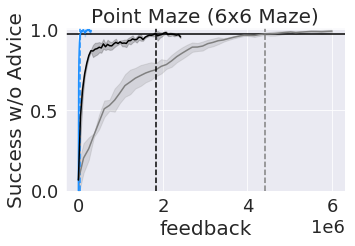

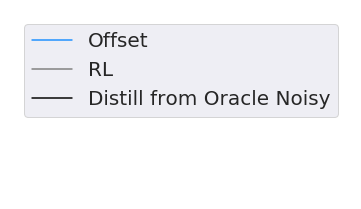

ENV NAME 3
lengths [300061, 300028, 300030]
FIRST 9 55107.18367346939 Offset
ENV NAME 3
lengths [8320000, 8480000, 8320000]
error with plotting vline index 0 is out of bounds for axis 0 with size 0
ENV NAME 3
lengths [2432000, 2432000, 2400000]
FIRST 21 1028571.4285714286 Distill from Oracle Noisy


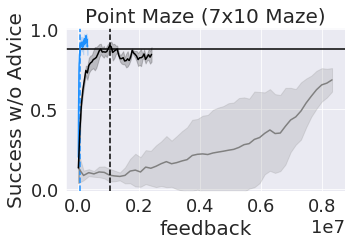

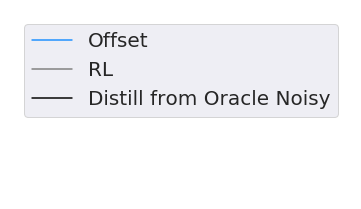

ENV NAME 13
lengths [300032, 300014, 300032]
FIRST 8 48981.87755102041 Offset
ENV NAME 13
lengths [8160000, 8160000, 8160000]
error with plotting vline index 0 is out of bounds for axis 0 with size 0
ENV NAME 13
lengths [2432000, 2400000, 2416000]
FIRST 14 685714.2857142858 Distill from Oracle Noisy


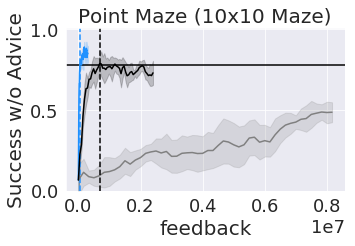

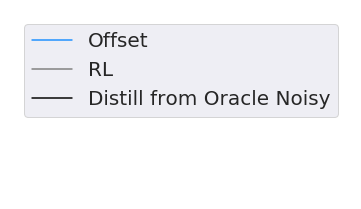

ENV NAME 14
lengths [1000026, 954412, 1000038]
FIRST 5 97388.97959183675 Offset
ENV NAME 14
lengths [14244000, 14564000, 14564000]
error with plotting vline index 0 is out of bounds for axis 0 with size 0
ENV NAME 14
lengths [2144000, 2144000, 2128000]
FIRST 25 1085714.2857142857 Distill from Oracle Noisy


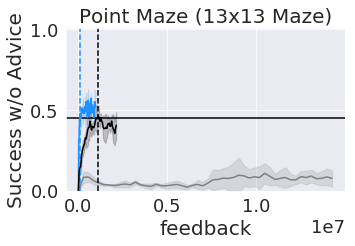

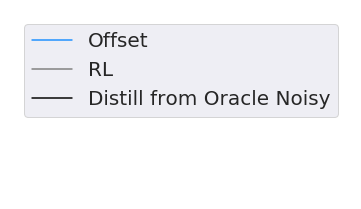

In [159]:
samples = False

x_unit = 'Samples' if samples else 'feedback'
x_label = 'Samples' if samples else 'Advice Units'


# plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.figsize'] = [5, 3]

metric = 'success_rate'


# These numbers come from frames_per_proc * num_envs for the corresponding experiments
# Oracle multiplier is used even when samples = False since there is no advice in the oracle case.
oracle_multiplier = 40 * 20
all_multiplier = 40 * 20 if samples else 1
rl_multiplier = 200 * 20 if samples else 1

# NOTE: we switched from using the original "distill with oracle" runs to the noisy runs, since adding noise
# improves rollout performance.

data_names = [
        # (['M0069', 'M0070', 'M0071'], 'Direction', all_multiplier, direction_color, None),
        # (['M0072', 'M0073', 'M0074'], 'Cardinal', all_multiplier, cardinal_color, None),
        # (['M0075', 'M0076', 'M0077'], 'Waypoint', all_multiplier, waypoint_color, None),
        (['M0078', 'M0079', 'M0080'], 'Offset', all_multiplier, offset_color, None),
        (['M0081', 'M0082', 'M0083'], 'RL', rl_multiplier, rl_color, None),
        # (['M0084', 'M0085', 'M0086'], 'Distill from Oracle', multiplier, bc_bad_color, None),
        (['M0552', 'M0553', 'M0554'], 'Distill from Oracle Noisy', oracle_multiplier, bc_color, None),
    ]


x_max = 1e6 if samples else 3e5

plot_convergence_marker(data_names, 'Point Maze (6x6 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                            #  x_max=x_max, 
                             y_label="Success w/o Advice",
                             convergence_val=.97)

data_names = [
        # (['M0087', 'M0088', 'M0089'], 'Direction', all_multiplier, direction_color, None),
        # (['M0090', 'M0091', 'M0092'], 'Cardinal', all_multiplier, cardinal_color, None),
        # (['M0093', 'M0094', 'M0095'], 'Waypoint', all_multiplier, waypoint_color, None),
        (['M0096', 'M0097', 'M0098'], 'Offset', all_multiplier, offset_color, None),
        (['M0099', 'M0100', 'M0101'], 'RL', rl_multiplier, rl_color, None),
#         (['M0102', 'M0103', 'M0104'], 'Distill from Oracle', multiplier, bc_bad_color, None),
        (['M0555', 'M0556', 'M0557'], 'Distill from Oracle Noisy', oracle_multiplier, bc_color, None),
    ]

x_max = 1.25e6 if samples else 3e5
plot_convergence_marker(data_names, 'Point Maze (7x10 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                            #  x_max=x_max, 
                             y_min=-.01, 
                             y_label="Success w/o Advice",
                             convergence_val=.88)


data_names = [
        # (['M0105', 'M0106', 'M0107'], 'Direction', all_multiplier, direction_color, None),
        # (['M0108', 'M0109', 'M0110'], 'Cardinal', all_multiplier, cardinal_color, None),
        # (['M0111', 'M0112', 'M0113'], 'Waypoint', all_multiplier, waypoint_color, None),
        (['M0114', 'M0115', 'M0116'], 'Offset', all_multiplier, offset_color, None),
        (['M0117', 'M0118', 'M0119'], 'RL', rl_multiplier, rl_color, None),
#         (['M0120', 'M0121', 'M0122'], 'Distill from Oracle', multiplier, bc_bad_color, None),
        (['M0558', 'M0559', 'M0560'], 'Distill from Oracle Noisy', oracle_multiplier, bc_color, None),
    ]

x_max = 1.25e6 if samples else 3e5
plot_convergence_marker(data_names, 'Point Maze (10x10 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                            #  x_max=x_max, 
                             y_label="Success w/o Advice",
                             convergence_val=.78)


data_names = [
        # (['M0123', 'M0124', 'M0125'], 'Direction', all_multiplier, direction_color, None),
        # (['M0126', 'M0127', 'M0128'], 'Cardinal', all_multiplier, cardinal_color, None),
        # (['M0129', 'M0130', 'M0131'], 'Waypoint', all_multiplier, waypoint_color, None),
        (['M0132', 'M0133', 'M0134'], 'Offset', all_multiplier, offset_color, None),
        (['M0135', 'M0136', 'M0137'], 'RL', rl_multiplier, rl_color, None),
#         (['M0138', 'M0139', 'M0140'], 'Distill from Oracle', multiplier, bc_bad_color, None),
        (['M0561', 'M0562', 'M0563'], 'Distill from Oracle Noisy', oracle_multiplier, bc_color, None),
    ]

x_max = 1.25e6 if samples else 3e5#1e6
plot_convergence_marker(data_names, 'Point Maze (13x13 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
#                              x_max=x_max, 
                             y_label="Success w/o Advice",
                             convergence_val=.45)



In [125]:
samples = False

x_unit = 'Samples' if samples else 'feedback'
x_label = 'Samples' if samples else 'Advice Units'


plt.rcParams['figure.figsize'] = [10, 5]

metric = 'success_rate'

oracle_multiplier = 40 * 20
all_multiplier = 40 * 20 if samples else 1
rl_multiplier = 200 * 20 if samples else 1


l2_name = '6x6 Maze'
l3_name = '7x10 Maze'
l13_name = '10x10 Maze'
l14_name = '13x13 Maze'

data_names = [
    # L2
        (['M0069', 'M0070', 'M0071'], (l2_name, 'Direction'), all_multiplier, direction_color, False),
        (['M0072', 'M0073', 'M0074'], (l2_name, 'Cardinal'), all_multiplier, cardinal_color, False),
        (['M0075', 'M0076', 'M0077'], (l2_name, 'Waypoint'), all_multiplier, waypoint_color, False),
        (['M0078', 'M0079', 'M0080'], (l2_name, 'Offset'), all_multiplier, offset_color, False),
        (['M0081', 'M0082', 'M0083'], (l2_name, 'RL'), rl_multiplier, rl_color, False),
        (['M0552', 'M0553', 'M0554'], (l2_name, 'Oracle'), oracle_multiplier, bc_color, True),

    # L3
        (['M0087', 'M0088', 'M0089'], (l3_name, 'Direction'), all_multiplier, direction_color, False),
        (['M0090', 'M0091', 'M0092'], (l3_name, 'Cardinal'), all_multiplier, cardinal_color, False),
        (['M0093', 'M0094', 'M0095'], (l3_name, 'Waypoint'), all_multiplier, waypoint_color, False),
        (['M0096', 'M0097', 'M0098'], (l3_name, 'Offset'), all_multiplier, offset_color, False),
        (['M0099', 'M0100', 'M0101'], (l3_name, 'RL'), rl_multiplier, rl_color, False),
        (['M0555', 'M0556', 'M0557'], (l3_name, 'Oracle'), oracle_multiplier, bc_color, True),

    # L13
        (['M0105', 'M0106', 'M0107'], (l13_name, 'Direction'), all_multiplier, direction_color, False),
        (['M0108', 'M0109', 'M0110'], (l13_name, 'Cardinal'), all_multiplier, cardinal_color, False),
        (['M0111', 'M0112', 'M0113'], (l13_name, 'Waypoint'), all_multiplier, waypoint_color, False),
        (['M0114', 'M0115', 'M0116'], (l13_name, 'Offset'), all_multiplier, offset_color, False),
        (['M0117', 'M0118', 'M0119'], (l13_name, 'RL'), rl_multiplier, rl_color, False),
        (['M0558', 'M0559', 'M0560'], (l13_name, 'Oracle'), oracle_multiplier, bc_color, True),

    # L14
        (['M0123', 'M0124', 'M0125'], (l14_name, 'Direction'), all_multiplier, direction_color, False),
        (['M0126', 'M0127', 'M0128'], (l14_name, 'Cardinal'), all_multiplier, cardinal_color, False),
        (['M0129', 'M0130', 'M0131'], (l14_name, 'Waypoint'), all_multiplier, waypoint_color, False),
        (['M0132', 'M0133', 'M0134'], (l14_name, 'Offset'), all_multiplier, offset_color, False),
        (['M0135', 'M0136', 'M0137'], (l14_name, 'RL'), rl_multiplier, rl_color, False),
        (['M0561', 'M0562', 'M0563'], (l14_name, 'Oracle'), oracle_multiplier, bc_color, True),
]

df = make_table(data_names, 'Point Maze Env', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_metric=x_unit, 
                             x_eval=3e5,
                             plot_latex=True,
                             transpose=False)



ENV NAME 2
X UNIT NAME num_feedback
FEEDBACK PER TIMESTEP 1
X data [      0   16000   32000   48000   64000   80000   96000  112000  128000
  144000  160000  176000  192000  208000  224000  240000  256000  272000
  288000  300000  300000  304000  320000  336000  352000  368000  384000
  400000  416000  432000  448000  464000  480000  496000  512000  528000
  544000  560000  576000  592000  608000  624000  640000  656000  672000
  688000  704000  720000  736000  752000  768000  784000  800000  816000
  832000  848000  864000  880000  896000  912000  928000  944000  960000
  976000  992000 1008000 1024000 1040000 1056000 1072000 1088000 1104000
 1120000 1136000 1152000 1168000 1184000 1200000]
X UNIT NAME num_feedback
FEEDBACK PER TIMESTEP 1
X data [      0   16000   32000   48000   64000   80000   96000  112000  128000
  144000  160000  176000  192000  208000  224000  240000  256000  272000
  288000  300000  300000  304000  320000  336000  352000  368000  384000
  400000  416000  432000

In [39]:
data = df.to_numpy()
for row in data:
    vals = []
    max_mean = 0
    max_std = 0
    for point in row:
        mean = float(point[1:point.index(' \\')])
        std = float(point[point.index('m') + 2:-1])
        if mean > max_mean:
            max_mean = mean
            max_std = std
        vals.append((mean, std))
    for mean, std in vals:
        if mean + std >= max_mean - std:
            print('yes', mean, std)
        else:
            print('no', mean, std)
    print("==========")
            
        

ValueError: could not convert string to float: 

In [ ]:
# x_unit = 'feedback'
# metric = 'success_rate'
# smooth=50

# data_names = [
#         (['R0069', 'R0070', 'R0071'], 'Direction', 1, 'red', None),
#         (['R0072', 'R0073', 'R0074'], 'Cardinal', 1, 'orange', None),
#         (['R0075', 'R0076', 'R0077'], 'Waypoint', 1, 'yellow', None), # TODO: check Tues
#         (['R0078', 'R0079', 'R0080'], 'Offset', 1, 'green', None),  # TODO: stop Tues morn
#         (['R0081', 'R0082', 'R0083'], 'RL', 1, 'blue', None),
#         (['R0084', 'R0085', 'R0086'], 'Distill from Oracle', 100 * 20, 'purple', None),
#     ]


# plot_finetune_generalization(data_names, 'PM - L2', metric=metric, smooth=smooth, 
#                              x_label=x_unit, x_max=3e5)

# data_names = [
#         (['R0087', 'R0088', 'R0089'], 'Direction', 1, 'red', None),
#         (['R0090', 'R0091', 'R0092'], 'Cardinal', 1, 'orange', None),
#         (['R0093', 'R0094', 'R0095'], 'Waypoint', 1, 'yellow', None),
#         (['R0096', 'R0097', 'R0098'], 'Offset', 1, 'green', None),
#         (['R0099', 'R0100', 'R0101'], 'RL', 1, 'blue', None),
#         (['R0102', 'R0103', 'R0104'], 'Distill from Oracle', 100 * 20, 'purple', None),
#     ]

# plot_finetune_generalization(data_names, 'PM - L3', metric=metric, smooth=smooth, x_label=x_unit, x_max=3e5, y_min=-.01)


# data_names = [
#         (['R0105', 'R0106', 'R0107'], 'Direction', 1, 'red', None),
#         (['R0108', 'R0109', 'R0110'], 'Cardinal', 1, 'orange', None),
#         (['R0111', 'R0112', 'R0113'], 'Waypoint', 1, 'yellow', None),
#         (['R0114', 'R0115', 'R0116'], 'Offset', 1, 'green', None),
#         (['R0117', 'R0118', 'R0119'], 'RL', 1, 'blue', None),
#         (['R0120', 'R0121', 'R0122'], 'Distill from Oracle', 100 * 20, 'purple', None),
#     ]

# plot_finetune_generalization(data_names, 'PM - L13', metric=metric, smooth=smooth, x_label=x_unit, x_max=3e5)


# data_names = [
#         (['R0123', 'R0124', 'R0125'], 'Direction', 1, 'red', None),
#         (['R0126', 'R0127', 'R0128'], 'Cardinal', 1, 'orange', None),
#         (['R0129', 'R0130', 'R0131'], 'Waypoint', 1, 'yellow', None),
#         (['R0132', 'R0133', 'R0134'], 'Offset', 1, 'green', None),
#         (['R0135', 'R0136', 'R0137'], 'RL', 1, 'blue', None),
#         (['R0138', 'R0139', 'R0140'], 'Distill from Oracle', 100 * 20, 'purple', None),
#     ]

# plot_finetune_generalization(data_names, 'PM - L14', metric=metric, smooth=smooth, x_label=x_unit, x_max=1e6)

### BabyAI

ENV NAME 59
lengths [900000, 885000, 900000]
ENV NAME 59
lengths [1442250, 1443000, 1432500]
ENV NAME 59
lengths [3746250, 3109500, 3592500]
ENV NAME 59
lengths [6500000, 6520000, 6600000]
ENV NAME 59
lengths [1874250, 1874250, 1874250]


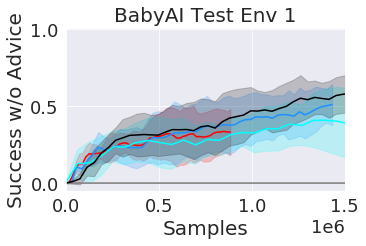

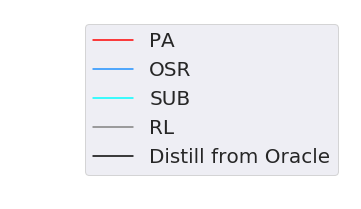

ENV NAME 28
lengths [1000500, 1000500, 1000500]
ENV NAME 28
lengths [1485000, 1500000, 1515000]
ENV NAME 28
lengths [10524750, 9942000, 10132500]
ENV NAME 28
lengths [7120000, 7440000, 7220000]
ENV NAME 28
lengths [2070000, 2055000, 2085000]


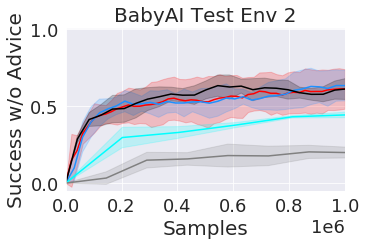

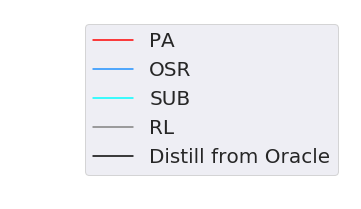

ENV NAME 27
lengths [930000, 870000, 885000]
ENV NAME 27
lengths [2565000, 2490000, 2385000]
ENV NAME 27
lengths [31215000, 31230000, 31650000]
ENV NAME 27
lengths [580000, 580000, 580000]
ENV NAME 27
lengths [3045000, 2955000, 3075000]


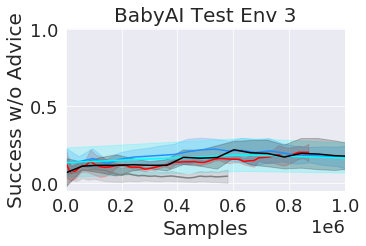

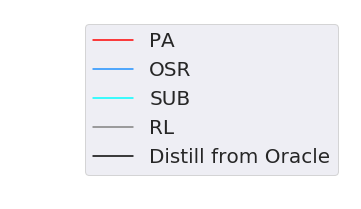

ENV NAME 30
lengths [800250, 800250, 800250]
ENV NAME 30
lengths [2298750, 2310750, 2290500]
ENV NAME 30
lengths [4860000, 4980000, 5745750]
ENV NAME 30
lengths [6860000, 6820000, 6800000]
ENV NAME 30
lengths [3060000, 3060000, 3060000]


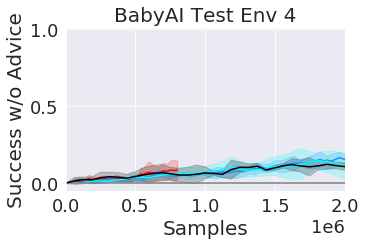

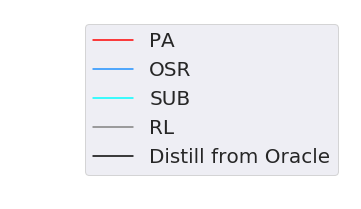

ENV NAME 31
lengths [500250, 500250, 500250]
ENV NAME 31
lengths [1230000, 1425000, 1215000]
ENV NAME 31
lengths [5211750, 4907250, 4957500]
ENV NAME 31
lengths [500000, 500000, 500000]
ENV NAME 31
lengths [1860000, 1860000, 1860000]


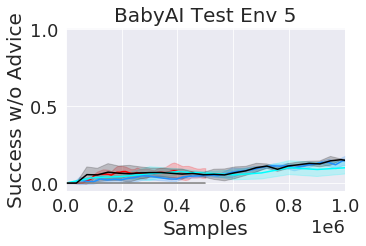

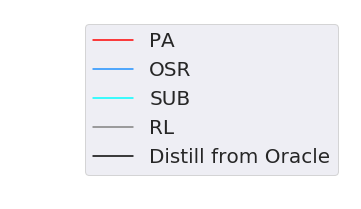

ENV NAME 57
lengths [500250, 500250, 500250]
ENV NAME 57
lengths [1384500, 1455000, 1443000]
ENV NAME 57
lengths [13687500, 12759750, 12840000]
ENV NAME 57
lengths [26600000, 500000, 28220000]
ENV NAME 57
lengths [2249250, 2249250, 2249250]


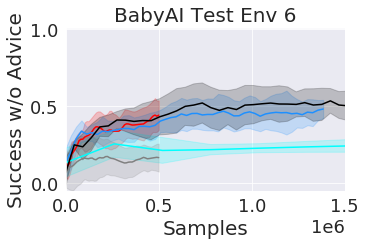

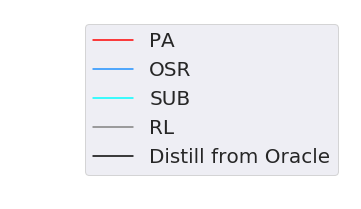

ENV NAME 60
lengths [500250, 500250, 500250]
ENV NAME 60
lengths [1283250, 1387500, 1340250]
ENV NAME 60
lengths [5547000, 6214500, 4443750]
ENV NAME 60
lengths [1520000, 1700000, 1500000]
ENV NAME 60
lengths [1874250, 1874250, 1874250]


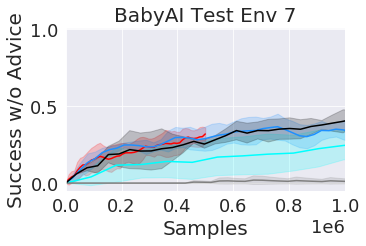

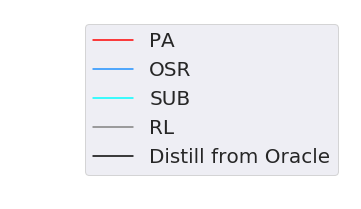

In [175]:
samples = True

x_unit = 'Samples' if samples else 'feedback'
x_label = 'Samples' if samples else 'Advice Units'

plt.rcParams['figure.figsize'] = [5, 3]
metric = 'success_rate'
smooth = 5

oracle_multiplier = 150 * 5
all_multiplier = 150 * 5 if samples else 1
rl_multiplier = 100 * 10 if samples else 1


# (Put Next Same Color) - Fixed Target
# (Go To Heldout Object)
# (Go To Object, More Distractors)
# (Put Next Same Color)
# (Unlock)
# (Put Next Same Color - Deterministic)
# (Go To Object, More Distractors) - Fixed Target
# (Unlock) - Fixed Target


data_names = [
        (['M0432', 'M0433', 'M0434'], 'PA', all_multiplier, pa_color, None),
        (['M0435', 'M0436', 'M0437'], 'OSR', all_multiplier, offset_color, None),
        (['M0636', 'M0637', 'M0638'], 'SUB', all_multiplier, subgoal_color, None),
#         (['M0438', 'M0439', 'M0440'], 'SUB', all_multiplier, subgoal_color, None),
        (['M0441', 'M0442', 'M0443'], 'RL', rl_multiplier, rl_color, None),
        (['M0444', 'M0445', 'M0446'], 'Distill from Oracle', oracle_multiplier, bc_color, None),
    ]

x_max = 1.5e6 if samples else 5e5
plot_finetune_generalization(data_names, 'BabyAI Test Env 1', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_label, 
                             x_max=x_max,  
                             y_min=-.05,
                             save_name=f'distill_babyai_l59{"_samples" if samples else ""}.pdf', 
                             y_label="Success w/o Advice",)



data_names = [
        (['M0237', 'M0238', 'M0239'], 'PA', all_multiplier, pa_color, None),
        (['M0240', 'M0241', 'M0242'], 'OSR', all_multiplier, offset_color, None),
        ([ 'M0529', 'M0530', 'M0528'], 'SUB', all_multiplier, subgoal_color, None),
#         (['M0243', 'M0244', 'M0245'], 'SUB', all_multiplier, subgoal_color, None),
        (['M0246', 'M0247', 'M0248'], 'RL', rl_multiplier, rl_color, None),
        (['M0249', 'M0250', 'M0251'], 'Distill from Oracle', oracle_multiplier, bc_color, None),
    ]

x_max = 1e6 if samples else 5e5
plot_finetune_generalization(data_names, 'BabyAI Test Env 2', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_label, 
                             x_max=x_max, 
                             y_min=-.05,
                             save_name=f'distill_babyai_l28{"_samples" if samples else ""}.pdf', 
                             y_label="Success w/o Advice",)


data_names = [
        (['M0222', 'M0223', 'M0224'], 'PA', all_multiplier, pa_color, None),
        (['M0225', 'M0226', 'M0227'], 'OSR', all_multiplier, offset_color, None),
#         (['M0228', 'M0229', 'M0230'], 'Old SUB', all_multiplier, subgoal_color, None),
        (['M0525', 'M0526', 'M0527'], 'SUB', all_multiplier, subgoal_color, None),
        (['M0231', 'M0232', 'M0233'], 'RL', rl_multiplier, rl_color, None),
        (['M0234', 'M0235', 'M0236'], 'Distill from Oracle', oracle_multiplier, bc_color, None),
    ]
x_max = 1e6 if samples else 5e5
plot_finetune_generalization(data_names, 'BabyAI Test Env 3', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_label, 
                             x_max=x_max, 
#                              y_max=.3,
                             y_min=-.05,
                             save_name=f'distill_babyai_l27{"_samples" if samples else ""}.pdf', 
                             y_label="Success w/o Advice",)


data_names = [
        (['M0252', 'M0253', 'M0254'], 'PA', all_multiplier, pa_color, None),
        (['M0255', 'M0256', 'M0257'], 'OSR', all_multiplier, offset_color, None),
        (['M0531', 'M0532', 'M0533'], 'SUB', all_multiplier, subgoal_color, None),
#         (['M0258', 'M0259', 'M0260'], 'Old SUB', all_multiplier, subgoal_color, None),
        (['M0261', 'M0262', 'M0263'], 'RL', rl_multiplier, rl_color, None),
        (['M0264', 'M0265', 'M0266'], 'Distill from Oracle', oracle_multiplier, bc_color, None),
    ]

x_max = 2e6 if samples else 5e5#8e5
plot_finetune_generalization(data_names, 'BabyAI Test Env 4', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_label, 
                             x_max=x_max,  
#                              y_max=.3,
                             y_min=-.05,
                             save_name=f'distill_babyai_l30{"_samples" if samples else ""}.pdf', 
                             y_label="Success w/o Advice",)

data_names = [
        (['M0267', 'M0268', 'M0269'], 'PA', all_multiplier, pa_color, None),
        (['M0270', 'M0271', 'M0272'], 'OSR', all_multiplier, offset_color, None),
        (['M0534', 'M0535', 'M0536'], 'SUB', all_multiplier, subgoal_color, None),
#         (['M0273', 'M0274', 'M0275'], 'Old SUB', all_multiplier, subgoal_color, None),
        (['M0276', 'M0277', 'M0278'], 'RL', rl_multiplier, rl_color, None),
        (['M0279', 'M0280', 'M0281'], 'Distill from Oracle', oracle_multiplier, bc_color, None),
    ]

x_max = 1e6 if samples else 5e5
plot_finetune_generalization(data_names, 'BabyAI Test Env 5', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_label, 
                             x_max=x_max,  
#                              y_max=.3,
                             y_min=-.05,
                             save_name=f'distill_babyai_l31{"_samples" if samples else ""}.pdf', 
                             y_label="Success w/o Advice",)

# data_names = [
#         (['M0282', 'M0283', 'M0284'], 'PA', 1, pa_color, None),
#         (['M0285', 'M0286', 'M0287'], 'OSR', 1, offset_color, None),
#         (['M0537', 'M0538', 'M0539'], 'SUB', 1, subgoal_color, None),
# #         (['M0288', 'M0289', 'M0290'], 'SUB', 1, subgoal_color, None),
#         (['M0291', 'M0292', 'M0293'], 'RL', 1, rl_color, None),
#         (['M0294', 'M0295', 'M0296'], 'Distill from Oracle', 50*1, bc_color, None),  # TODO: 1??
#     ]

# ss = 1.25
# plot_finetune_generalization(data_names, 'BabyAI Test Env ', 
#                              metric=metric, 
#                              smooth=ss, 
#                              x_label=x_label, 
#                              x_max=3e2, 
#                              y_min=-.05,
#                              save_name=f'distill_babyai_l30D{"_samples" if samples else ""}.pdf', 
#                              y_label="Success w/o Advice",)

data_names = [
        (['M0417', 'M0418', 'M0419'], 'PA', all_multiplier, pa_color, None),
        (['M0420', 'M0421', 'M0422'], 'OSR', all_multiplier, offset_color, None),
        (['M0633', 'M0634', 'M0635'], 'SUB', all_multiplier, subgoal_color, None),
#         (['M0423', 'M0424', 'M0425'], 'SUB', all_multiplier, subgoal_color, None),
        (['M0426', 'M0427', 'M0428'], 'RL', rl_multiplier, rl_color, None),
        (['M0429', 'M0430', 'M0431'], 'Distill from Oracle', oracle_multiplier, bc_color, None),
    ]

x_max = 1.5e6 if samples else 5e5
plot_finetune_generalization(data_names, 'BabyAI Test Env 6', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_label, 
                             x_max=x_max,  
                             y_min=-.05,
                             save_name=f'distill_babyai_l57{"_samples" if samples else ""}.pdf', 
                             y_label="Success w/o Advice",)


data_names = [
        (['M0447', 'M0448', 'M0449'], 'PA', all_multiplier, pa_color, None),
        (['M0450', 'M0451', 'M0452'], 'OSR', all_multiplier, offset_color, None),
        (['M0639', 'M0640', 'M0641'], 'SUB', all_multiplier, subgoal_color, None),
#         (['M0453', 'M0454', 'M0455'], 'SUB', all_multiplier, subgoal_color, None),
        (['M0456', 'M0457', 'M0458'], 'RL', rl_multiplier, rl_color, None),
        (['M0459', 'M0460', 'M0461'], 'Distill from Oracle', oracle_multiplier, bc_color, None),
    ]

x_max = 1e6 if samples else 5e5
plot_finetune_generalization(data_names, 'BabyAI Test Env 7', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_label, 
                             x_max=x_max, 
                             y_min=-.05,
                             save_name=f'distill_babyai_l60{"_samples" if samples else ""}.pdf', 
                             y_label="Success w/o Advice",)


In [123]:
samples = False

x_unit = 'Samples' if samples else 'feedback'
x_label = 'Samples' if samples else 'Advice Units'

plt.rcParams['figure.figsize'] = [10, 5]
metric = 'success_rate'
smooth = 5

oracle_multiplier = 150 * 5
all_multiplier = 150 * 5 if samples else 1
rl_multiplier = 100 * 10 if samples else 1


# l59_name = 'Put Next Same Color - Fixed Target'
# l28_name = 'Go To Heldout Object'
# l27_name = 'Go To Object, More Distractors'
# l30_name = 'Put Next Same Color'
# l31_name = 'Unlock'
# l57_name = 'Go To Object, More Distractors - Fixed Target'
# l60_name = 'Unlock - Fixed Target'

prefix = 'Test Env '
l59_name = prefix + ' 1'
l28_name = prefix + ' 2'
l27_name = prefix + ' 3'
l30_name = prefix + ' 4'
l31_name = prefix + ' 5'
l57_name = prefix + ' 6'
l60_name = prefix + ' 7'

data_names = [
    # L59
        (['M0432', 'M0433', 'M0434'], (l59_name, 'PA'), all_multiplier, pa_color, False),
        (['M0435', 'M0436', 'M0437'], (l59_name, 'OSR'), all_multiplier, offset_color, False),
        (['M0636', 'M0637', 'M0638'], (l59_name, 'SUB'), all_multiplier, subgoal_color, False),
        (['M0441', 'M0442', 'M0443'], (l59_name, 'RL'), rl_multiplier, rl_color, False),
        (['M0444', 'M0445', 'M0446'], (l59_name, 'Oracle BC'), oracle_multiplier, bc_color, True),
    # L28
        (['M0237', 'M0238', 'M0239'], (l28_name, 'PA'), all_multiplier, pa_color, False),
        (['M0240', 'M0241', 'M0242'], (l28_name, 'OSR'), all_multiplier, offset_color, False),
        (['M0528', 'M0529', 'M0530'], (l28_name, 'SUB'), all_multiplier, subgoal_color, False),
        (['M0246', 'M0247', 'M0248'], (l28_name, 'RL'), rl_multiplier, rl_color, False),
        (['M0249', 'M0250', 'M0251'], (l28_name, 'Oracle BC'), oracle_multiplier, bc_color, True),
    # L27
        (['M0222', 'M0223', 'M0224'], (l27_name, 'PA'), all_multiplier, pa_color, False),
        (['M0225', 'M0226', 'M0227'], (l27_name, 'OSR'), all_multiplier, offset_color, False),
        (['M0525', 'M0526', 'M0527'], (l27_name, 'SUB'), all_multiplier, subgoal_color, False),
        (['M0231', 'M0232', 'M0233'], (l27_name, 'RL'), rl_multiplier, rl_color, False),
        (['M0234', 'M0235', 'M0236'], (l27_name, 'Oracle BC'), oracle_multiplier, bc_color, True),
    # L30
        (['M0252', 'M0253', 'M0254'], (l30_name, 'PA'), all_multiplier, pa_color, False),
        (['M0255', 'M0256', 'M0257'], (l30_name, 'OSR'), all_multiplier, offset_color, False),
        (['M0531', 'M0532', 'M0533'], (l30_name, 'SUB'), all_multiplier, subgoal_color, False),
        (['M0261', 'M0262', 'M0263'], (l30_name, 'RL'), rl_multiplier, rl_color, False),
        (['M0264', 'M0265', 'M0266'], (l30_name, 'Oracle BC'), oracle_multiplier, bc_color, True),
    # L31
        (['M0267', 'M0268', 'M0269'], (l31_name, 'PA'), all_multiplier, pa_color, False),
        (['M0270', 'M0271', 'M0272'], (l31_name, 'OSR'), all_multiplier, offset_color, False),
        (['M0534', 'M0535', 'M0536'], (l31_name, 'SUB'), all_multiplier, subgoal_color, False),
        (['M0276', 'M0277', 'M0278'], (l31_name, 'RL'), rl_multiplier, rl_color, False),
        (['M0279', 'M0280', 'M0281'], (l31_name, 'Oracle BC'), oracle_multiplier, bc_color, True),
    # L57
        (['M0417', 'M0418', 'M0419'], (l57_name, 'PA'), all_multiplier, pa_color, False),
        (['M0420', 'M0421', 'M0422'], (l57_name, 'OSR'), all_multiplier, offset_color, False),
        (['M0633', 'M0634', 'M0635'], (l57_name, 'SUB'), all_multiplier, subgoal_color, False),
        (['M0426', 'M0427', 'M0428'], (l57_name, 'RL'), rl_multiplier, rl_color, False),
        (['M0429', 'M0430', 'M0431'], (l57_name, 'Oracle BC'), oracle_multiplier, bc_color, True),
    # L69
        (['M0447', 'M0448', 'M0449'], (l60_name, 'PA'), all_multiplier, pa_color, False),
        (['M0450', 'M0451', 'M0452'], (l60_name, 'OSR'), all_multiplier, offset_color, False),
        (['M0639', 'M0640', 'M0641'], (l60_name, 'SUB'), all_multiplier, subgoal_color, False),
        (['M0456', 'M0457', 'M0458'], (l60_name, 'RL'), rl_multiplier, rl_color, False),
        (['M0459', 'M0460', 'M0461'], (l60_name, 'Oracle BC'), oracle_multiplier, bc_color, True),
    ]

df = make_table(data_names, 'BabyAI Env', 
                         metric=metric, 
                         smooth=global_smooth, 
                         x_metric=x_unit, 
                         x_eval=5e5,
                         plot_latex=True,
                         transpose=False)

ENV NAME 59
X UNIT NAME num_feedback
FEEDBACK PER TIMESTEP 1
X data [     0  15000  30000  45000  60000  75000  90000 105000 120000 135000
 150000 165000 180000 195000 210000 225000 240000 255000 270000 285000
 300000 315000 330000 345000 360000 375000 390000 405000 420000 435000
 450000 465000 480000 495000 500250 510000 525000 540000 555000 570000
 585000 600000 615000 630000 645000 660000 675000 690000 705000 720000
 735000 750000 765000 780000 795000 810000 825000 840000 855000 870000
 885000 900000]
X UNIT NAME num_feedback
FEEDBACK PER TIMESTEP 1
X data [     0  15000  30000  45000  60000  75000  90000 105000 120000 135000
 150000 165000 180000 195000 210000 225000 240000 255000 270000 285000
 300000 315000 330000 345000 360000 375000 390000 405000 420000 435000
 450000 465000 480000 495000 500250 510000 525000 540000 555000 570000
 585000 600000 615000 630000 645000 660000 675000 690000 705000 720000
 735000 750000 765000 780000 795000 810000 825000 840000 855000 870000
 885000]

In [ ]:
data = df.to_numpy()
for row in data:
    vals = []
    max_mean = 0
    max_std = 0
    for point in row:
        mean = float(point[1:point.index(' \\')])
        std = float(point[point.index('m') + 2:-1])
        if mean > max_mean:
            max_mean = mean
            max_std = std
        vals.append((mean, std))
    for mean, std in vals:
        if mean + std >= max_mean - std:
            print('yes', mean, std)
        else:
            print('no', mean, std)
    print("==========")
            

In [ ]:
# x_unit = 'feedback'
# metric = 'success_rate'
# smooth = 5

# data_names = [
#         (['R0222', 'R0223', 'R0224'], 'PA', 1, 'red', None),
#         (['R0225', 'R0226', 'R0227'], 'OSR', 1, 'orange', None),
#         (['R0228', 'R0229', 'R0230'], 'SUB', 1, 'yellow', None),
#         (['R0231', 'R0232', 'R0233'], 'RL', 1, 'blue', None),
#         (['R0405', 'R0406', 'R0407'], 'RL', 1, 'green', None),
#         (['R0234', 'R0235', 'R0236'], 'Distill from Oracle', 150*5, 'purple', None),
    
    
    
#         (['R0555', 'R0556', 'R0557'], 'RL', 1, 'green', '*'),
#         (['R0558', 'R0559', 'R0600'], 'Distill from Oracle', 150*5, 'purple', '*'),
#     ]


# plot_finetune_generalization(data_names, 'BabyAI - L27', metric=metric, smooth=smooth, 
#                              x_label=x_unit, x_max=1e5)
# plot_finetune_generalization(data_names, 'BabyAI - L27', metric=metric, smooth=smooth, 
#                              x_label=x_unit, x_max=1e5, new_logging=True)
# # plot_finetune_generalization(data_names, 'BabyAI - L27', metric='stoch_accuracy', smooth=smooth, x_label=x_unit, x_max=1e5)

# data_names = [
#         (['R0237', 'R0238', 'R0239'], 'PA', 1, 'red', None),
#         (['R0240', 'R0241', 'R0242'], 'OSR', 1, 'orange', None),
#         (['R0243', 'R0244', 'R0245'], 'SUB', 1, 'yellow', None),
#         (['R0246', 'R0247', 'R0248'], 'RL', 1, 'blue', None),
#         (['R0408', 'R0409', 'R0410'], 'RL', 1, 'green', None),
#         (['R0249', 'R0250', 'R0251'], 'Distill from Oracle', 150*5, 'purple', None),
    
    
#         (['R0570', 'R0571', 'R0572'], 'RL', 1, 'green', '*'),
#         (['R0573', 'R0574', 'R0575'], 'Distill from Oracle', 150*5, 'purple', '*'),
#     ]


# plot_finetune_generalization(data_names, 'BabyAI - L28', metric=metric, smooth=smooth, 
#                              x_label=x_unit, x_max=3e5)
# plot_finetune_generalization(data_names, 'BabyAI - L28', metric=metric, smooth=smooth, 
#                              x_label=x_unit, x_max=3e5, new_logging=True)


# data_names = [
#         (['R0252', 'R0253', 'R0254'], 'PA', 1, 'red', None),
#         (['R0255', 'R0256', 'R0257'], 'OSR', 1, 'orange', None),
#         (['R0258', 'R0259', 'R0260'], 'SUB', 1, 'yellow', None),
#         (['R0261', 'R0262', 'R0263'], 'RL', 1, 'blue', None),
#         (['R0411', 'R0412', 'R0413'], 'RL', 1, 'green', None),
#         (['R0264', 'R0265', 'R0266'], 'Distill from Oracle', 150*5, 'purple', None),
    
    
#         (['R0585', 'R0586', 'R0587'], 'RL', 1, 'green', '*'),
#         (['R0588', 'R0589', 'R0590'], 'Distill from Oracle', 150*5, 'purple', '*'),
#     ]


# plot_finetune_generalization(data_names, 'BabyAI - L30', metric=metric, smooth=smooth, 
#                              x_label=x_unit, x_max=8e5, y_max=.2)
# plot_finetune_generalization(data_names, 'BabyAI - L30', metric=metric, smooth=smooth, 
#                              x_label=x_unit, x_max=8e5, y_max=.2, new_logging=True)

# data_names = [
#         (['R0267', 'R0268', 'R0269'], 'PA', 1, 'red', None),
#         (['R0270', 'R0271', 'R0272'], 'OSR', 1, 'orange', None),
#         (['R0273', 'R0274', 'R0275'], 'SUB', 1, 'yellow', None),
#         (['R0276', 'R0277', 'R0278'], 'RL', 1, 'blue', None),
#         (['R0414', 'R0415', 'R0416'], 'RL', 1, 'green', None),
#         (['R0279', 'R0280', 'R0281'], 'Distill from Oracle', 150*5, 'purple', None),
    
    
#         (['R0600', 'R0601', 'R0602'], 'RL', 1, 'green', '*'),
#         (['R0603', 'R0604', 'R0605'], 'Distill from Oracle', 150*5, 'purple', '*'),
#     ]


# plot_finetune_generalization(data_names, 'BabyAI - L31', metric=metric, smooth=smooth, 
#                              x_label=x_unit, x_max=5e5, y_max=.2)
# plot_finetune_generalization(data_names, 'BabyAI - L31', metric=metric, smooth=smooth, 
#                              x_label=x_unit, x_max=5e5, y_max=.2, new_logging=True)



# data_names = [
#         (['R0282', 'R0283', 'R0284'], 'PA', 1, 'red', None),
#         (['R0285', 'R0286', 'R0287'], 'OSR', 1, 'orange', None),
#         (['R0288', 'R0289', 'R0290'], 'SUB', 1, 'green', None),
#         (['R0291', 'R0292', 'R0293'], 'RL', 1, 'blue', None),
#         (['R0417', 'R0418', 'R0419'], 'RL', 1, 'green', None),
#         (['R0294', 'R0295', 'R0296'], 'Distill from Oracle', 50*1, 'purple', None),
# #         (['5840'], 'RL - shaped', 1, 'brown', None),
    
    
#         (['R0615', 'R0616', 'R0617'], 'RL', 1, 'green', '*'),
#         (['R0618', 'R0619', 'R0620'], 'Distill from Oracle', 50*1, 'purple', '*'),
#     ]

# ss = 1.25
# plot_finetune_generalization(data_names, 'BabyAI - L30D', metric=metric, smooth=ss, 
#                              x_label=x_unit, x_max=3e2,)
# plot_finetune_generalization(data_names, 'BabyAI - L30D', metric=metric, smooth=ss, 
#                              x_label=x_unit, x_max=3e2, new_logging=True)
# plot_finetune_generalization(data_names, 'BabyAI - L30D', metric='stoch_accuracy', 
#                              smooth=ss, x_label=x_unit)




# # data_names = [
# #         (['M0222', 'M0223', 'M0224'], 'PA', 1, 'red', None),
# #         (['M0225', 'M0226', 'M0227'], 'OSR', 1, 'orange', None),
# #         (['M0228', 'M0229', 'M0230'], 'SUB', 1, 'yellow', None),
# #         (['M0231', 'M0232', 'M0233'], 'RL', 1, 'blue', None),
# #         (['M0234', 'M0235', 'M0236'], 'Distill from Oracle', 150*5, 'purple', None),
# #     ]


# # plot_finetune_generalization(data_names, 'BabyAI - L27', metric=metric, smooth=smooth, 
# #                              x_label=x_unit, x_max=1e5, new_logging=True)

# # plot_finetune_generalization(data_names, 'BabyAI - L28', metric=metric, smooth=smooth, 
# #                              x_label=x_unit, x_max=3e5, new_logging=True)

# # data_names = [
# #         (['M0252', 'M0253', 'M0254'], 'PA', 1, 'red', None),
# #         (['M0255', 'M0256', 'M0257'], 'OSR', 1, 'orange', None),
# #         (['M0258', 'M0259', 'M0260'], 'SUB', 1, 'yellow', None),
# #         (['M0261', 'M0262', 'M0263'], 'RL', 1, 'blue', None),
# #         (['M0264', 'M0265', 'M0266'], 'Distill from Oracle', 150*5, 'purple', None),
# #     ]


# # plot_finetune_generalization(data_names, 'BabyAI - L30', metric=metric, smooth=smooth, 
# #                              x_label=x_unit, x_max=8e5, y_max=.5, new_logging=True)

# # data_names = [
# #         (['M0267', 'M0268', 'M0269'], 'PA', 1, 'red', None),
# #         (['M0270', 'M0271', 'M0272'], 'OSR', 1, 'orange', None),
# #         (['M0273', 'M0274', 'M0275'], 'SUB', 1, 'yellow', None),
# #         (['M0276', 'M0277', 'M0278'], 'RL', 1, 'blue', None),
# #         (['M0279', 'M0280', 'M0281'], 'Distill from Oracle', 150*5, 'purple', None),
# #     ]


# # plot_finetune_generalization(data_names, 'BabyAI - L31', metric=metric, smooth=smooth, 
# #                              x_label=x_unit, x_max=5e5, y_max=.2, new_logging=True)



### Ant

ENV NAME 0
X UNIT NAME itr
FEEDBACK PER TIMESTEP 4000
X data [      0   80000  160000  240000  240000  296000  320000  400000  480000
  560000  640000  720000  800000  880000  960000 1040000 1120000 1200000
 1280000 1360000 1440000 1520000 1600000 1680000 1760000 1840000 1920000
 2000000 2080000 2160000 2240000 2320000 2400000 2480000 2560000 2640000
 2720000 2800000 2880000 2960000 3040000 3120000 3200000 3280000 3360000
 3440000 3520000 3600000 3680000 3760000 3840000 3920000 4000000 4080000
 4160000 4240000 4320000 4400000 4480000 4496000]
X UNIT NAME itr
FEEDBACK PER TIMESTEP 4000
X data [      0   80000  160000  240000  240000  296000  320000  400000  480000
  560000  640000  720000  800000  880000  960000 1040000 1120000 1200000
 1280000 1360000 1440000 1520000 1600000 1680000 1760000 1840000 1920000
 2000000 2080000 2160000 2240000 2320000 2400000 2480000 2560000 2640000
 2720000 2800000 2880000 2960000 3040000 3120000 3200000 3280000 3360000
 3440000 3520000 3600000 3680000 376

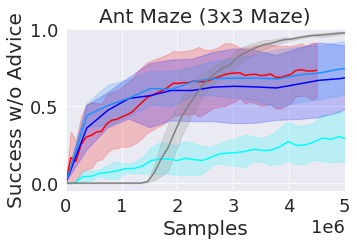

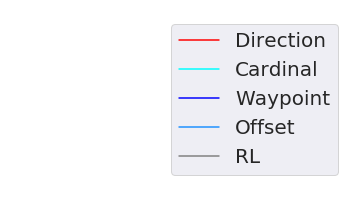

ENV NAME 2
X UNIT NAME itr
FEEDBACK PER TIMESTEP 4000
X data [      0   80000   80000  160000  240000  296000  320000  400000  480000
  560000  640000  720000  800000  880000  960000 1040000 1120000 1200000
 1280000 1360000 1440000 1520000 1600000 1680000 1760000 1840000 1920000
 2000000 2080000 2160000 2240000 2320000 2400000 2480000 2560000 2640000
 2720000 2800000 2880000 2960000 3040000 3120000 3200000 3280000 3360000
 3440000 3520000 3600000 3680000 3760000 3840000 3920000 4000000 4080000
 4160000 4240000 4320000 4400000 4480000 4496000]
X UNIT NAME itr
FEEDBACK PER TIMESTEP 4000
X data [      0   80000   80000  160000  240000  296000  320000  400000  480000
  560000  640000  720000  800000  880000  960000 1040000 1120000 1200000
 1280000 1360000 1440000 1520000 1600000 1680000 1760000 1840000 1920000
 2000000 2080000 2160000 2240000 2320000 2400000 2480000 2560000 2640000
 2720000 2800000 2880000 2960000 3040000 3120000 3200000 3280000 3360000
 3440000 3520000 3600000 3680000 376

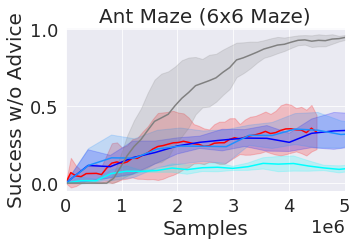

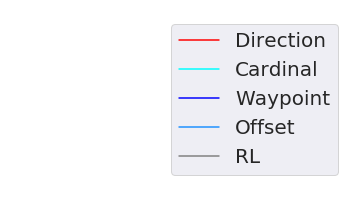

ENV NAME 3
X UNIT NAME itr
FEEDBACK PER TIMESTEP 4000
X data [       0    80000   160000   240000   320000   400000   480000   560000
   640000   720000   800000   880000   960000  1000000  1040000  1120000
  1200000  1280000  1360000  1440000  1520000  1600000  1680000  1760000
  1840000  1920000  2000000  2080000  2160000  2240000  2320000  2400000
  2480000  2560000  2640000  2720000  2800000  2880000  2960000  3040000
  3120000  3200000  3280000  3360000  3440000  3520000  3600000  3680000
  3760000  3840000  3920000  4000000  4080000  4160000  4240000  4320000
  4400000  4480000  4560000  4640000  4720000  4800000  4880000  4960000
  5040000  5120000  5200000  5280000  5360000  5440000  5520000  5600000
  5680000  5760000  5840000  5920000  6000000  6080000  6160000  6240000
  6320000  6400000  6480000  6560000  6640000  6720000  6800000  6880000
  6960000  7040000  7120000  7200000  7280000  7360000  7440000  7520000
  7600000  7680000  7760000  7840000  7920000  8000000  8080000

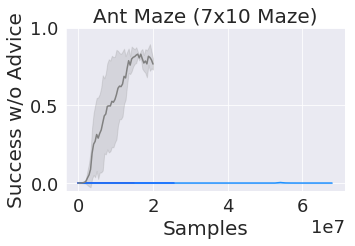

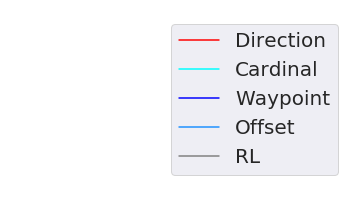

In [103]:
samples = True

x_unit = 'Samples' if samples else 'feedback'
x_label = 'Samples' if samples else 'Advice Units'
all_multiplier = 200 * 20 if samples else 1  # Note: there is no separate rl_multiplier since these all used the same FPP and # envs


plt.rcParams['figure.figsize'] = [5, 3]


metric = 'success_rate'
smooth=50



data_names = [
        (['M0327', 'M0328', 'M0329'], 'Direction', all_multiplier, direction_color, None),
        (['M0330', 'M0331', 'M0332'], 'Cardinal', all_multiplier, cardinal_color, None),
        (['M0333', 'M0334', 'M0335'], 'Waypoint', all_multiplier, waypoint_color, None),
        (['M0336', 'M0337', 'M0338'], 'Offset', all_multiplier, offset_color, None),
        (['M0339', 'M0340', 'M0341'], 'RL', all_multiplier, rl_color, None),
    ]
x_max = 5e6 if samples else 3e5
plot_finetune_generalization(data_names, 'Ant Maze (3x3 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=x_max, 
                             y_min=-.05, 
                             save_name=f'distill_ant_l0{"_samples" if samples else ""}.pdf', 
                             y_label="Success w/o Advice")


data_names = [
        (['M0345', 'M0346', 'M0347'], 'Direction', all_multiplier, direction_color, None),
        (['M0348', 'M0349', 'M0350'], 'Cardinal', all_multiplier, cardinal_color, None),
        (['M0351', 'M0352', 'M0353'], 'Waypoint', all_multiplier, waypoint_color, None),
        (['M0354', 'M0355', 'M0356'], 'Offset', all_multiplier, offset_color, None),
        (['M0357', 'M0358', 'M0359'], 'RL', all_multiplier, rl_color, None),
    ]

x_max = 5e6 if samples else 3e5
plot_finetune_generalization(data_names, 'Ant Maze (6x6 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=x_max, 
                             y_min=-.05, 
                             save_name=f'distill_ant_l2{"_samples" if samples else ""}.pdf', 
                             y_label="Success w/o Advice")

data_names = [
        (['M0363', 'M0364', 'M0365'], 'Direction', all_multiplier, direction_color, None),
        (['M0366', 'M0367', 'M0368'], 'Cardinal', all_multiplier, cardinal_color, None),
        (['M0369', 'M0370', 'M0371'], 'Waypoint', all_multiplier, waypoint_color, None),
        (['M0372', 'M0373', 'M0374'], 'Offset', all_multiplier, offset_color, None),
        (['M0375', 'M0376', 'M0377'], 'RL', all_multiplier, rl_color, None),
    ]
x_max = None if samples else 3e5
plot_finetune_generalization(data_names, 'Ant Maze (7x10 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=x_max, 
                             y_min=-.05, 
                             y_max=1,
                             save_name=f'distill_ant_l3{"_samples" if samples else ""}.pdf', 
                             y_label="Success w/o Advice")

In [124]:
samples = False

x_unit = 'Samples' if samples else 'feedback'
x_label = 'Samples' if samples else 'Advice Units'
all_multiplier = 200 * 20 if samples else 1

metric = 'success_rate'


l0_name = '3x3 Maze'
l2_name = '6x6 Maze'
l3_name = '7x10 Maze'


data_names = [
    # L0
        (['M0327', 'M0328', 'M0329'], (l0_name, 'Direction'), all_multiplier, direction_color, False),
        (['M0330', 'M0331', 'M0332'], (l0_name, 'Cardinal'), all_multiplier, cardinal_color, False),
        (['M0333', 'M0334', 'M0335'], (l0_name, 'Waypoint'), all_multiplier, waypoint_color, False),
        (['M0336', 'M0337', 'M0338'], (l0_name, 'Offset'), all_multiplier, offset_color, False),
        (['M0339', 'M0340', 'M0341'], (l0_name, 'RL'), all_multiplier, rl_color, False),
    # L2
        (['M0345', 'M0346', 'M0347'], (l2_name, 'Direction'), all_multiplier, direction_color, False),
        (['M0348', 'M0349', 'M0350'], (l2_name, 'Cardinal'), all_multiplier, cardinal_color, False),
        (['M0351', 'M0352', 'M0353'], (l2_name, 'Waypoint'), all_multiplier, waypoint_color, False),
        (['M0354', 'M0355', 'M0356'], (l2_name, 'Offset'), all_multiplier, offset_color, False),
        (['M0357', 'M0358', 'M0359'], (l2_name, 'RL'), all_multiplier, rl_color, False),
    # L3
        (['M0363', 'M0364', 'M0365'], (l3_name, 'Direction'), all_multiplier, direction_color, False),
        (['M0366', 'M0367', 'M0368'], (l3_name, 'Cardinal'), all_multiplier, cardinal_color, False),
        (['M0369', 'M0370', 'M0371'], (l3_name, 'Waypoint'), all_multiplier, waypoint_color, False),
        (['M0372', 'M0373', 'M0374'], (l3_name, 'Offset'), all_multiplier, offset_color, False),
        (['M0375', 'M0376', 'M0377'], (l3_name, 'RL'), all_multiplier, rl_color, False),
    ]

df = make_table(data_names, 'Ant Maze Env', 
                         metric=metric, 
                         smooth=global_smooth, 
                         x_metric=x_unit, 
                         x_eval=3e5,
                         plot_latex=True,
                         transpose=False)

ENV NAME 0
X UNIT NAME num_feedback
FEEDBACK PER TIMESTEP 1
X data [      0   80000  160000  240000  244000  300000  324000  404000  484000
  564000  644000  724000  804000  884000  964000 1044000 1124000 1204000
 1284000 1364000 1444000 1524000 1604000 1684000 1764000 1844000 1924000
 2004000 2084000 2164000 2244000 2324000 2404000 2484000 2564000 2644000
 2724000 2804000 2884000 2964000 3044000 3124000 3204000 3284000 3364000
 3444000 3524000 3604000 3684000 3764000 3844000 3924000 4004000 4084000
 4164000 4244000 4324000 4404000 4484000 4500000]
X UNIT NAME num_feedback
FEEDBACK PER TIMESTEP 1
X data [      0   80000  160000  240000  244000  300000  324000  404000  484000
  564000  644000  724000  804000  884000  964000 1044000 1124000 1204000
 1284000 1364000 1444000 1524000 1604000 1684000 1764000 1844000 1924000
 2004000 2084000 2164000 2244000 2324000 2404000 2484000 2564000 2644000
 2724000 2804000 2884000 2964000 3044000 3124000 3204000 3284000 3364000
 3444000 3524000 3604000

In [ ]:
data = df.to_numpy()
for row in data:
    vals = []
    max_mean = 0
    max_std = 0
    for point in row:
        mean = float(point[1:point.index(' \\')])
        std = float(point[point.index('m') + 2:-1])
        if mean > max_mean:
            max_mean = mean
            max_std = std
        vals.append((mean, std))
    for mean, std in vals:
        if mean + std >= max_mean - std:
            print('yes', mean, std)
        else:
            print('no', mean, std)
    print("==========")
            

In [ ]:

# metric = 'success_rate'
# smooth=50

# data_names = [
#         (['R0327', 'R0328', 'R0329'], 'Direction', all_multiplier, direction_color, None),
#         (['R0330', 'R0331', 'R0332'], 'Cardinal', all_multiplier, cardinal_color, None),
#         (['R0333', 'R0334', 'R0335'], 'Waypoint', all_multiplier, waypoint_color, None),
#         (['R0336', 'R0337', 'R0338'], 'Offset', all_multiplier, offset_color, None),
#         (['R0339', 'R0340', 'R0341'], 'RL', all_multiplier, rl_color, None),
#     ]

# plot_finetune_generalization(data_names, 'Ant Env (3x3)', 
#                              metric=metric, 
#                              smooth=global_smooth, 
#                              x_label=x_unit, 
#                              x_max=5e5, 
#                              y_label="Success (Rollout w/o Advice)",
#                              caption_below=True)


# data_names = [
#         (['R0345', 'R0346', 'R0347'], 'Direction', all_multiplier, direction_color, None),
#         (['R0348', 'R0349', 'R0350'], 'Cardinal', all_multiplier, cardinal_color, None),
#         (['R0351', 'R0352', 'R0353'], 'Waypoint', all_multiplier, waypoint_color, None),
#         (['R0354', 'R0355', 'R0356'], 'Offset', all_multiplier, offset_color, None),
#         (['R0357', 'R0358', 'R0359'], 'RL', all_multiplier, rl_color, None),
#     ]


# plot_finetune_generalization(data_names, 'Ant Env (6x6)', 
#                              metric=metric, 
#                              smooth=global_smooth, 
#                              x_label=x_unit, 
#                              x_max=5e5, 
#                              y_label="Success (Rollout w/o Advice)",
#                              caption_below=True)


# data_names = [
#         (['R0363', 'R0364', 'R0365'], 'Direction', all_multiplier, direction_color, None),
#         (['R0366', 'R0367', 'R0368'], 'Cardinal', all_multiplier, cardinal_color, None),
#         (['R0369', 'R0370', 'R0371'], 'Waypoint', all_multiplier, waypoint_color, None),
#         (['R0372', 'R0373', 'R0374'], 'Offset', all_multiplier, offset_color, None),
#         (['R0375', 'R0376', 'R0377'], 'RL', all_multiplier, rl_color, None),
#     ]

# plot_finetune_generalization(data_names, 'Ant Env (7x10)', 
#                              metric=metric, 
#                              smooth=global_smooth, 
#                              x_label=x_unit, 
# #                              x_max=1e6, 
#                              y_min=-.01, 
#                              y_max=.4,
#                              y_label="Success (Rollout w/o Advice)",
#                              caption_below=True)

## Human Exps

ENV NAME 53
lengths [12980, 29280, 22000]
ENV NAME 53
lengths [9780, 21260, 14420]


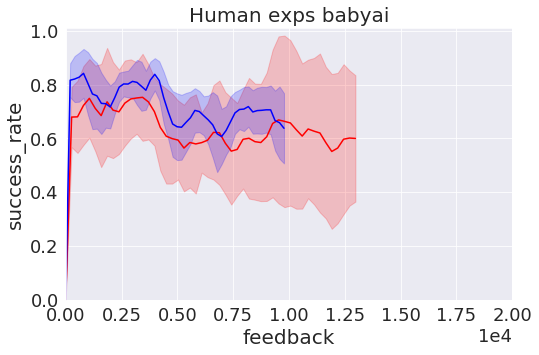

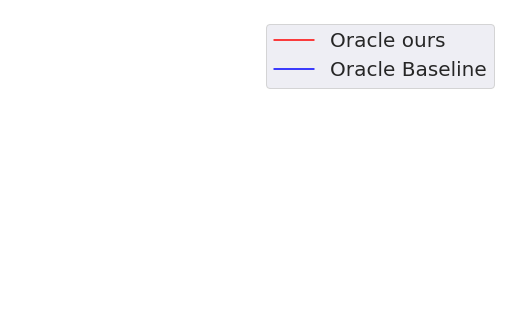

ENV NAME 0
lengths [14720, 13260]


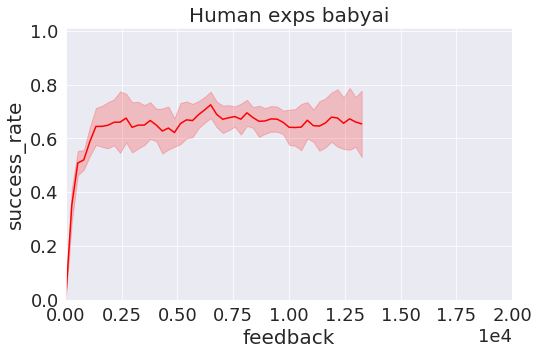

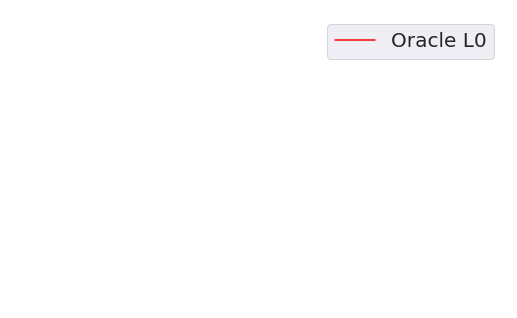

ENV NAME 2
lengths [7740, 8620]


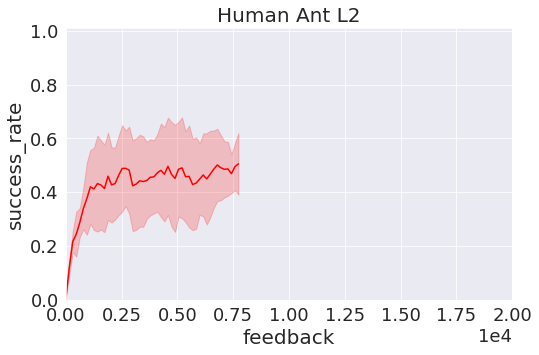

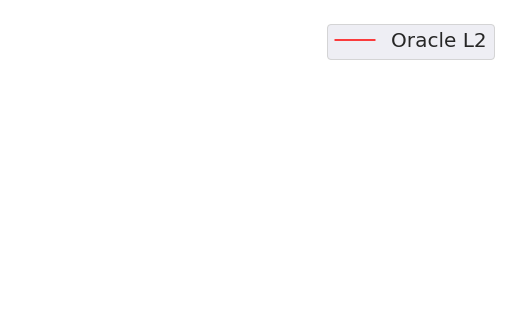

ENV NAME 53
ENV NAME 53
DATA (0.58, 0.74) (0.33, 0.08)


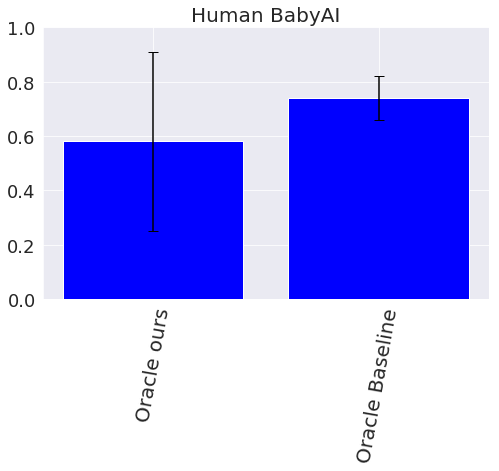

ENV NAME 0
DATA (0.63,) (0.1,)


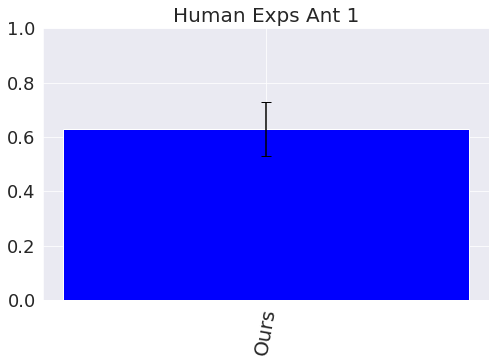

ENV NAME 2
DATA (0.47,) (0.08,)


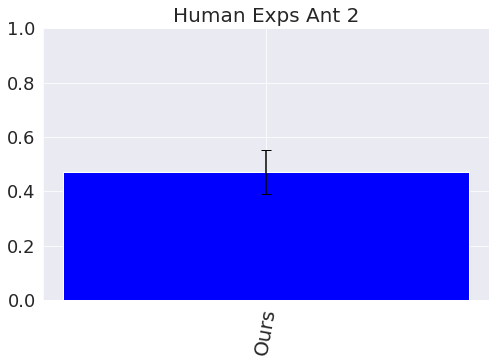

In [172]:
x_unit = 'feedback'
metric = 'success_rate'
x_label = 'Advice Units'
smooth=50

# BABYAI

data_names = [
        (['T6105', 'T6132', 'T6133'], 'Oracle ours', 1, 'red', None),
        (['T6106', 'T6107', 'T0653'], 'Oracle Baseline', 1, 'blue', None), 
    ]


plot_finetune_generalization(data_names, 'Human exps babyai', metric=metric, smooth=smooth, 
                             x_label=x_unit, x_max=2e4, save_name='human_babyai.pdf')


# ANT


data_names = [
        (['T6124', 'T6125'], 'Oracle L0', 1, 'red', None),
    ]


plot_finetune_generalization(data_names, 'Human exps babyai', metric=metric, smooth=smooth, 
                             x_label=x_unit, x_max=2e4, save_name='human_ant_l0.pdf')


data_names = [
        (['T6122', 'T6123'], 'Oracle L2', 1, 'red', None),
    ]


plot_finetune_generalization(data_names, 'Human Ant L2', metric=metric, smooth=smooth, 
                             x_label=x_unit, x_max=2e4, save_name='human_ant_l2.pdf')


data_names = [
        (['T6105', 'T6132', 'T6133'], 'Oracle ours', 1, 'red', None),
        (['T6106', 'T6107'], 'Oracle Baseline', 1, 'blue', None),
    ]

bar_plot_at_point(data_names, 'Human BabyAI', metric=metric, smooth=smooth, 
                             x_metric=x_unit, x_eval=.3e4, save_name='human_babyai_bar.pdf')


data_names = [
        (['T6124', 'T6125'], 'Ours', 1, 'red', None),
#         (['T6122', 'T6123'], 'RL', 1, 'blue', None),
#         (['T6122', 'T6123'], 'RL xxxx', 1, 'blue', None),
    ]

bar_plot_at_point(data_names, 'Human Exps Ant 1', metric=metric, smooth=smooth, 
                             x_metric=x_unit, x_eval=.3e4, save_name='human_ant_l0_bar.pdf')


data_names = [
        (['T6122', 'T6123'], 'Ours', 1, 'red', None),
#         (['T6122', 'T6123'], 'RL', 1, 'blue', None),
#         (['T6122', 'T6123'], 'RL xxxx', 1, 'blue', None),
    ]

bar_plot_at_point(data_names, 'Human Exps Ant 2', metric=metric, smooth=smooth, 
                             x_metric=x_unit, x_eval=.3e4, save_name='human_ant_l2_bar.pdf')



ENV NAME 53
X UNIT NAME itr
FEEDBACK PER TIMESTEP 1
X data [    0    20    40    60    80   100   120   140   160   180   200   220
   240   260   280   300   320   340   360   380   400   420   440   460
   480   500   520   540   560   580   600   620   640   660   680   700
   720   740   760   780   800   820   840   860   880   900   920   940
   960   980  1000  1020  1040  1060  1080  1100  1120  1140  1160  1180
  1200  1220  1240  1260  1280  1300  1320  1340  1360  1380  1400  1420
  1440  1460  1480  1500  1520  1540  1560  1580  1600  1620  1640  1660
  1680  1700  1720  1740  1760  1780  1800  1820  1840  1860  1880  1900
  1920  1940  1960  1980  2000  2020  2040  2060  2080  2100  2120  2140
  2160  2180  2200  2220  2240  2260  2280  2300  2320  2340  2360  2380
  2400  2420  2440  2460  2480  2500  2520  2540  2560  2580  2600  2620
  2640  2660  2680  2700  2720  2740  2760  2780  2800  2820  2840  2860
  2880  2900  2920  2940  2960  2980  3000  3020  3040  3060  308

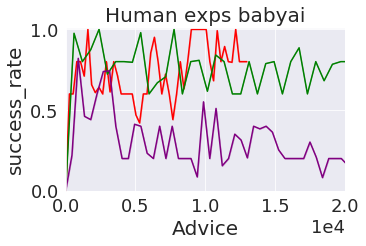

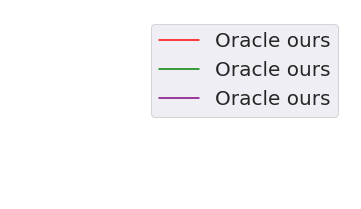

In [107]:
metric='success_rate'
x_unit = 'Advice'
x_label = 'advice'
smooth = 1
data_names = [
        (['T6105',], 'Oracle ours', 1, 'red', None),
        (['T6132',], 'Oracle ours', 1, 'green', None),
        ([ 'T6133'], 'Oracle ours', 1, 'purple', None),
    ]

plot_finetune_generalization(data_names, 'Human exps babyai', metric=metric, smooth=smooth, 
                             x_label=x_unit, x_max=2e4, save_name=None)

ENV NAME 0
X UNIT NAME itr
FEEDBACK PER TIMESTEP 1
X data [   0   20   40   60   75   75   80  100  120  140  160  180  200  220
  240  260  280  300  320  340  360  380  400  420  440  460  480  500
  520  540  560  580  600  620  640  660  680  700  720  740  750  750
  760  780  800  820  840  860  880  900  920  940  960  980 1000 1020
 1040 1060 1080 1100 1120 1140 1160 1180 1200 1220 1240 1260 1280 1300
 1320 1340 1360 1380 1400 1420 1440 1460 1480 1500]
X UNIT NAME itr
FEEDBACK PER TIMESTEP 1
X data [   0   20   40   60   75   75   80  100  120  140  160  180  200  220
  240  260  280  300  320  340  360  380  400  420  440  460  480  500
  520  540  560  580  600  620  640  660  680  700  720  740  750  750
  760  780  800  820  840  860  880  900  920  940  960  980 1000 1020
 1040 1060 1080 1100 1120 1140 1160 1180 1200 1220 1240 1260 1280 1300
 1320 1340 1360 1380 1400 1420 1440 1460 1480 1500]
X UNIT NAME itr
FEEDBACK PER TIMESTEP 1
X data [   0   20   40   60   75   75   8

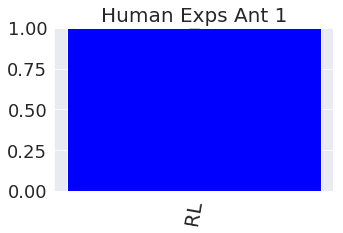

ENV NAME 2
X UNIT NAME num_feedback
FEEDBACK PER TIMESTEP 1
X data [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
X UNIT NAME num_feedback
FEEDBACK PER TIMESTEP 1
X data [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0

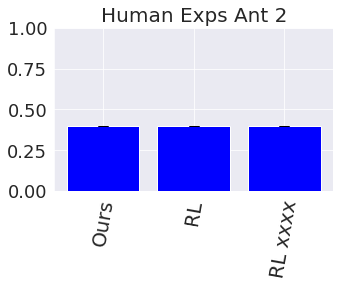

In [111]:
# RL EVAL AT DIFF POINTS



# data_names = [
#         (['M0339', 'M0340', 'M0341'], 'RL', 1, 'red', None),
#     ]

# bar_plot_at_point(data_names, 'Human Exps Ant 1', metric=metric, smooth=smooth, 
#                              x_metric='Samples', x_eval=.3e4)


data_names = [
        (['T6122', 'T6123'], 'Ours', 1, 'red', None),
        (['T6122', 'T6123'], 'RL', 1, 'blue', None),
        (['T6122', 'T6123'], 'RL xxxx', 1, 'blue', None),
    ]

bar_plot_at_point(data_names, 'Human Exps Ant 2', metric=metric, smooth=smooth, 
                             x_metric=x_unit, x_eval=.3e4, save_name='human_ant_l2_bar.pdf')


ValueError: shape mismatch: objects cannot be broadcast to a single shape

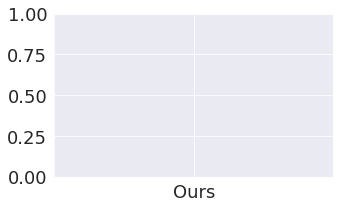

In [110]:
# L0

## SAMPLE COMPARISON
x_labels = ['Ours', 'RL 1x', 'RL 10x', 'RL 100x', 'RL 1000x', 'RL 10,000x']
y_means = [.63, .47]
y_stds = [.47, .08]
title=''

plt.title(title, fontsize=20)
color = 'blue'
plt.bar(x_labels, y_means, yerr=y_stds, capsize=5, color=color)
plt.xticks(rotation=80, fontsize=20)
plt.ylim(0, 1)
# plt.savefig(f'figs/{save_name}.pdf', bbox_inches='tight')
plt.show()




# L2
# x_labels = [5e4, 5e4]
y_means = [.47]
y_stds = [.08]

plt.title(title, fontsize=20)
color = 'blue'
plt.bar(x_labels, y_means, yerr=y_stds, capsize=5, color=color)
plt.xticks(rotation=80, fontsize=20)
plt.ylim(0, 1)
# plt.savefig(f'figs/{save_name}.pdf', bbox_inches='tight')
plt.show()




In [ ]:
samples = False

data_names = [
    
        (['T6124', 'T6125'], 'Oracle L0', 1, 'red', None),
        (['M0339', 'M0340', 'M0341'], 'RL', all_multiplier, rl_color, None),
    ]
x_max = 1e6 if samples else 3e5
plot_finetune_generalization(data_names, 'Ant Maze (3x3 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=x_max, 
                             y_min=-.05, 
                             save_name=None, 
                             y_label="Success w/o Advice")


data_names = [
    (['T6122', 'T6123'], 'Oracle L2', 1, 'red', None),
        (['M0357', 'M0358', 'M0359'], 'RL', all_multiplier, rl_color, None),
    ]

x_max = 1e6 if samples else 3e5
plot_finetune_generalization(data_names, 'Ant Maze (6x6 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=x_max, 
                             y_min=-.05, 
                             save_name=None, 
                             y_label="Success w/o Advice")


## Other Final Plots

### DAgger

In [ ]:
plt.rcParams['figure.figsize'] = [4, 2]
x_unit = 'Advice Units'
metric = 'success_rate'

dagger_color = 'green'
real_time_color = 'blue'

data_names = [
        (['M0078', 'M0079', 'M0080'], 'Default', 1, real_time_color, None),
#         (['TT6126', 'TT6127'], '50% DAgger', 1, 'green', None),
        (['M0564', 'M0565', 'M0566'], 'DAgger', 1, dagger_color, None),
    ]


plot_finetune_generalization(data_names, 'Point Maze Env (6x6)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=3e5, 
                             save_name='dagger_pm_l2.pdf', 
                             y_label="Success",)

data_names = [
        (['M0096', 'M0097', 'M0098'], 'Default', 1, real_time_color, None),
        (['M0567', 'M0568', 'M0569'], 'DAgger', 1, dagger_color, None),
    ]

plot_finetune_generalization(data_names, 'Point Maze (7x10)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=3e5, 
                             y_min=-.01, 
                             save_name='dagger_pm_l3.pdf', 
                             y_label="Success",)


data_names = [
        (['M0114', 'M0115', 'M0116'], 'Default', 1, real_time_color, None),
        (['M0570', 'M0571', 'M0572'], 'DAgger', 1, dagger_color, None),
    ]

plot_finetune_generalization(data_names, 'Point Maze (10x10)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=3e5, 
                             save_name='dagger_pm_l13.pdf', 
                             y_label="Success",)


data_names = [
        (['M0132', 'M0133', 'M0134'], 'Default', 1, real_time_color, None),
        (['M0573', 'M0574', 'M0575'], 'DAgger', 1, dagger_color, None),
    ]

plot_finetune_generalization(data_names, 'Point Maze (13x13)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=3e5, 
                             save_name='dagger_pm_l14.pdf', 
                             y_label="Success")


data_names = [
        (['M0336', 'M0337', 'M0338'], 'Default', 1, real_time_color, None),
        (['M0591', 'M0592', 'M0593'], 'DAgger', 1, dagger_color, None),
    ]

plot_finetune_generalization(data_names, 'Ant Maze (3x3)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=3e5, 
                             save_name='dagger_ant_l0.pdf', 
                             y_label="Success",)


data_names = [
        (['M0354', 'M0355', 'M0356'], 'Default', 1, real_time_color, None),
        (['M0594', 'M0595', 'M0596'], 'DAgger', 1, dagger_color, None),
    ]

plot_finetune_generalization(data_names, 'Ant Maze (6x6)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=3e5, 
                             save_name='dagger_ant_l2.pdf', 
                             y_label="Success",)



data_names = [
        (['M0225', 'M0226', 'M0227'], 'Default', 1, real_time_color, None),
#         (['M0609', 'M0610', 'M0611'], 'DAgger', 1, 'purple', None),
        (['M0576', 'M0577', 'M0578'], 'DAgger', 1, dagger_color, None),
    ]
plot_finetune_generalization(data_names, 'BabyAI Test Env 1', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=1e5, 
#                              y_max=.3,
                             y_min=-.05,
                             save_name=f'dagger_babyai_l27{"_samples" if samples else ""}.pdf', 
                             y_label="Success",)

data_names = [
        (['M0240', 'M0241', 'M0242'], 'Default', 1, real_time_color, None),
#         (['M0612', 'M0613', 'M0614'], 'DAgger', 1, 'purple', None),
        (['M0579', 'M0580', 'M0581'], 'DAgger', 1, dagger_color, None),
    ]
plot_finetune_generalization(data_names, 'BabyAI Test Env 2', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=3e5, 
                             y_min=-.05,
                             save_name=f'dagger_babyai_l28{"_samples" if samples else ""}.pdf', 
                             y_label="Success")

### Noise

In [ ]:
metric = 'success_rate'
x_unit='Advice Units'

data_names = [
        (['M0078', 'M0079', 'M0080'], '0% Noise', 1, 'red', None),
        (['M0654', 'M0655', 'M0656'], '10% Noise', 1, 'orange', None),
        (['M0657', 'M0658', 'M0659'], '25% Noise', 1, 'blue', None),
        (['M0660', 'M0661', 'M0662'], '50% Noise', 1, 'purple', None),
        (['M0663', 'M0664', 'M0665'], '100% Noise', 1, 'black', None),
    ]

plot_finetune_generalization(data_names, 'Robustness to Noise - Point Maze', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=5e4, 
                             y_min=-.05,
                             save_name=f'noise.pdf', 
                             y_label="Success (Rollout w/o Advice)",)

### Legends

In [ ]:

plt.rcParams['figure.figsize'] = [20, 5]
color_list = ['red', 'blue', 'dodgerblue', 'cyan', 'gray']
labels = ['Ours: Direction/Action Advice', 
          'Ours: Waypoint Advice', 
          'Ours: Offset Waypoint Advice', 
          'Ours: Subgoal/Cardinal Advice', 
          'Baseline: No Advice']
for c in color_list:
    plt.plot([1], [1], color=c)
    plt.xlim(-10, 0)
    plt.ylim(-2, -1)
plt.legend(labels, fontsize=20, ncol=3)
plt.box(False)
plt.axis('off')
plt.savefig('figs/rl_train_legend.pdf')
plt.show()

plt.rcParams['figure.figsize'] = [20, 5]
color_list = ['red', 'blue', 'dodgerblue', 'cyan', 'black', 'gray']
labels = ['Ours: Direction/Action Advice', 
          'Ours: Waypoint Advice', 
          'Ours: Offset Waypoint Advice', 
          'Ours: Subgoal/Cardinal Advice', 
          'Baseline: Behavioral Cloning',
          'Baseline: Shaped-Reward RL']
for c in color_list:
    plt.plot([1], [1], color=c)
    plt.xlim(-10, 0)
    plt.ylim(-2, -1)
plt.legend(labels, fontsize=20, ncol=2)
plt.box(False)
plt.axis('off')
plt.savefig('figs/distill_legend.pdf')
plt.show()


plt.rcParams['figure.figsize'] = [20, 5]
color_list = ['green', 'blue']
labels = ['DAgger Advice', 
          'Real-Time Advice', ]
for c in color_list:
    plt.plot([1], [1], color=c)
    plt.xlim(-10, 0)
    plt.ylim(-2, -1)
plt.legend(labels, fontsize=20, ncol=2)
plt.box(False)
plt.axis('off')
plt.savefig('figs/dagger_legend.pdf')
plt.show()

### Mega Plot

8.14453125
19.53125
[5.120e+05 4.170e+06 9.016e+09]
['Best Advice', 'BC', 'RL'] [5.120e+05 4.170e+06 9.016e+09]


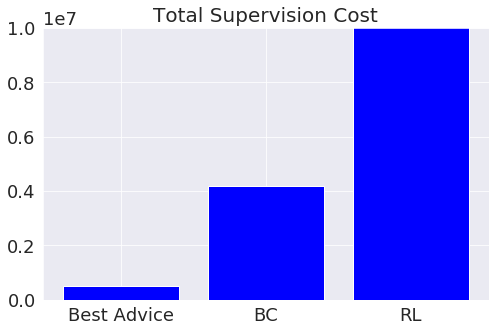

7.109282157478596
15.373664605058243
[6.50463000e+05 4.62432500e+06 1.79408163e+08]
['Best Advice', 'BC', 'RL'] [6.50463000e+05 4.62432500e+06 1.79408163e+08]


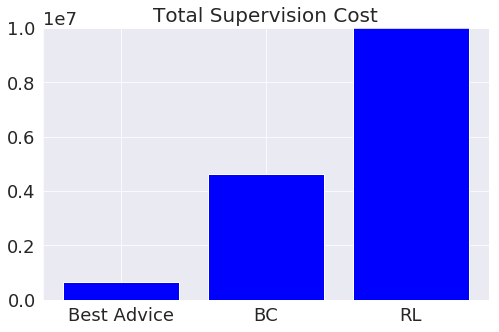

In [169]:
# PM
off_s1=2.2e4
labels = ['Best Advice', 'BC', 'RL']
l2_levels = [ # Stps until near-convergence on L2 (.98) <-- check exact #
             5e4, # For offset
             2e6, 
             4e6
             ]
l2_levelsb = [ # Recomputed
    48987,
    1824326,
    4408163,
]
l3_levels = [
    7e4, 
    1e6, 
    6e6
    ]
l3_levelsb = [
    55107,
    1028571,
    8e7,
]
l13_levels = [
    1.7e5, 
    1.7e5, 
    6e6
    ] # **1.7e5 == 2.3e5
l13_levelsb = [
    48981,
    685714,
    8e7
]
l14_levels = [
    2e5, 
    1e6, 
    9e9,
    ]
l14_levelsb = [
    97388,
    1085714,
    1.5e7,
]
s1_levels = [
    off_s1, 
    0, 
    0
    ]
s1_levelsb = [
    .4e6,
    0,
    0,
]



total = np.array(l2_levels) + np.array(l3_levels) + np.array(l13_levels) + np.array(l14_levels) + np.array(s1_levels)

# TODO: get single plots

print(total[1]/total[0])
print(1e7/total[0])
print(total)

plt.rcParams['figure.figsize'] = [8, 5]

plt.title('Total Supervision Cost', fontsize=20)
color = 'blue'
print(labels, total)
plt.ticklabel_format(scilimits=(0,0), fontsize=20, style='sci')
plt.bar(labels, total, color=color)
# plt.xticks(rotation=80, fontsize=20)
plt.ylim(0, 1e7)
plt.savefig('figs/mega_total_pm.pdf', bbox_inches='tight')
plt.show()


# The 'B' version was redone, calculating convergence using the plot_convergence function

totalb = np.array(l2_levelsb) + np.array(l3_levelsb) + np.array(l13_levelsb) + np.array(l14_levelsb) + np.array(s1_levelsb)

# TODO: get single plots

print(totalb[1]/totalb[0])
print(1e7/totalb[0])
print(totalb)


plt.rcParams['figure.figsize'] = [8, 5]

plt.title('Total Supervision Cost', fontsize=20)
color = 'blue'
print(labels, totalb)
plt.ticklabel_format(scilimits=(0,0), fontsize=20, style='sci')
plt.bar(labels, totalb, color=color)
# plt.xticks(rotation=80, fontsize=20)
plt.ylim(0, 1e7)
plt.savefig('figs/mega_total_pm.pdf', bbox_inches='tight')
plt.show()


In [44]:
# ANT
off_s1=1e7
labels = ['Best Advice', 'RL']
l0_levels = []
l2_levels = []
s1_levels = [off_s1, 0]

total = np.array(l0_levels) + np.array(l2_levels) + np.array(s1_levels)

# TODO: get single plots

print(total[1]/total[0])
print(1e7/total[0])


plt.rcParams['figure.figsize'] = [8, 5]

plt.title('Total Supervision Cost', fontsize=20)
color = 'blue'
print(labels, total)
plt.ticklabel_format(scilimits=(0,0), fontsize=20, style='sci')
plt.bar(labels, total, color=color)
# plt.xticks(rotation=80, fontsize=20)
plt.ylim(0, 1e7)
plt.savefig('figs/mega_total_pm.pdf', bbox_inches='tight')
plt.show()


ValueError: operands could not be broadcast together with shapes (0,) (2,) 

### Half DAgger

In [ ]:
x_unit = 'Advice Units'
metric = 'success_rate'
smooth = 5

data_names = [
        (['M0225', 'M0226', 'M0227'], 'Default', 1, offset_color, None),
        (['M0576', 'M0577', 'M0578'], 'DAgger', 1, dagger_color, None),
    ]

plot_finetune_generalization(data_names, 'BabyAI Env (Go To Object, More Distractors)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=1e5, 
                             y_max=.3,
                             save_name='dagger_babyai_l27.pdf', 
                             y_label="Success (Rollout w/o Advice)",
                             new_logging=True,
                             caption_below=True)

data_names = [
        (['M0240', 'M0241', 'M0242'], 'Default', 1, offset_color, None),
        (['TT6129'], '50% DAgger', 1, 'green', None),
        (['M0579', 'M0580', 'M0581'], 'DAgger', 1, dagger_color, None),
    ]


plot_finetune_generalization(data_names, 'BabyAI Env (Go To Heldout Object)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=3e5, 
                             save_name='dagger_babyai_l28.pdf', 
                             y_label="Success (Rollout w/o Advice)",
                             new_logging=True,
                             caption_below=True)



In [ ]:
x_unit = 'feedback'
metric = 'success_rate'
smooth=50


data_names = [
        (['M0336', 'M0337', 'M0338'], 'Default', 1, offset_color, None),
        (['M0591', 'M0592', 'M0593'], 'DAgger', 1, dagger_color, None),
    ]

plot_finetune_generalization(data_names, 'Ant Env (Different Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=3e5, 
                             y_min=-.05, 
                             save_name='dagger_ant_l0.pdf', 
                             y_label="Success (Rollout w/o Advice)",
                             new_logging=True,
                             caption_below=True)


data_names = [
        (['M0354', 'M0355', 'M0356'], 'Default', 1, offset_color, None),
        (['TT6130', 'TT6131'], '50% DAgger', 1, 'green', None),
        (['M0594', 'M0595', 'M0596'], 'DAgger', 1, dagger_color, None),
    ]


plot_finetune_generalization(data_names, 'Ant Env (Larger Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=3e5, 
                             y_min=-.05, 
                             save_name='dagger_ant_l2.pdf', 
                             y_label="Success (Rollout w/o Advice)",
                             new_logging=True,
                             caption_below=True)


## Hparam Sweep/Misc

In [ ]:
# samples = False

# x_unit = 'Samples' if samples else 'feedback'
# x_label = 'Samples' if samples else 'Advice Units'
# all_multiplier = 40 * 20 if samples else 1

# global_smooth=10


# plt.rcParams['figure.figsize'] = [10, 5]

# metric = 'success_rate'

# multiplier = 40 * 20

# data_names = [
# #         (['M0069', 'M0070', 'M0071'], 'Direction', all_multiplier, direction_color, None),
#         (['M0072', 'M0073', 'M0074'], 'Cardinal', all_multiplier, cardinal_color, None),
#         (['M0075', 'M0076', 'M0077'], 'Waypoint', all_multiplier, waypoint_color, None),
#         (['M0078', 'M0079', 'M0080'], 'Offset', all_multiplier, offset_color, None),
# #         (['M0081', 'M0082', 'M0083'], 'RL', all_multiplier, rl_color, None),
# #         (['M0084', 'M0085', 'M0086'], 'Distill from Oracle', multiplier, bc_bad_color, None),
# #         (['M0552', 'M0553', 'M0554'], 'Distill from Oracle Noisy', multiplier, bc_color, None),
#     ]


# x_max = 1e6 if samples else 3e5
# plot_finetune_generalization(data_names, 'Point Maze Env (6x6 Maze)', 
#                              metric=metric, 
#                              smooth=global_smooth, 
#                              x_label=x_unit, 
# #                              x_max=x_max, 
#                              save_name=f'distill_pm_l2{"_samples" if samples else ""}.pdf', 
#                              y_label="Success (Rollout w/o Advice)")

# data_names = [
# #         (['M0087', 'M0088', 'M0089'], 'Direction', all_multiplier, direction_color, None),
#         (['M0090', 'M0091', 'M0092'], 'Cardinal', all_multiplier, cardinal_color, None),
#         (['M0093', 'M0094', 'M0095'], 'Waypoint', all_multiplier, waypoint_color, None),
#         (['M0096', 'M0097', 'M0098'], 'Offset', all_multiplier, offset_color, None),
# #         (['M0099', 'M0100', 'M0101'], 'RL', all_multiplier, rl_color, None),
# #         (['M0102', 'M0103', 'M0104'], 'Distill from Oracle', multiplier, bc_bad_color, None),
# #         (['M0555', 'M0556', 'M0557'], 'Distill from Oracle Noisy', multiplier, bc_color, None),
#     ]

# x_max = 1.25e6 if samples else 3e5
# plot_finetune_generalization(data_names, 'Point Maze Env (7x10 Maze)', 
#                              metric=metric, 
#                              smooth=global_smooth, 
#                              x_label=x_unit, 
# #                              x_max=x_max, 
#                              y_min=-.01, 
#                              save_name=f'distill_pm_l3{"_samples" if samples else ""}.pdf', 
#                              y_label="Success (Rollout w/o Advice)")


# data_names = [
# #         (['M0105', 'M0106', 'M0107'], 'Direction', all_multiplier, direction_color, None),
#         (['M0108', 'M0109', 'M0110'], 'Cardinal', all_multiplier, cardinal_color, None),
#         (['M0111', 'M0112', 'M0113'], 'Waypoint', all_multiplier, waypoint_color, None),
#         (['M0114', 'M0115', 'M0116'], 'Offset', all_multiplier, offset_color, None),
# #         (['M0117', 'M0118', 'M0119'], 'RL', all_multiplier, rl_color, None),
# #         (['M0120', 'M0121', 'M0122'], 'Distill from Oracle', multiplier, bc_bad_color, None),
# #         (['M0558', 'M0559', 'M0560'], 'Distill from Oracle Noisy', multiplier, bc_color, None),
#     ]

# x_max = 1.25e6 if samples else 3e5
# plot_finetune_generalization(data_names, 'Point Maze Env (10x10 Maze)', 
#                              metric=metric, 
#                              smooth=global_smooth, 
#                              x_label=x_unit, 
# #                              x_max=x_max, 
#                              save_name=f'distill_pm_l13{"_samples" if samples else ""}.pdf', 
#                              y_label="Success (Rollout w/o Advice)")


# data_names = [
# #         (['M0123', 'M0124', 'M0125'], 'Direction', all_multiplier, direction_color, None),
#         (['M0126', 'M0127', 'M0128'], 'Cardinal', all_multiplier, cardinal_color, None),
#         (['M0129', 'M0130', 'M0131'], 'Waypoint', all_multiplier, waypoint_color, None),
#         (['M0132', 'M0133', 'M0134'], 'Offset', all_multiplier, offset_color, None),
# #         (['M0135', 'M0136', 'M0137'], 'RL', all_multiplier, rl_color, None),
# #         (['M0138', 'M0139', 'M0140'], 'Distill from Oracle', multiplier, bc_bad_color, None),
# #         (['M0561', 'M0562', 'M0563'], 'Distill from Oracle Noisy', multiplier, bc_color, None),
#     ]

# x_max = 1.25e6 if samples else 3e5#1e6
# plot_finetune_generalization(data_names, 'Point Maze Env (13x13 Maze)', 
#                              metric=metric, 
#                              smooth=global_smooth, 
#                              x_label=x_unit, 
# #                              x_max=x_max, 
#                              save_name=f'distill_pm_l14{"_samples" if samples else ""}.pdf', 
#                              y_label="Success (Rollout w/o Advice)")



In [ ]:
data_names = [
        (['M0039', 'M0040', 'M0041'], 'Cardinal Bootstrap', all_multiplier, orange, None),
#         (['M0003', 'M0004', 'M0005'], 'Cardinal RL', all_multiplier,'blue', None),
    ]

plt.rcParams['figure.figsize'] = [8, 5]

x_max = 8e8 if samples else 1e6
plot_finetune_generalization(data_names, 'Cardinal (PM)', 
                             smooth=10, 
                             x_label=inside_x_label, 
                             y_label=inside_y_label, 
#                              x_max=x_max, 
                             save_name=None)


In [ ]:

data_names = [
#         (['M0141', 'M0142', 'M0143'], 'PreAction Advice', all_multiplier, 'red', None),
#         (['M0144', 'M0145', 'M0146'], 'Offset Advice', all_multiplier, 'dodgerblue', None),
#         (['M0147', 'M0148', 'M0149'], 'Old Subgoal Advice', all_multiplier, 'cyan', None),
        (['M0540', 'M0541', 'M0542'], 'Subgoal Advice', all_multiplier, 'cyan', None),
#         (['M0150', 'M0151', 'M0152'], 'No Advice', all_multiplier, 'gray', None),
    
    ]

metric = 'success_rate'
plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=1, 
                             x_label=x_label, x_max=2e6,
                             y_label="Success (with advice)",
                             save_name=None)

plot_finetune_generalization(data_names, 'BabyAI', metric='stoch_accuracy', smooth=1, 
                             x_label=x_label, x_max=2e6,
                             y_label="Success (with advice)",
                             save_name=None)


In [ ]:
runs = [
#         (['M0144', 'M0145', 'M0146'], 'RL Training', all_multiplier, 'blue', None),
        (['M0171', 'M0172', 'M0173'], 'Distillation', all_multiplier, orange, None),
    ]
if not samples:
    x_max = 1e6 if samples else 1.5e6
plot_finetune_generalization(runs, 'Offset (babyai)', 
                             smooth=1, 
                             x_label=outside_x_label, 
                             metric='success_rate', 
                             y_label=inside_y_label, 
                             save_name=None, 
                             x_max=2e5, )


In [ ]:
runs = [
        (['M0540', 'M0541', 'M0542'], 'RL Training', all_multiplier, 'blue', None),
        (['M0543', 'M0544', 'M0545'], 'Bootstrapping (from PA)', all_multiplier, orange, None),
#         (['M0492', 'M0493', 'M0494'], 'Bootstrapping (from OSR)', all_multiplier, orange, None),
    ]
if not samples:
    add_line(.97, 'Convergence (1e7)', color='blue', above=False)
x_max = 1e7 if samples else 3e6
plot_finetune_generalization(runs, 'Subgoal (babyai)', 
                             smooth=1, 
                             x_label=outside_x_label, 
                             metric='success_rate', 
                             y_label=inside_y_label, 
                             save_name=None, 
                             x_max=2e6, )

plot_finetune_generalization(runs, 'Subgoal (babyai)', 
                             smooth=1, 
                             x_label=outside_x_label, 
                             metric='stoch_accuracy', 
                             y_label=inside_y_label, 
                             save_name=None, 
                             x_max=2e6, )


In [ ]:
data_names = [
#         (['M0327', 'M0328', 'M0329'], 'Direction', all_multiplier, direction_color, False),
#         (['M0330', 'M0331', 'M0332'], 'Cardinal', all_multiplier, cardinal_color, False),
#         (['M0333', 'M0334', 'M0335'], 'Waypoint', all_multiplier, waypoint_color, False),
        (['M0336', 'M0337', 'M0338'], 'Offset', all_multiplier, offset_color, None),
        (['M0339', 'M0340', 'M0341'], 'RL', all_multiplier, rl_color, None),
    ]
x_max = 1e6 if samples else 3e5
plot_finetune_generalization(data_names, 'Ant Env (3x3 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
#                              x_max=x_max, 
                             y_min=-.05, 
                             save_name=None, 
                             y_label="Success (Rollout w/o Advice)")


data_names = [
#         (['M0345', 'M0346', 'M0347'], 'Direction', all_multiplier, direction_color, False),
#         (['M0348', 'M0349', 'M0350'], 'Cardinal', all_multiplier, cardinal_color, False),
#         (['M0351', 'M0352', 'M0353'], 'Waypoint', all_multiplier, waypoint_color, False),
        (['M0354', 'M0355', 'M0356'], 'Offset', all_multiplier, offset_color, None),
        (['M0357', 'M0358', 'M0359'], 'RL', all_multiplier, rl_color, None),
    ]

x_max = 1e6 if samples else 3e5
plot_finetune_generalization(data_names, 'Ant Env (6x6 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
                             x_max=2e6, 
                             y_min=-.05, 
                             save_name=None, 
                             y_label="Success (Rollout w/o Advice)")


ENV NAME 4
lengths [7000000, 7000000, 7000000]
ENV NAME 4
lengths [4240000, 4320000, 4080000]


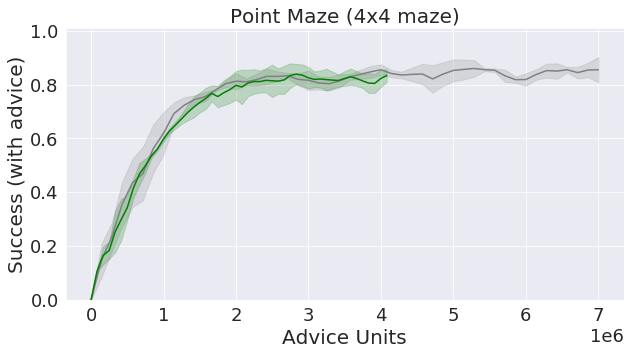

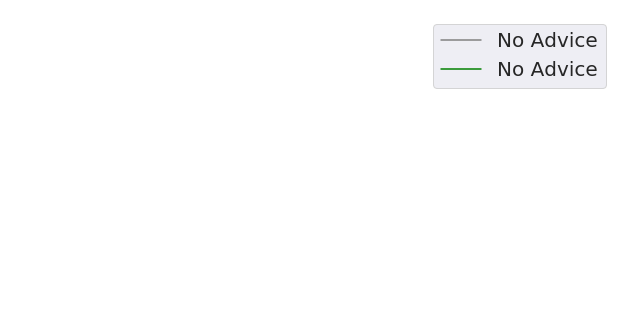

In [174]:
samples = False


plt.rcParams['figure.figsize'] = [10, 5]

x_unit = 'Samples' if samples else 'feedback'
x_label = 'Samples' if samples else 'Advice Units'
x_max = 1.4e6 if samples else 1e6
smooth = 10

all_multiplier = 40 * 20 if samples else 1


data_names = [
        # (['M0000', 'M0001', 'M0002'], 'Direction Advice', all_multiplier, 'red', None),
#         (['M0003', 'M0004', 'M0005'], 'Cardinal Advice', all_multiplier, 'cyan', None),
#         (['M0006', 'M0007', 'M0008'], 'Waypoint Advice', all_multiplier, 'blue', None),
#         (['M0009', 'M0010', 'M0011'], 'OffsetWaypoint Advice', all_multiplier, 'dodgerblue', None),
        (['M0012', 'M0013', 'M0014'], 'No Advice', all_multiplier, 'gray', None),
        (['TT5936', 'TT5937', 'TT5938'], 'No Advice', all_multiplier, 'green', None),
    ]


metric = 'success_rate'
plot_finetune_generalization(data_names, 'Point Maze (4x4 maze)', metric=metric, smooth=global_smooth, 
                             x_label=x_label, x_max=None, 
                             save_name=None,
                             y_label="Success (with advice)")

In [ ]:
# samples = False


# plt.rcParams['figure.figsize'] = [10, 5]

# x_unit = 'Samples' if samples else 'feedback'
# x_label = 'Samples' if samples else 'Advice Units'
# x_max = 2e6 if samples else 1e7
# all_multiplier = 40 * 20 if samples else 1


# smooth = 200


# data_names = [    
#         (['M0309',], 'OffsetWaypoint Advice', all_multiplier, 'red', None),
#         (['M0310'], 'OffsetWaypoint Advice', all_multiplier, 'dodgerblue', None),
#         ([ 'M0311'], 'OffsetWaypoint Advice', all_multiplier, 'green', None),
#     ]



# metric = 'success_rate'
# plot_finetune_generalization(data_names, 'Ant (3x3 maze)', metric=metric, smooth=5, 
#                              x_label=x_label, x_max=None,
#                              y_min=-.03,
#                              save_name=f'rl_train_ant{"_samples" if samples else ""}.pdf',
#                              y_label="Success (with advice)")

In [ ]:
samples = False

x_unit = 'Samples' if samples else 'feedback'
x_label = 'Samples' if samples else 'Advice Units'
all_multiplier = 40 * 20 if samples else 1


plt.rcParams['figure.figsize'] = [5, 3]


metric = 'success_rate'
smooth=50



data_names = [
        (['M0336', 'M0337', 'M0338'], 'Offset', all_multiplier, offset_color, None),
        (['M0339', 'M0340', 'M0341'], 'RL', all_multiplier, rl_color, None),
    ]
x_max = 1e6 if samples else 3e5
plot_finetune_generalization(data_names, 'Ant Maze (3x3 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
#                              x_max=x_max, 
                             y_min=-.05, 
                             save_name=None, 
                             y_label="Success w/o Advice")


data_names = [
        (['M0354', 'M0355', 'M0356'], 'Offset', all_multiplier, offset_color, None),
        (['M0357', 'M0358', 'M0359'], 'RL', all_multiplier, rl_color, None),
    ]

x_max = 1e6 if samples else 3e5
plot_finetune_generalization(data_names, 'Ant Maze (6x6 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
#                              x_max=x_max, 
                             y_min=-.05, 
                             save_name=None, 
                             y_label="Success w/o Advice")




In [ ]:

data_names = [
        (['M0354', 'M0355', 'M0356'], 'Offset', all_multiplier, offset_color, None),
        (['M0357', 'M0358', 'M0359'], 'RL', all_multiplier, rl_color, None),
    ]

x_max = 1e6 if samples else 3e5
plot_finetune_generalization(data_names, 'Ant Maze (6x6 Maze)', 
                             metric=metric, 
                             smooth=global_smooth, 
                             x_label=x_unit, 
#                              x_max=x_max, 
                             y_min=-.05, 
                             save_name=None, 
                             y_label="Success w/o Advice")